## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


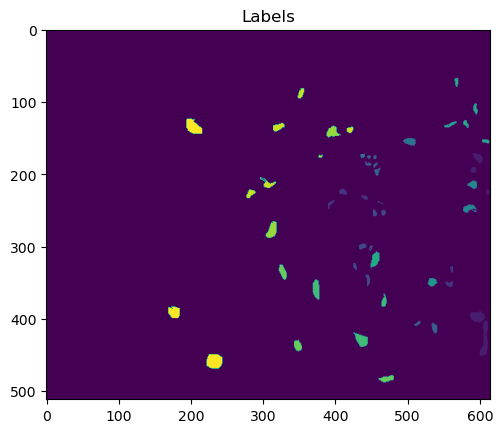

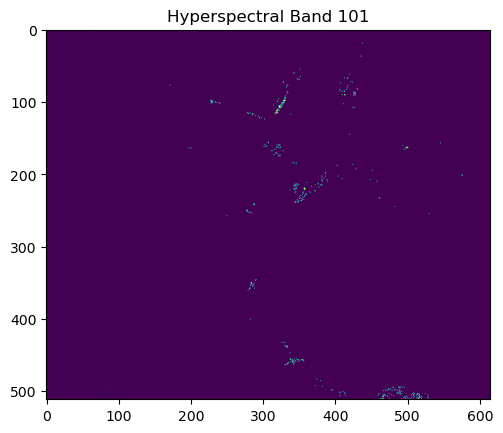

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Selected 5


All datasets saved to the 'indices' folder.
(65, 5, 5, 176)
(65, 5, 5, 176)
(5081, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 65
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2513, PSNR: 5.9984


Epoch [1/50] Training Loss: 0.2399, PSNR: 6.2018
	[Val]   Batch [1/17] Loss: 0.2249, PSNR: 6.4802
	[Val]   Batch [10/17] Loss: 0.2255, PSNR: 6.4684
Epoch [1/50] Validation Loss: 0.2252, PSNR: 6.4737

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2176, PSNR: 6.6225


Epoch [2/50] Training Loss: 0.2023, PSNR: 6.9451
	[Val]   Batch [1/17] Loss: 0.1777, PSNR: 7.5019
	[Val]   Batch [10/17] Loss: 0.1801, PSNR: 7.4437
Epoch [2/50] Validation Loss: 0.1793, PSNR: 7.4637

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1789, PSNR: 7.4744


Epoch [3/50] Training Loss: 0.1652, PSNR: 7.8270
	[Val]   Batch [1/17] Loss: 0.1422, PSNR: 8.4700
	[Val]   Batch [10/17] Loss: 0.1452, PSNR: 8.3808
Epoch [3/50] Validation Loss: 0.1442, PSNR: 8.4108

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1450, PSNR: 8.3867


Epoch [4/50] Training Loss: 0.1328, PSNR: 8.7768
	[Val]   Batch [1/17] Loss: 0.1143, PSNR: 9.4177
	[Val]   Batch [10/17] Loss: 0.1155, PSNR: 9.3724
Epoch [4/50] Validation Loss: 0.1152, PSNR: 9.3846

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1157, PSNR: 9.3650


Epoch [5/50] Training Loss: 0.1053, PSNR: 9.7819
	[Val]   Batch [1/17] Loss: 0.0912, PSNR: 10.4011
	[Val]   Batch [10/17] Loss: 0.0923, PSNR: 10.3501
Epoch [5/50] Validation Loss: 0.0918, PSNR: 10.3702

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0918, PSNR: 10.3694


Epoch [6/50] Training Loss: 0.0837, PSNR: 10.7807
	[Val]   Batch [1/17] Loss: 0.0739, PSNR: 11.3139
	[Val]   Batch [10/17] Loss: 0.0744, PSNR: 11.2853
Epoch [6/50] Validation Loss: 0.0742, PSNR: 11.2966

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0727, PSNR: 11.3832


Epoch [7/50] Training Loss: 0.0671, PSNR: 11.0518
	[Val]   Batch [1/17] Loss: 0.0604, PSNR: 12.1903
	[Val]   Batch [10/17] Loss: 0.0608, PSNR: 12.1576
Epoch [7/50] Validation Loss: 0.0607, PSNR: 12.1662

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0596, PSNR: 12.2486


Epoch [8/50] Training Loss: 0.0549, PSNR: 12.6118
	[Val]   Batch [1/17] Loss: 0.0499, PSNR: 13.0220
	[Val]   Batch [10/17] Loss: 0.0504, PSNR: 12.9793
Epoch [8/50] Validation Loss: 0.0501, PSNR: 12.9986

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0488, PSNR: 13.1159


Epoch [9/50] Training Loss: 0.0456, PSNR: 13.4198
	[Val]   Batch [1/17] Loss: 0.0419, PSNR: 13.7729
	[Val]   Batch [10/17] Loss: 0.0424, PSNR: 13.7240
Epoch [9/50] Validation Loss: 0.0422, PSNR: 13.7503

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0408, PSNR: 13.8888


Epoch [10/50] Training Loss: 0.0385, PSNR: 13.4637
	[Val]   Batch [1/17] Loss: 0.0364, PSNR: 14.3937
	[Val]   Batch [10/17] Loss: 0.0367, PSNR: 14.3499
Epoch [10/50] Validation Loss: 0.0365, PSNR: 14.3728

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0349, PSNR: 14.5672


Epoch [11/50] Training Loss: 0.0331, PSNR: 14.8109
	[Val]   Batch [1/17] Loss: 0.0312, PSNR: 15.0635
	[Val]   Batch [10/17] Loss: 0.0314, PSNR: 15.0363
Epoch [11/50] Validation Loss: 0.0312, PSNR: 15.0532

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0304, PSNR: 15.1764


Epoch [12/50] Training Loss: 0.0288, PSNR: 15.4100
	[Val]   Batch [1/17] Loss: 0.0274, PSNR: 15.6259
	[Val]   Batch [10/17] Loss: 0.0276, PSNR: 15.5899
Epoch [12/50] Validation Loss: 0.0275, PSNR: 15.6061

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0268, PSNR: 15.7263


Epoch [13/50] Training Loss: 0.0253, PSNR: 15.9717
	[Val]   Batch [1/17] Loss: 0.0244, PSNR: 16.1201
	[Val]   Batch [10/17] Loss: 0.0247, PSNR: 16.0645
Epoch [13/50] Validation Loss: 0.0246, PSNR: 16.0883

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0235, PSNR: 16.2902


Epoch [14/50] Training Loss: 0.0225, PSNR: 15.7957
	[Val]   Batch [1/17] Loss: 0.0222, PSNR: 16.5355
	[Val]   Batch [10/17] Loss: 0.0225, PSNR: 16.4869
Epoch [14/50] Validation Loss: 0.0223, PSNR: 16.5117

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0211, PSNR: 16.7609


Epoch [15/50] Training Loss: 0.0201, PSNR: 16.9615
	[Val]   Batch [1/17] Loss: 0.0192, PSNR: 17.1623
	[Val]   Batch [10/17] Loss: 0.0194, PSNR: 17.1118
Epoch [15/50] Validation Loss: 0.0193, PSNR: 17.1379

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0190, PSNR: 17.2055


Epoch [16/50] Training Loss: 0.0182, PSNR: 17.4044
	[Val]   Batch [1/17] Loss: 0.0176, PSNR: 17.5435
	[Val]   Batch [10/17] Loss: 0.0178, PSNR: 17.4862
Epoch [16/50] Validation Loss: 0.0177, PSNR: 17.5120

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0170, PSNR: 17.6838


Epoch [17/50] Training Loss: 0.0165, PSNR: 17.8295
	[Val]   Batch [1/17] Loss: 0.0161, PSNR: 17.9386
	[Val]   Batch [10/17] Loss: 0.0162, PSNR: 17.8925
Epoch [17/50] Validation Loss: 0.0162, PSNR: 17.9139

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0155, PSNR: 18.1066


Epoch [18/50] Training Loss: 0.0151, PSNR: 18.2233
	[Val]   Batch [1/17] Loss: 0.0151, PSNR: 18.2041
	[Val]   Batch [10/17] Loss: 0.0153, PSNR: 18.1411
Epoch [18/50] Validation Loss: 0.0153, PSNR: 18.1660

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0143, PSNR: 18.4583


Epoch [19/50] Training Loss: 0.0138, PSNR: 18.6017
	[Val]   Batch [1/17] Loss: 0.0135, PSNR: 18.6901
	[Val]   Batch [10/17] Loss: 0.0137, PSNR: 18.6326
Epoch [19/50] Validation Loss: 0.0136, PSNR: 18.6605

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0129, PSNR: 18.8787


Epoch [20/50] Training Loss: 0.0127, PSNR: 18.9583
	[Val]   Batch [1/17] Loss: 0.0126, PSNR: 19.0084
	[Val]   Batch [10/17] Loss: 0.0128, PSNR: 18.9442
Epoch [20/50] Validation Loss: 0.0127, PSNR: 18.9745

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0119, PSNR: 19.2441


Epoch [21/50] Training Loss: 0.0117, PSNR: 19.3025
	[Val]   Batch [1/17] Loss: 0.0116, PSNR: 19.3689
	[Val]   Batch [10/17] Loss: 0.0117, PSNR: 19.3056
Epoch [21/50] Validation Loss: 0.0117, PSNR: 19.3334

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0112, PSNR: 19.5103


Epoch [22/50] Training Loss: 0.0109, PSNR: 19.6241
	[Val]   Batch [1/17] Loss: 0.0108, PSNR: 19.6495
	[Val]   Batch [10/17] Loss: 0.0110, PSNR: 19.5920
Epoch [22/50] Validation Loss: 0.0109, PSNR: 19.6174

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0106, PSNR: 19.7427


Epoch [23/50] Training Loss: 0.0102, PSNR: 19.9332
	[Val]   Batch [1/17] Loss: 0.0101, PSNR: 19.9776
	[Val]   Batch [10/17] Loss: 0.0102, PSNR: 19.9045
Epoch [23/50] Validation Loss: 0.0101, PSNR: 19.9361

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0096, PSNR: 20.1734


Epoch [24/50] Training Loss: 0.0095, PSNR: 20.2336
	[Val]   Batch [1/17] Loss: 0.0094, PSNR: 20.2620
	[Val]   Batch [10/17] Loss: 0.0096, PSNR: 20.1873
Epoch [24/50] Validation Loss: 0.0095, PSNR: 20.2187

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0091, PSNR: 20.4217


Epoch [25/50] Training Loss: 0.0089, PSNR: 20.5258
	[Val]   Batch [1/17] Loss: 0.0089, PSNR: 20.5166
	[Val]   Batch [10/17] Loss: 0.0090, PSNR: 20.4376
Epoch [25/50] Validation Loss: 0.0090, PSNR: 20.4723

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0084, PSNR: 20.7386


Epoch [26/50] Training Loss: 0.0083, PSNR: 20.7937
	[Val]   Batch [1/17] Loss: 0.0082, PSNR: 20.8393
	[Val]   Batch [10/17] Loss: 0.0084, PSNR: 20.7476
Epoch [26/50] Validation Loss: 0.0083, PSNR: 20.7869

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0079, PSNR: 21.0266


Epoch [27/50] Training Loss: 0.0078, PSNR: 21.0632
	[Val]   Batch [1/17] Loss: 0.0078, PSNR: 21.0635
	[Val]   Batch [10/17] Loss: 0.0080, PSNR: 20.9828
Epoch [27/50] Validation Loss: 0.0079, PSNR: 21.0194

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0075, PSNR: 21.2272


Epoch [28/50] Training Loss: 0.0074, PSNR: 21.3253
	[Val]   Batch [1/17] Loss: 0.0074, PSNR: 21.3369
	[Val]   Batch [10/17] Loss: 0.0075, PSNR: 21.2298
Epoch [28/50] Validation Loss: 0.0075, PSNR: 21.2751

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0071, PSNR: 21.4676


Epoch [29/50] Training Loss: 0.0070, PSNR: 21.5758
	[Val]   Batch [1/17] Loss: 0.0069, PSNR: 21.5945
	[Val]   Batch [10/17] Loss: 0.0071, PSNR: 21.4961
Epoch [29/50] Validation Loss: 0.0070, PSNR: 21.5395

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0066, PSNR: 21.8251


Epoch [30/50] Training Loss: 0.0066, PSNR: 21.8222
	[Val]   Batch [1/17] Loss: 0.0066, PSNR: 21.8228
	[Val]   Batch [10/17] Loss: 0.0067, PSNR: 21.7219
Epoch [30/50] Validation Loss: 0.0067, PSNR: 21.7668

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0063, PSNR: 22.0288


Epoch [31/50] Training Loss: 0.0062, PSNR: 22.0589
	[Val]   Batch [1/17] Loss: 0.0062, PSNR: 22.0860
	[Val]   Batch [10/17] Loss: 0.0063, PSNR: 21.9741
Epoch [31/50] Validation Loss: 0.0063, PSNR: 22.0228

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0060, PSNR: 22.2478


Epoch [32/50] Training Loss: 0.0059, PSNR: 22.2849
	[Val]   Batch [1/17] Loss: 0.0059, PSNR: 22.2880
	[Val]   Batch [10/17] Loss: 0.0061, PSNR: 22.1697
Epoch [32/50] Validation Loss: 0.0060, PSNR: 22.2196

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0059, PSNR: 22.2876


Epoch [33/50] Training Loss: 0.0056, PSNR: 22.5062
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.5556
	[Val]   Batch [10/17] Loss: 0.0057, PSNR: 22.4374
Epoch [33/50] Validation Loss: 0.0056, PSNR: 22.4868

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0055, PSNR: 22.6345


Epoch [34/50] Training Loss: 0.0053, PSNR: 22.7182
	[Val]   Batch [1/17] Loss: 0.0054, PSNR: 22.7050
	[Val]   Batch [10/17] Loss: 0.0055, PSNR: 22.5898
Epoch [34/50] Validation Loss: 0.0054, PSNR: 22.6391

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0052, PSNR: 22.8513


Epoch [35/50] Training Loss: 0.0051, PSNR: 22.9297
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.9576
	[Val]   Batch [10/17] Loss: 0.0052, PSNR: 22.8211
Epoch [35/50] Validation Loss: 0.0052, PSNR: 22.8774

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0052, PSNR: 22.8523


Epoch [36/50] Training Loss: 0.0049, PSNR: 22.4626
	[Val]   Batch [1/17] Loss: 0.0049, PSNR: 23.0924
	[Val]   Batch [10/17] Loss: 0.0051, PSNR: 22.9547
Epoch [36/50] Validation Loss: 0.0050, PSNR: 23.0100

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0047, PSNR: 23.2608


Epoch [37/50] Training Loss: 0.0046, PSNR: 23.3374
	[Val]   Batch [1/17] Loss: 0.0047, PSNR: 23.3239
	[Val]   Batch [10/17] Loss: 0.0048, PSNR: 23.1846
Epoch [37/50] Validation Loss: 0.0047, PSNR: 23.2409

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0045, PSNR: 23.5148


Epoch [38/50] Training Loss: 0.0044, PSNR: 22.8394
	[Val]   Batch [1/17] Loss: 0.0045, PSNR: 23.5044
	[Val]   Batch [10/17] Loss: 0.0046, PSNR: 23.3652
Epoch [38/50] Validation Loss: 0.0045, PSNR: 23.4211

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0044, PSNR: 23.6048


Epoch [39/50] Training Loss: 0.0043, PSNR: 23.7179
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7416
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.5924
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.6511

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0041, PSNR: 23.9082


Epoch [40/50] Training Loss: 0.0041, PSNR: 23.9024
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 23.9274
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.7707
Epoch [40/50] Validation Loss: 0.0041, PSNR: 23.8318

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0041, PSNR: 23.9056


Epoch [41/50] Training Loss: 0.0039, PSNR: 24.0767
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.0881
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 23.9263
Epoch [41/50] Validation Loss: 0.0040, PSNR: 23.9910

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0038, PSNR: 24.2241


Epoch [42/50] Training Loss: 0.0038, PSNR: 24.2568
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.2666
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.0982
Epoch [42/50] Validation Loss: 0.0038, PSNR: 24.1638

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 24.0205


Epoch [43/50] Training Loss: 0.0036, PSNR: 24.4291
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.4443
	[Val]   Batch [10/17] Loss: 0.0037, PSNR: 24.2734
Epoch [43/50] Validation Loss: 0.0037, PSNR: 24.3405

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.6367


Epoch [44/50] Training Loss: 0.0035, PSNR: 23.9277
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.5898
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4089
Epoch [44/50] Validation Loss: 0.0036, PSNR: 24.4794

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.6117


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.7576
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.7991
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.6117
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.6850

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8231


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.9125
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9330
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.7334
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.8101

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 25.0137


Epoch [47/50] Training Loss: 0.0031, PSNR: 25.0712
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1346
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9339
Epoch [47/50] Validation Loss: 0.0032, PSNR: 25.0118

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.0716


Epoch [48/50] Training Loss: 0.0030, PSNR: 24.5266
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.2036
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9980
Epoch [48/50] Validation Loss: 0.0031, PSNR: 25.0769

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.4112


Epoch [49/50] Training Loss: 0.0029, PSNR: 25.3777
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3818
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.1689
Epoch [49/50] Validation Loss: 0.0030, PSNR: 25.2520

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3969


Epoch [50/50] Training Loss: 0.0028, PSNR: 24.8377
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5094
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2926
Epoch [50/50] Validation Loss: 0.0029, PSNR: 25.3754


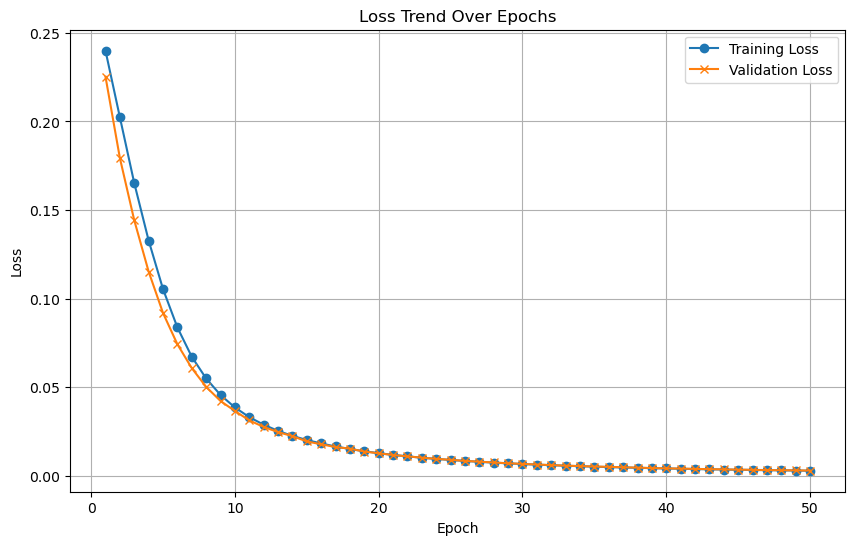

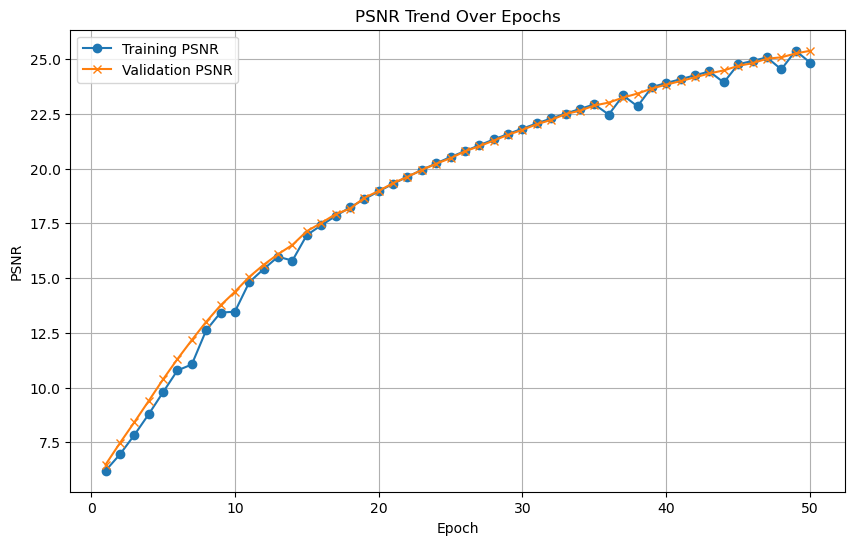

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.5647
    Validation Batch [1/1], Loss: 2.5696
Validation Loss: 2.5696, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5696. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5654
    Validation Batch [1/1], Loss: 2.5696
Validation Loss: 2.5696, Validation Accuracy: 7.69%
Validation loss improved from 2.5696 to 2.5696. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5409
    Validation Batch [1/1], Loss: 2.5695
Validation Loss: 2.5695, Validation Accuracy: 7.69%
Validation loss improved from 2.5696 to 2.5695. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5370
    Validation Batch [1/1], Loss: 2.5695
Validation Loss: 2.5695, Validation Accuracy: 7.69%
Validation loss improved from 2.5695 to 2.5695. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] complete

Epoch [20/1000] completed, Average Training Loss: 2.4425
    Validation Batch [1/1], Loss: 2.5688
Validation Loss: 2.5688, Validation Accuracy: 7.69%
Validation loss improved from 2.5688 to 2.5688. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4165
    Validation Batch [1/1], Loss: 2.5688
Validation Loss: 2.5688, Validation Accuracy: 7.69%
Validation loss improved from 2.5688 to 2.5688. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4337
    Validation Batch [1/1], Loss: 2.5687
Validation Loss: 2.5687, Validation Accuracy: 7.69%
Validation loss improved from 2.5688 to 2.5687. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.3807
    Validation Batch [1/1], Loss: 2.5688
Validation Loss: 2.5688, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, 

Epoch [35/1000] completed, Average Training Loss: 2.3025
    Validation Batch [1/1], Loss: 2.5724
Validation Loss: 2.5724, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [36/1000] - Training
Epoch [36/1000] completed, Average Training Loss: 2.3033
    Validation Batch [1/1], Loss: 2.5731
Validation Loss: 2.5731, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [37/1000] - Training
Epoch [37/1000] completed, Average Training Loss: 2.2968
    Validation Batch [1/1], Loss: 2.5741
Validation Loss: 2.5741, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 2.2794
    Validation Batch [1/1], Loss: 2.5751
Validation Loss: 2.5751, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.2918
    Validat

Epoch [52/1000] completed, Average Training Loss: 2.1723
    Validation Batch [1/1], Loss: 2.5990
Validation Loss: 2.5990, Validation Accuracy: 10.77%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.1619
    Validation Batch [1/1], Loss: 2.6006
Validation Loss: 2.6006, Validation Accuracy: 10.77%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.1423
    Validation Batch [1/1], Loss: 2.6022
Validation Loss: 2.6022, Validation Accuracy: 10.77%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.1391
    Validation Batch [1/1], Loss: 2.6036
Validation Loss: 2.6036, Validation Accuracy: 10.77%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.1610
    Val

Epoch [66/1000] completed, Average Training Loss: 2.0759
    Validation Batch [1/1], Loss: 2.6157
Validation Loss: 2.6157, Validation Accuracy: 10.77%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 2.0767
    Validation Batch [1/1], Loss: 2.6152
Validation Loss: 2.6152, Validation Accuracy: 10.77%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 2.0689
    Validation Batch [1/1], Loss: 2.6143
Validation Loss: 2.6143, Validation Accuracy: 10.77%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 2.0428
    Validation Batch [1/1], Loss: 2.6125
Validation Loss: 2.6125, Validation Accuracy: 10.77%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 2.0426
    Val

Epoch [85/1000] completed, Average Training Loss: 1.9206
    Validation Batch [1/1], Loss: 2.4220
Validation Loss: 2.4220, Validation Accuracy: 12.31%
Validation loss improved from 2.4423 to 2.4220. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.9301
    Validation Batch [1/1], Loss: 2.4032
Validation Loss: 2.4032, Validation Accuracy: 15.38%
Validation loss improved from 2.4220 to 2.4032. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.9054
    Validation Batch [1/1], Loss: 2.3819
Validation Loss: 2.3819, Validation Accuracy: 13.85%
Validation loss improved from 2.4032 to 2.3819. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.8797
    Validation Batch [1/1], Loss: 2.3609
Validation Loss: 2.3609, Validation Accuracy: 13.85%
Validation loss improved from 2.3819 to 2.3609. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [8

Epoch [97/1000] completed, Average Training Loss: 1.8677
    Validation Batch [1/1], Loss: 2.1644
Validation Loss: 2.1644, Validation Accuracy: 27.69%
Validation loss improved from 2.1757 to 2.1644. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.8407
    Validation Batch [1/1], Loss: 2.1520
Validation Loss: 2.1520, Validation Accuracy: 27.69%
Validation loss improved from 2.1644 to 2.1520. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.8618
    Validation Batch [1/1], Loss: 2.1373
Validation Loss: 2.1373, Validation Accuracy: 29.23%
Validation loss improved from 2.1520 to 2.1373. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.8237
    Validation Batch [1/1], Loss: 2.1251
Validation Loss: 2.1251, Validation Accuracy: 27.69%
Validation loss improved from 2.1373 to 2.1251. Saving model...

LOG: Epoch [101/1000] - Training
Epoch

    Validation Batch [1/1], Loss: 1.9908
Validation Loss: 1.9908, Validation Accuracy: 41.54%
Validation loss improved from 1.9949 to 1.9908. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 1.6958
    Validation Batch [1/1], Loss: 1.9845
Validation Loss: 1.9845, Validation Accuracy: 41.54%
Validation loss improved from 1.9908 to 1.9845. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.6717
    Validation Batch [1/1], Loss: 1.9769
Validation Loss: 1.9769, Validation Accuracy: 41.54%
Validation loss improved from 1.9845 to 1.9769. Saving model...

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 1.6484
    Validation Batch [1/1], Loss: 1.9660
Validation Loss: 1.9660, Validation Accuracy: 41.54%
Validation loss improved from 1.9769 to 1.9660. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.6734


Epoch [131/1000] completed, Average Training Loss: 1.5792
    Validation Batch [1/1], Loss: 1.8940
Validation Loss: 1.8940, Validation Accuracy: 41.54%
Validation loss improved from 1.9028 to 1.8940. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 1.5713
    Validation Batch [1/1], Loss: 1.8942
Validation Loss: 1.8942, Validation Accuracy: 38.46%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.5509
    Validation Batch [1/1], Loss: 1.8877
Validation Loss: 1.8877, Validation Accuracy: 40.00%
Validation loss improved from 1.8940 to 1.8877. Saving model...

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training Loss: 1.5321
    Validation Batch [1/1], Loss: 1.8766
Validation Loss: 1.8766, Validation Accuracy: 38.46%
Validation loss improved from 1.8877 to 1.8766. Saving model...

LOG: Epoch [135/1000] - Training
Epoch [135/1000

    Validation Batch [1/1], Loss: 1.8052
Validation Loss: 1.8052, Validation Accuracy: 44.62%
Validation loss improved from 1.8138 to 1.8052. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.4863
    Validation Batch [1/1], Loss: 1.7966
Validation Loss: 1.7966, Validation Accuracy: 44.62%
Validation loss improved from 1.8052 to 1.7966. Saving model...

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.4016
    Validation Batch [1/1], Loss: 1.7888
Validation Loss: 1.7888, Validation Accuracy: 43.08%
Validation loss improved from 1.7966 to 1.7888. Saving model...

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.3885
    Validation Batch [1/1], Loss: 1.7806
Validation Loss: 1.7806, Validation Accuracy: 44.62%
Validation loss improved from 1.7888 to 1.7806. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.4109


Epoch [165/1000] completed, Average Training Loss: 1.3116
    Validation Batch [1/1], Loss: 1.7082
Validation Loss: 1.7082, Validation Accuracy: 46.15%
Validation loss improved from 1.7130 to 1.7082. Saving model...

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.2912
    Validation Batch [1/1], Loss: 1.7044
Validation Loss: 1.7044, Validation Accuracy: 46.15%
Validation loss improved from 1.7082 to 1.7044. Saving model...

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.3200
    Validation Batch [1/1], Loss: 1.7048
Validation Loss: 1.7048, Validation Accuracy: 47.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.3130
    Validation Batch [1/1], Loss: 1.7048
Validation Loss: 1.7048, Validation Accuracy: 47.69%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Av

    Validation Batch [1/1], Loss: 1.6572
Validation Loss: 1.6572, Validation Accuracy: 49.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.1514
    Validation Batch [1/1], Loss: 1.6577
Validation Loss: 1.6577, Validation Accuracy: 49.23%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.1938
    Validation Batch [1/1], Loss: 1.6555
Validation Loss: 1.6555, Validation Accuracy: 49.23%
Validation loss improved from 1.6557 to 1.6555. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.1431
    Validation Batch [1/1], Loss: 1.6559
Validation Loss: 1.6559, Validation Accuracy: 49.23%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.1793
    Validation Batch [1/1], Loss: 1.6537
Vali

Epoch [196/1000] completed, Average Training Loss: 0.9995
    Validation Batch [1/1], Loss: 1.6193
Validation Loss: 1.6193, Validation Accuracy: 52.31%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 1.1229
    Validation Batch [1/1], Loss: 1.6129
Validation Loss: 1.6129, Validation Accuracy: 52.31%
Validation loss improved from 1.6178 to 1.6129. Saving model...

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 1.0547
    Validation Batch [1/1], Loss: 1.6054
Validation Loss: 1.6054, Validation Accuracy: 52.31%
Validation loss improved from 1.6129 to 1.6054. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 1.0466
    Validation Batch [1/1], Loss: 1.6045
Validation Loss: 1.6045, Validation Accuracy: 52.31%
Validation loss improved from 1.6054 to 1.6045. Saving model...

LOG: Epoch [200/1000] - Training
Epoch [200/1000

Epoch [212/1000] completed, Average Training Loss: 0.9887
    Validation Batch [1/1], Loss: 1.5694
Validation Loss: 1.5694, Validation Accuracy: 50.77%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.9262
    Validation Batch [1/1], Loss: 1.5725
Validation Loss: 1.5725, Validation Accuracy: 52.31%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.9266
    Validation Batch [1/1], Loss: 1.5808
Validation Loss: 1.5808, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.9383
    Validation Batch [1/1], Loss: 1.5852
Validation Loss: 1.5852, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.9686
  

Epoch [229/1000] completed, Average Training Loss: 0.8427
    Validation Batch [1/1], Loss: 1.5460
Validation Loss: 1.5460, Validation Accuracy: 52.31%
Validation loss improved from 1.5600 to 1.5460. Saving model...

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.8547
    Validation Batch [1/1], Loss: 1.5395
Validation Loss: 1.5395, Validation Accuracy: 52.31%
Validation loss improved from 1.5460 to 1.5395. Saving model...

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.8280
    Validation Batch [1/1], Loss: 1.5414
Validation Loss: 1.5414, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.8670
    Validation Batch [1/1], Loss: 1.5411
Validation Loss: 1.5411, Validation Accuracy: 52.31%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Av

    Validation Batch [1/1], Loss: 1.5289
Validation Loss: 1.5289, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.7622
    Validation Batch [1/1], Loss: 1.5401
Validation Loss: 1.5401, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.6965
    Validation Batch [1/1], Loss: 1.5483
Validation Loss: 1.5483, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.7155
    Validation Batch [1/1], Loss: 1.5327
Validation Loss: 1.5327, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.7653
    Validation Batch [1/1], Loss: 1.5153
Validation Loss: 1.

Epoch [261/1000] completed, Average Training Loss: 0.6095
    Validation Batch [1/1], Loss: 1.5283
Validation Loss: 1.5283, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.7242
    Validation Batch [1/1], Loss: 1.5144
Validation Loss: 1.5144, Validation Accuracy: 58.46%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.6157
    Validation Batch [1/1], Loss: 1.5044
Validation Loss: 1.5044, Validation Accuracy: 58.46%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [264/1000] - Training
Epoch [264/1000] completed, Average Training Loss: 0.7041
    Validation Batch [1/1], Loss: 1.5174
Validation Loss: 1.5174, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [265/1000] - Training
Epoch [265/1000] completed, Average Training Loss: 0.6482
  

Epoch [279/1000] completed, Average Training Loss: 0.6093
    Validation Batch [1/1], Loss: 1.4330
Validation Loss: 1.4330, Validation Accuracy: 61.54%
Validation loss improved from 1.4331 to 1.4330. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.5720
    Validation Batch [1/1], Loss: 1.4258
Validation Loss: 1.4258, Validation Accuracy: 63.08%
Validation loss improved from 1.4330 to 1.4258. Saving model...

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.5901
    Validation Batch [1/1], Loss: 1.4195
Validation Loss: 1.4195, Validation Accuracy: 64.62%
Validation loss improved from 1.4258 to 1.4195. Saving model...

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.5439
    Validation Batch [1/1], Loss: 1.4035
Validation Loss: 1.4035, Validation Accuracy: 64.62%
Validation loss improved from 1.4195 to 1.4035. Saving model...

LOG: Epoch [283/1000] - Training


Epoch [295/1000] completed, Average Training Loss: 0.4477
    Validation Batch [1/1], Loss: 1.3720
Validation Loss: 1.3720, Validation Accuracy: 67.69%
Validation loss improved from 1.3734 to 1.3720. Saving model...

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.4963
    Validation Batch [1/1], Loss: 1.3737
Validation Loss: 1.3737, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.5456
    Validation Batch [1/1], Loss: 1.3732
Validation Loss: 1.3732, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.4851
    Validation Batch [1/1], Loss: 1.3776
Validation Loss: 1.3776, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training 

Epoch [311/1000] completed, Average Training Loss: 0.4419
    Validation Batch [1/1], Loss: 1.3976
Validation Loss: 1.3976, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.3861
    Validation Batch [1/1], Loss: 1.3879
Validation Loss: 1.3879, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.3823
    Validation Batch [1/1], Loss: 1.3753
Validation Loss: 1.3753, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.4553
    Validation Batch [1/1], Loss: 1.3615
Validation Loss: 1.3615, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.3892
  

Epoch [327/1000] completed, Average Training Loss: 0.3722
    Validation Batch [1/1], Loss: 1.3288
Validation Loss: 1.3288, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.3121
    Validation Batch [1/1], Loss: 1.3198
Validation Loss: 1.3198, Validation Accuracy: 66.15%
Validation loss improved from 1.3199 to 1.3198. Saving model...

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.3586
    Validation Batch [1/1], Loss: 1.3115
Validation Loss: 1.3115, Validation Accuracy: 67.69%
Validation loss improved from 1.3198 to 1.3115. Saving model...

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.3665
    Validation Batch [1/1], Loss: 1.3123
Validation Loss: 1.3123, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Av

Epoch [340/1000] completed, Average Training Loss: 0.2841
    Validation Batch [1/1], Loss: 1.2948
Validation Loss: 1.2948, Validation Accuracy: 69.23%
Validation loss improved from 1.2990 to 1.2948. Saving model...

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.2983
    Validation Batch [1/1], Loss: 1.2821
Validation Loss: 1.2821, Validation Accuracy: 69.23%
Validation loss improved from 1.2948 to 1.2821. Saving model...

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.3124
    Validation Batch [1/1], Loss: 1.2850
Validation Loss: 1.2850, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.2756
    Validation Batch [1/1], Loss: 1.2922
Validation Loss: 1.2922, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Av

Epoch [355/1000] completed, Average Training Loss: 0.2832
    Validation Batch [1/1], Loss: 1.2650
Validation Loss: 1.2650, Validation Accuracy: 70.77%
Validation loss improved from 1.2716 to 1.2650. Saving model...

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.3273
    Validation Batch [1/1], Loss: 1.2618
Validation Loss: 1.2618, Validation Accuracy: 72.31%
Validation loss improved from 1.2650 to 1.2618. Saving model...

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.2813
    Validation Batch [1/1], Loss: 1.2653
Validation Loss: 1.2653, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.2503
    Validation Batch [1/1], Loss: 1.2733
Validation Loss: 1.2733, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Av

    Validation Batch [1/1], Loss: 1.3185
Validation Loss: 1.3185, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.2174
    Validation Batch [1/1], Loss: 1.3045
Validation Loss: 1.3045, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.2151
    Validation Batch [1/1], Loss: 1.2893
Validation Loss: 1.2893, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.2493
    Validation Batch [1/1], Loss: 1.2840
Validation Loss: 1.2840, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.2020
    Validation Batch [1/1], Loss: 1.2900
Validation Loss

Epoch [387/1000] completed, Average Training Loss: 0.1934
    Validation Batch [1/1], Loss: 1.2617
Validation Loss: 1.2617, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.1826
    Validation Batch [1/1], Loss: 1.2791
Validation Loss: 1.2791, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.1827
    Validation Batch [1/1], Loss: 1.2951
Validation Loss: 1.2951, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.1638
    Validation Batch [1/1], Loss: 1.2884
Validation Loss: 1.2884, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.1789
  

    Validation Batch [1/1], Loss: 1.2542
Validation Loss: 1.2542, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.1977
    Validation Batch [1/1], Loss: 1.2563
Validation Loss: 1.2563, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.1788
    Validation Batch [1/1], Loss: 1.2604
Validation Loss: 1.2604, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.1766
    Validation Batch [1/1], Loss: 1.2551
Validation Loss: 1.2551, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training Loss: 0.1666
    Validation Batch [1/1], Loss: 1.2492
Validation Loss

    Validation Batch [1/1], Loss: 1.2865
Validation Loss: 1.2865, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.1523
    Validation Batch [1/1], Loss: 1.2765
Validation Loss: 1.2765, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1618
    Validation Batch [1/1], Loss: 1.2717
Validation Loss: 1.2717, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1238
    Validation Batch [1/1], Loss: 1.2675
Validation Loss: 1.2675, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1604
    Validation Batch [1/1], Loss: 1.2688
Validation Loss

Epoch [438/1000] completed, Average Training Loss: 0.1217
    Validation Batch [1/1], Loss: 1.2927
Validation Loss: 1.2927, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.1262
    Validation Batch [1/1], Loss: 1.2799
Validation Loss: 1.2799, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.1297
    Validation Batch [1/1], Loss: 1.2701
Validation Loss: 1.2701, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.1389
    Validation Batch [1/1], Loss: 1.2694
Validation Loss: 1.2694, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.131

Epoch [452/1000] completed, Average Training Loss: 0.1326
    Validation Batch [1/1], Loss: 1.2788
Validation Loss: 1.2788, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.1072
    Validation Batch [1/1], Loss: 1.2915
Validation Loss: 1.2915, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.1394
    Validation Batch [1/1], Loss: 1.3093
Validation Loss: 1.3093, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1253
    Validation Batch [1/1], Loss: 1.3326
Validation Loss: 1.3326, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.146

Epoch [475/1000] completed, Average Training Loss: 0.0966
    Validation Batch [1/1], Loss: 1.2977
Validation Loss: 1.2977, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.0993
    Validation Batch [1/1], Loss: 1.2898
Validation Loss: 1.2898, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.1072
    Validation Batch [1/1], Loss: 1.2773
Validation Loss: 1.2773, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.0972
    Validation Batch [1/1], Loss: 1.2765
Validation Loss: 1.2765, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.114

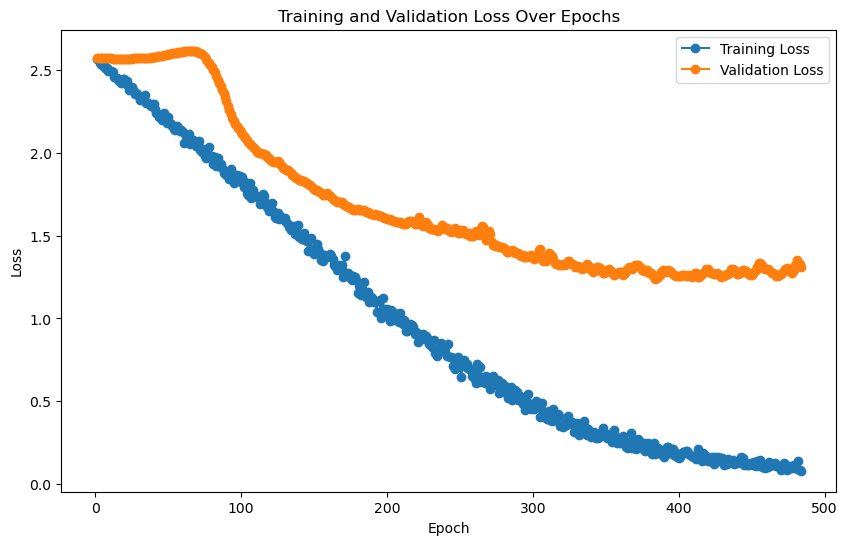

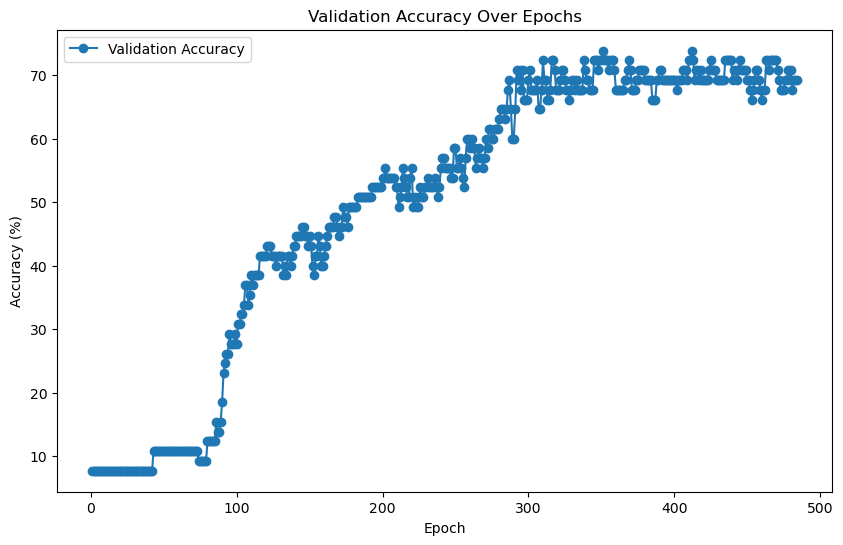


Evaluating on the test set...
    Test Batch [1/20], Loss: 1.4152

Final Test Loss: 1.2950, Test Accuracy: 67.41%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)

LOG: Training features shape: (65, 64), Training labels shape: (65,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (5081, 64), Test labels shape: (5081,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 32.31%

Validation Classification Report:
               precision    recall  f1-sco

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)
Train reps shape: (65, 64)
Train labels shape: (65,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (5081, 64)
Test labels shape: (5081,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6528  |  Val Loss: 2.6521
Validation loss improved from inf to 2.6521.
[Epoch 2/1000] Train Loss: 2.5960  |  Val Loss: 2.6773
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 3/1000] Train Loss: 2.6168  |  Val Loss: 2.7211
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 4/1000] Train Loss: 2.6552  |  Val Loss: 2.7382
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 5/1000] Train Loss: 2.6688  |  Val Loss: 2.7225
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 6/1000] Train Loss: 2.6522  |  Val Loss: 2.6947
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 7/1000] Train Loss: 2.6227  |  Val Loss: 2.6643
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 8/1000] Train Loss: 2.5923  |  Val Loss: 2.6467
Validation loss improved from 2.6521 to 2.6467.
[Epoch 9/1000] Train Loss: 2.5774  |  Val Loss: 2.6329
Validation loss improved from 2.6467 to 2.6329.
[Epoch 10/1000] Train Loss: 2.5657  |  V

[Epoch 32/1000] Train Loss: 2.5080  |  Val Loss: 2.5813
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 33/1000] Train Loss: 2.4997  |  Val Loss: 2.5758
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 34/1000] Train Loss: 2.4928  |  Val Loss: 2.5737
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 35/1000] Train Loss: 2.4884  |  Val Loss: 2.5731
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 36/1000] Train Loss: 2.4877  |  Val Loss: 2.5748
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 37/1000] Train Loss: 2.4834  |  Val Loss: 2.5789
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 38/1000] Train Loss: 2.4789  |  Val Loss: 2.5823
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 39/1000] Train Loss: 2.4758  |  Val Loss: 2.5850
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 40/1000] Train Loss: 2.4738  |  Val Loss: 2.5885
!! Validation loss did NOT improve !! Patience: 18/100
[

[Epoch 44/1000] Train Loss: 2.4709  |  Val Loss: 2.5909
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 45/1000] Train Loss: 2.4701  |  Val Loss: 2.5824
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 46/1000] Train Loss: 2.4696  |  Val Loss: 2.5766
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 47/1000] Train Loss: 2.4694  |  Val Loss: 2.5729
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 48/1000] Train Loss: 2.4693  |  Val Loss: 2.5697
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 49/1000] Train Loss: 2.4693  |  Val Loss: 2.5671
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 50/1000] Train Loss: 2.4701  |  Val Loss: 2.5644
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 51/1000] Train Loss: 2.4694  |  Val Loss: 2.5609
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 52/1000] Train Loss: 2.4672  |  Val Loss: 2.5591
!! Validation loss did NOT improve !! Patience: 30/100
[

[Epoch 76/1000] Train Loss: 2.4588  |  Val Loss: 2.5689
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 77/1000] Train Loss: 2.4507  |  Val Loss: 2.5686
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 78/1000] Train Loss: 2.4435  |  Val Loss: 2.5689
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 79/1000] Train Loss: 2.4381  |  Val Loss: 2.5710
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 80/1000] Train Loss: 2.4351  |  Val Loss: 2.5738
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 81/1000] Train Loss: 2.4342  |  Val Loss: 2.5751
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 82/1000] Train Loss: 2.4335  |  Val Loss: 2.5776
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 83/1000] Train Loss: 2.4342  |  Val Loss: 2.5807
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 84/1000] Train Loss: 2.4359  |  Val Loss: 2.5840
!! Validation loss did NOT improve !! Patience: 62/100
[

[Epoch 91/1000] Train Loss: 2.4307  |  Val Loss: 2.5723
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 92/1000] Train Loss: 2.4283  |  Val Loss: 2.5694
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 93/1000] Train Loss: 2.4256  |  Val Loss: 2.5676
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 94/1000] Train Loss: 2.4230  |  Val Loss: 2.5664
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 95/1000] Train Loss: 2.4213  |  Val Loss: 2.5645
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 96/1000] Train Loss: 2.4192  |  Val Loss: 2.5628
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 97/1000] Train Loss: 2.4177  |  Val Loss: 2.5620
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 98/1000] Train Loss: 2.4164  |  Val Loss: 2.5651
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 99/1000] Train Loss: 2.4159  |  Val Loss: 2.5721
!! Validation loss did NOT improve !! Patience: 77/100
[

[Epoch 116/1000] Train Loss: 2.4285  |  Val Loss: 2.5607
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 117/1000] Train Loss: 2.4310  |  Val Loss: 2.5599
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 118/1000] Train Loss: 2.4327  |  Val Loss: 2.5540
Validation loss improved from 2.5566 to 2.5540.
[Epoch 119/1000] Train Loss: 2.4254  |  Val Loss: 2.5511
Validation loss improved from 2.5540 to 2.5511.
[Epoch 120/1000] Train Loss: 2.4203  |  Val Loss: 2.5517
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 121/1000] Train Loss: 2.4212  |  Val Loss: 2.5521
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 122/1000] Train Loss: 2.4209  |  Val Loss: 2.5494
Validation loss improved from 2.5511 to 2.5494.
[Epoch 123/1000] Train Loss: 2.4169  |  Val Loss: 2.5458
Validation loss improved from 2.5494 to 2.5458.
[Epoch 124/1000] Train Loss: 2.4112  |  Val Loss: 2.5413
Validation loss improved from 2.5458 to 2.5413.
[Epoch 125/1000] Train Loss: 

[Epoch 130/1000] Train Loss: 2.3982  |  Val Loss: 2.5164
Validation loss improved from 2.5166 to 2.5164.
[Epoch 131/1000] Train Loss: 2.4000  |  Val Loss: 2.5170
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 132/1000] Train Loss: 2.4008  |  Val Loss: 2.5196
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 133/1000] Train Loss: 2.4022  |  Val Loss: 2.5180
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 134/1000] Train Loss: 2.4041  |  Val Loss: 2.5160
Validation loss improved from 2.5164 to 2.5160.
[Epoch 135/1000] Train Loss: 2.4138  |  Val Loss: 2.5208
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 136/1000] Train Loss: 2.4318  |  Val Loss: 2.5277
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 137/1000] Train Loss: 2.4467  |  Val Loss: 2.5294
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 138/1000] Train Loss: 2.4483  |  Val Loss: 2.5215
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 139/10

[Epoch 154/1000] Train Loss: 2.4096  |  Val Loss: 2.6850
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 155/1000] Train Loss: 2.4019  |  Val Loss: 2.6778
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 156/1000] Train Loss: 2.3963  |  Val Loss: 2.6691
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 157/1000] Train Loss: 2.3901  |  Val Loss: 2.6601
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 158/1000] Train Loss: 2.3833  |  Val Loss: 2.6495
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 159/1000] Train Loss: 2.3760  |  Val Loss: 2.6389
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 160/1000] Train Loss: 2.3746  |  Val Loss: 2.6330
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 161/1000] Train Loss: 2.3771  |  Val Loss: 2.6302
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 162/1000] Train Loss: 2.3842  |  Val Loss: 2.6332
!! Validation loss did NOT improve !! Patience:

[Epoch 170/1000] Train Loss: 2.3682  |  Val Loss: 2.5862
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 171/1000] Train Loss: 2.3652  |  Val Loss: 2.5984
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 172/1000] Train Loss: 2.3677  |  Val Loss: 2.6106
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 173/1000] Train Loss: 2.3727  |  Val Loss: 2.6196
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 174/1000] Train Loss: 2.3762  |  Val Loss: 2.6260
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 175/1000] Train Loss: 2.3791  |  Val Loss: 2.6300
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 176/1000] Train Loss: 2.3809  |  Val Loss: 2.6324
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 177/1000] Train Loss: 2.3812  |  Val Loss: 2.6362
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 178/1000] Train Loss: 2.3838  |  Val Loss: 2.6360
!! Validation loss did NOT improve !! Patience:

[Epoch 201/1000] Train Loss: 2.4236  |  Val Loss: 2.4779
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 202/1000] Train Loss: 2.4165  |  Val Loss: 2.4819
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 203/1000] Train Loss: 2.4097  |  Val Loss: 2.4885
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 204/1000] Train Loss: 2.4045  |  Val Loss: 2.4978
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 205/1000] Train Loss: 2.4007  |  Val Loss: 2.5219
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 206/1000] Train Loss: 2.3958  |  Val Loss: 2.5591
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 207/1000] Train Loss: 2.3913  |  Val Loss: 2.5881
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 208/1000] Train Loss: 2.3898  |  Val Loss: 2.6083
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 209/1000] Train Loss: 2.3884  |  Val Loss: 2.6214
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 216/1000] Train Loss: 2.3392  |  Val Loss: 2.4491
Validation loss improved from 2.4732 to 2.4491.
[Epoch 217/1000] Train Loss: 2.3348  |  Val Loss: 2.4405
Validation loss improved from 2.4491 to 2.4405.
[Epoch 218/1000] Train Loss: 2.3491  |  Val Loss: 2.4437
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 219/1000] Train Loss: 2.3655  |  Val Loss: 2.4526
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 220/1000] Train Loss: 2.3701  |  Val Loss: 2.4691
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 221/1000] Train Loss: 2.3696  |  Val Loss: 2.4903
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 222/1000] Train Loss: 2.3717  |  Val Loss: 2.5165
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 223/1000] Train Loss: 2.3716  |  Val Loss: 2.5319
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 224/1000] Train Loss: 2.3691  |  Val Loss: 2.5510
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 225/10

[Epoch 241/1000] Train Loss: 2.3662  |  Val Loss: 2.5386
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 242/1000] Train Loss: 2.3635  |  Val Loss: 2.5951
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 243/1000] Train Loss: 2.3636  |  Val Loss: 2.6456
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 244/1000] Train Loss: 2.3647  |  Val Loss: 2.6878
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 245/1000] Train Loss: 2.3669  |  Val Loss: 2.7237
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 246/1000] Train Loss: 2.3706  |  Val Loss: 2.7495
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 247/1000] Train Loss: 2.3768  |  Val Loss: 2.7672
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 248/1000] Train Loss: 2.3813  |  Val Loss: 2.7785
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 249/1000] Train Loss: 2.3836  |  Val Loss: 2.7849
!! Validation loss did NOT improve !! Patience:

[Epoch 254/1000] Train Loss: 2.3632  |  Val Loss: 2.7596
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 255/1000] Train Loss: 2.3558  |  Val Loss: 2.7500
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 256/1000] Train Loss: 2.3482  |  Val Loss: 2.7397
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 257/1000] Train Loss: 2.3406  |  Val Loss: 2.7283
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 258/1000] Train Loss: 2.3333  |  Val Loss: 2.7172
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 259/1000] Train Loss: 2.3261  |  Val Loss: 2.7036
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 260/1000] Train Loss: 2.3167  |  Val Loss: 2.6901
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 261/1000] Train Loss: 2.3112  |  Val Loss: 2.6820
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 262/1000] Train Loss: 2.3075  |  Val Loss: 2.6768
!! Validation loss did NOT improve !! Patience:

[Epoch 280/1000] Train Loss: 2.3300  |  Val Loss: 2.5466
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 281/1000] Train Loss: 2.3326  |  Val Loss: 2.5381
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 282/1000] Train Loss: 2.3341  |  Val Loss: 2.5325
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 283/1000] Train Loss: 2.3348  |  Val Loss: 2.5292
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 284/1000] Train Loss: 2.3355  |  Val Loss: 2.5272
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 285/1000] Train Loss: 2.3361  |  Val Loss: 2.5179
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 286/1000] Train Loss: 2.3312  |  Val Loss: 2.5050
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 287/1000] Train Loss: 2.3221  |  Val Loss: 2.4897
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 288/1000] Train Loss: 2.3137  |  Val Loss: 2.4783
!! Validation loss did NOT improve !! Patience:

[Epoch 296/1000] Train Loss: 2.2845  |  Val Loss: 2.4916
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 297/1000] Train Loss: 2.2817  |  Val Loss: 2.4938
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 298/1000] Train Loss: 2.2768  |  Val Loss: 2.4935
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 299/1000] Train Loss: 2.2735  |  Val Loss: 2.4922
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 300/1000] Train Loss: 2.2750  |  Val Loss: 2.4923
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 301/1000] Train Loss: 2.2770  |  Val Loss: 2.4973
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 302/1000] Train Loss: 2.2743  |  Val Loss: 2.5071
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 303/1000] Train Loss: 2.2675  |  Val Loss: 2.5243
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 304/1000] Train Loss: 2.2653  |  Val Loss: 2.5458
!! Validation loss did NOT improve !! Patience:

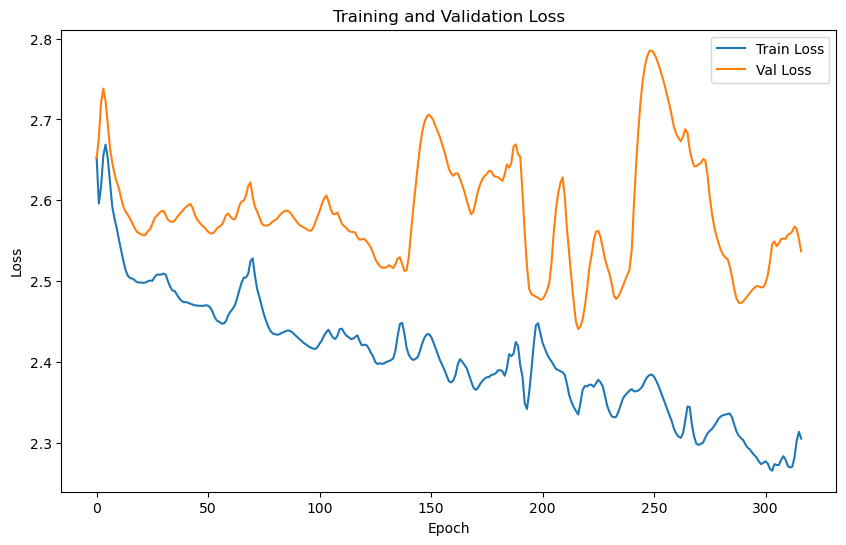

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.5401 | Test Accuracy: 17.06%


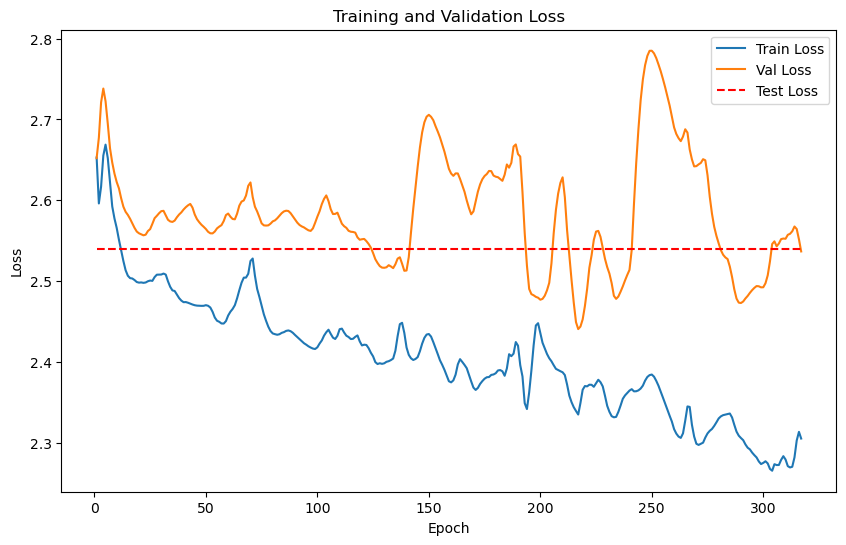

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)


Train embeddings shape: (65, 64), 
Train labels shape: (65,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5081, 64), 
Test labels shape: (5081,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}
Training batch size: 65


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.6358
Epoch [1/2000], Avg Train Loss: 8.6358
Epoch [1/2000], Avg Val Loss: 4.9038
Validation loss improved from inf to 4.9038. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.7462
Epoch [2/2000], Avg Train Loss: 8.7462
Epoch [2/2000], Avg Val Loss: 4.8782
Validation loss improved from 4.9038 to 4.8782. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.3070
Epoch [3/2000], Avg Train Loss: 8.3070
Epoch [3/2000], Avg Val Loss: 4.8536
Validation loss improved from 4.8782 to 4.8536. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.2125
Epoch [4/2000], Avg Train Loss: 8.2125
Epoch [4/2000], Avg Val Loss: 4.8296
Validation loss improved from 4.8536 to 4.8296. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.2515
Epoch [5/2000], Avg Train Loss: 8.2515
Epoch [5/2000], Avg Val Loss: 4.8060
Validation loss improved from 4.8296 to 4.8060. Saving mode

    Batch [1/1], Train Loss: 7.0197
Epoch [20/2000], Avg Train Loss: 7.0197
Epoch [20/2000], Avg Val Loss: 4.5138
Validation loss improved from 4.5305 to 4.5138. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.0476
Epoch [21/2000], Avg Train Loss: 7.0476
Epoch [21/2000], Avg Val Loss: 4.4976
Validation loss improved from 4.5138 to 4.4976. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.9369
Epoch [22/2000], Avg Train Loss: 6.9369
Epoch [22/2000], Avg Val Loss: 4.4816
Validation loss improved from 4.4976 to 4.4816. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.2328
Epoch [23/2000], Avg Train Loss: 7.2328
Epoch [23/2000], Avg Val Loss: 4.4660
Validation loss improved from 4.4816 to 4.4660. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.7427
Epoch [24/2000], Avg Train Loss: 6.7427
Epoch [24/2000], Avg Val Loss: 4.4506
Validation loss improved from 4.4660 to 4.

Epoch [31/2000], Avg Val Loss: 4.3497
Validation loss improved from 4.3634 to 4.3497. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.2908
Epoch [32/2000], Avg Train Loss: 6.2908
Epoch [32/2000], Avg Val Loss: 4.3363
Validation loss improved from 4.3497 to 4.3363. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.4556
Epoch [33/2000], Avg Train Loss: 6.4556
Epoch [33/2000], Avg Val Loss: 4.3229
Validation loss improved from 4.3363 to 4.3229. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.4814
Epoch [34/2000], Avg Train Loss: 6.4814
Epoch [34/2000], Avg Val Loss: 4.3096
Validation loss improved from 4.3229 to 4.3096. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.4233
Epoch [35/2000], Avg Train Loss: 6.4233
Epoch [35/2000], Avg Val Loss: 4.2966
Validation loss improved from 4.3096 to 4.2966. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.8084
Epoch [51/2000], Avg Train Loss: 5.8084
Epoch [51/2000], Avg Val Loss: 4.1162
Validation loss improved from 4.1260 to 4.1162. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.8441
Epoch [52/2000], Avg Train Loss: 5.8441
Epoch [52/2000], Avg Val Loss: 4.1067
Validation loss improved from 4.1162 to 4.1067. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.6209
Epoch [53/2000], Avg Train Loss: 5.6209
Epoch [53/2000], Avg Val Loss: 4.0975
Validation loss improved from 4.1067 to 4.0975. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.6465
Epoch [54/2000], Avg Train Loss: 5.6465
Epoch [54/2000], Avg Val Loss: 4.0885
Validation loss improved from 4.0975 to 4.0885. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.6333
Epoch [55/2000], Avg Train Loss: 5.6333
Epoch [55/2000], Avg Val Loss: 4.0798
Validation loss improved from 4.0885 to 4.

Epoch [70/2000], Avg Val Loss: 3.9684
Validation loss improved from 3.9746 to 3.9684. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.4292
Epoch [71/2000], Avg Train Loss: 5.4292
Epoch [71/2000], Avg Val Loss: 3.9623
Validation loss improved from 3.9684 to 3.9623. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.1868
Epoch [72/2000], Avg Train Loss: 5.1868
Epoch [72/2000], Avg Val Loss: 3.9564
Validation loss improved from 3.9623 to 3.9564. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.2248
Epoch [73/2000], Avg Train Loss: 5.2248
Epoch [73/2000], Avg Val Loss: 3.9507
Validation loss improved from 3.9564 to 3.9507. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.0055
Epoch [74/2000], Avg Train Loss: 5.0055
Epoch [74/2000], Avg Val Loss: 3.9452
Validation loss improved from 3.9507 to 3.9452. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.0767
Epoch [78/2000], Avg Train Loss: 5.0767
Epoch [78/2000], Avg Val Loss: 3.9247
Validation loss improved from 3.9296 to 3.9247. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 5.0009
Epoch [79/2000], Avg Train Loss: 5.0009
Epoch [79/2000], Avg Val Loss: 3.9199
Validation loss improved from 3.9247 to 3.9199. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 4.9294
Epoch [80/2000], Avg Train Loss: 4.9294
Epoch [80/2000], Avg Val Loss: 3.9154
Validation loss improved from 3.9199 to 3.9154. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.0426
Epoch [81/2000], Avg Train Loss: 5.0426
Epoch [81/2000], Avg Val Loss: 3.9111
Validation loss improved from 3.9154 to 3.9111. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 5.0233
Epoch [82/2000], Avg Train Loss: 5.0233
Epoch [82/2000], Avg Val Loss: 3.9069
Validation loss improved from 3.9111 to 3.

Epoch [100/2000], Avg Val Loss: 3.8468
Validation loss improved from 3.8495 to 3.8468. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 4.7422
Epoch [101/2000], Avg Train Loss: 4.7422
Epoch [101/2000], Avg Val Loss: 3.8443
Validation loss improved from 3.8468 to 3.8443. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 4.6908
Epoch [102/2000], Avg Train Loss: 4.6908
Epoch [102/2000], Avg Val Loss: 3.8418
Validation loss improved from 3.8443 to 3.8418. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 4.7165
Epoch [103/2000], Avg Train Loss: 4.7165
Epoch [103/2000], Avg Val Loss: 3.8395
Validation loss improved from 3.8418 to 3.8395. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 4.5698
Epoch [104/2000], Avg Train Loss: 4.5698
Epoch [104/2000], Avg Val Loss: 3.8372
Validation loss improved from 3.8395 to 3.8372. Saving model...

LOG: Epoch [105/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3068
Epoch [124/2000], Avg Train Loss: 4.3068
Epoch [124/2000], Avg Val Loss: 3.8014
Validation loss improved from 3.8028 to 3.8014. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 4.4860
Epoch [125/2000], Avg Train Loss: 4.4860
Epoch [125/2000], Avg Val Loss: 3.7999
Validation loss improved from 3.8014 to 3.7999. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.4360
Epoch [126/2000], Avg Train Loss: 4.4360
Epoch [126/2000], Avg Val Loss: 3.7985
Validation loss improved from 3.7999 to 3.7985. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.4331
Epoch [127/2000], Avg Train Loss: 4.4331
Epoch [127/2000], Avg Val Loss: 3.7970
Validation loss improved from 3.7985 to 3.7970. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.4441
Epoch [128/2000], Avg Train Loss: 4.4441
Epoch [128/2000], Avg Val Loss: 3.7956
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2440
Epoch [154/2000], Avg Train Loss: 4.2440
Epoch [154/2000], Avg Val Loss: 3.7600
Validation loss improved from 3.7612 to 3.7600. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.2479
Epoch [155/2000], Avg Train Loss: 4.2479
Epoch [155/2000], Avg Val Loss: 3.7588
Validation loss improved from 3.7600 to 3.7588. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.2649
Epoch [156/2000], Avg Train Loss: 4.2649
Epoch [156/2000], Avg Val Loss: 3.7576
Validation loss improved from 3.7588 to 3.7576. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.2385
Epoch [157/2000], Avg Train Loss: 4.2385
Epoch [157/2000], Avg Val Loss: 3.7564
Validation loss improved from 3.7576 to 3.7564. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.1949
Epoch [158/2000], Avg Train Loss: 4.1949
Epoch [158/2000], Avg Val Loss: 3.7552
Validation loss improved fro

Epoch [174/2000], Avg Val Loss: 3.7360
Validation loss improved from 3.7371 to 3.7360. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.1450
Epoch [175/2000], Avg Train Loss: 4.1450
Epoch [175/2000], Avg Val Loss: 3.7348
Validation loss improved from 3.7360 to 3.7348. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.2173
Epoch [176/2000], Avg Train Loss: 4.2173
Epoch [176/2000], Avg Val Loss: 3.7337
Validation loss improved from 3.7348 to 3.7337. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.1651
Epoch [177/2000], Avg Train Loss: 4.1651
Epoch [177/2000], Avg Val Loss: 3.7327
Validation loss improved from 3.7337 to 3.7327. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.0569
Epoch [178/2000], Avg Train Loss: 4.0569
Epoch [178/2000], Avg Val Loss: 3.7316
Validation loss improved from 3.7327 to 3.7316. Saving model...

LOG: Epoch [179/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0477
Epoch [210/2000], Avg Train Loss: 4.0477
Epoch [210/2000], Avg Val Loss: 3.6964
Validation loss improved from 3.6975 to 3.6964. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 4.1595
Epoch [211/2000], Avg Train Loss: 4.1595
Epoch [211/2000], Avg Val Loss: 3.6954
Validation loss improved from 3.6964 to 3.6954. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 4.0298
Epoch [212/2000], Avg Train Loss: 4.0298
Epoch [212/2000], Avg Val Loss: 3.6944
Validation loss improved from 3.6954 to 3.6944. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 4.0723
Epoch [213/2000], Avg Train Loss: 4.0723
Epoch [213/2000], Avg Val Loss: 3.6934
Validation loss improved from 3.6944 to 3.6934. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 4.0635
Epoch [214/2000], Avg Train Loss: 4.0635
Epoch [214/2000], Avg Val Loss: 3.6924
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9776
Epoch [228/2000], Avg Train Loss: 3.9776
Epoch [228/2000], Avg Val Loss: 3.6787
Validation loss improved from 3.6796 to 3.6787. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 4.0216
Epoch [229/2000], Avg Train Loss: 4.0216
Epoch [229/2000], Avg Val Loss: 3.6777
Validation loss improved from 3.6787 to 3.6777. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 4.0906
Epoch [230/2000], Avg Train Loss: 4.0906
Epoch [230/2000], Avg Val Loss: 3.6768
Validation loss improved from 3.6777 to 3.6768. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 3.9991
Epoch [231/2000], Avg Train Loss: 3.9991
Epoch [231/2000], Avg Val Loss: 3.6758
Validation loss improved from 3.6768 to 3.6758. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 3.9909
Epoch [232/2000], Avg Train Loss: 3.9909
Epoch [232/2000], Avg Val Loss: 3.6749
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9132
Epoch [260/2000], Avg Train Loss: 3.9132
Epoch [260/2000], Avg Val Loss: 3.6534
Validation loss improved from 3.6540 to 3.6534. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 3.9112
Epoch [261/2000], Avg Train Loss: 3.9112
Epoch [261/2000], Avg Val Loss: 3.6527
Validation loss improved from 3.6534 to 3.6527. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.0281
Epoch [262/2000], Avg Train Loss: 4.0281
Epoch [262/2000], Avg Val Loss: 3.6520
Validation loss improved from 3.6527 to 3.6520. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 3.9161
Epoch [263/2000], Avg Train Loss: 3.9161
Epoch [263/2000], Avg Val Loss: 3.6514
Validation loss improved from 3.6520 to 3.6514. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 3.9882
Epoch [264/2000], Avg Train Loss: 3.9882
Epoch [264/2000], Avg Val Loss: 3.6508
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8716
Epoch [277/2000], Avg Train Loss: 3.8716
Epoch [277/2000], Avg Val Loss: 3.6436
Validation loss improved from 3.6441 to 3.6436. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 3.8972
Epoch [278/2000], Avg Train Loss: 3.8972
Epoch [278/2000], Avg Val Loss: 3.6430
Validation loss improved from 3.6436 to 3.6430. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 3.9503
Epoch [279/2000], Avg Train Loss: 3.9503
Epoch [279/2000], Avg Val Loss: 3.6425
Validation loss improved from 3.6430 to 3.6425. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 3.8414
Epoch [280/2000], Avg Train Loss: 3.8414
Epoch [280/2000], Avg Val Loss: 3.6420
Validation loss improved from 3.6425 to 3.6420. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 3.9107
Epoch [281/2000], Avg Train Loss: 3.9107
Epoch [281/2000], Avg Val Loss: 3.6415
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8281
Epoch [308/2000], Avg Train Loss: 3.8281
Epoch [308/2000], Avg Val Loss: 3.6297
Validation loss improved from 3.6300 to 3.6297. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 3.8243
Epoch [309/2000], Avg Train Loss: 3.8243
Epoch [309/2000], Avg Val Loss: 3.6293
Validation loss improved from 3.6297 to 3.6293. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 3.8936
Epoch [310/2000], Avg Train Loss: 3.8936
Epoch [310/2000], Avg Val Loss: 3.6290
Validation loss improved from 3.6293 to 3.6290. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 3.8157
Epoch [311/2000], Avg Train Loss: 3.8157
Epoch [311/2000], Avg Val Loss: 3.6286
Validation loss improved from 3.6290 to 3.6286. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 3.8234
Epoch [312/2000], Avg Train Loss: 3.8234
Epoch [312/2000], Avg Val Loss: 3.6283
Validation loss improved fro

Epoch [326/2000], Avg Val Loss: 3.6244
Validation loss improved from 3.6247 to 3.6244. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.8695
Epoch [327/2000], Avg Train Loss: 3.8695
Epoch [327/2000], Avg Val Loss: 3.6241
Validation loss improved from 3.6244 to 3.6241. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 3.7711
Epoch [328/2000], Avg Train Loss: 3.7711
Epoch [328/2000], Avg Val Loss: 3.6237
Validation loss improved from 3.6241 to 3.6237. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 3.7944
Epoch [329/2000], Avg Train Loss: 3.7944
Epoch [329/2000], Avg Val Loss: 3.6234
Validation loss improved from 3.6237 to 3.6234. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 3.8294
Epoch [330/2000], Avg Train Loss: 3.8294
Epoch [330/2000], Avg Val Loss: 3.6231
Validation loss improved from 3.6234 to 3.6231. Saving model...

LOG: Epoch [331/2000] - Training
    Bat

Epoch [355/2000], Avg Val Loss: 3.6172
Validation loss improved from 3.6174 to 3.6172. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 3.7336
Epoch [356/2000], Avg Train Loss: 3.7336
Epoch [356/2000], Avg Val Loss: 3.6171
Validation loss improved from 3.6172 to 3.6171. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 3.7221
Epoch [357/2000], Avg Train Loss: 3.7221
Epoch [357/2000], Avg Val Loss: 3.6169
Validation loss improved from 3.6171 to 3.6169. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 3.6838
Epoch [358/2000], Avg Train Loss: 3.6838
Epoch [358/2000], Avg Val Loss: 3.6168
Validation loss improved from 3.6169 to 3.6168. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 3.7561
Epoch [359/2000], Avg Train Loss: 3.7561
Epoch [359/2000], Avg Val Loss: 3.6166
Validation loss improved from 3.6168 to 3.6166. Saving model...

LOG: Epoch [360/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6881
Epoch [368/2000], Avg Train Loss: 3.6881
Epoch [368/2000], Avg Val Loss: 3.6156
Validation loss improved from 3.6157 to 3.6156. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 3.7674
Epoch [369/2000], Avg Train Loss: 3.7674
Epoch [369/2000], Avg Val Loss: 3.6155
Validation loss improved from 3.6156 to 3.6155. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 3.6616
Epoch [370/2000], Avg Train Loss: 3.6616
Epoch [370/2000], Avg Val Loss: 3.6154
Validation loss improved from 3.6155 to 3.6154. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 3.7400
Epoch [371/2000], Avg Train Loss: 3.7400
Epoch [371/2000], Avg Val Loss: 3.6153
Validation loss improved from 3.6154 to 3.6153. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 3.7167
Epoch [372/2000], Avg Train Loss: 3.7167
Epoch [372/2000], Avg Val Loss: 3.6152
Validation loss improved fro

Epoch [403/2000], Avg Val Loss: 3.6101
Validation loss improved from 3.6103 to 3.6101. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 3.7269
Epoch [404/2000], Avg Train Loss: 3.7269
Epoch [404/2000], Avg Val Loss: 3.6100
Validation loss improved from 3.6101 to 3.6100. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 3.6998
Epoch [405/2000], Avg Train Loss: 3.6998
Epoch [405/2000], Avg Val Loss: 3.6099
Validation loss improved from 3.6100 to 3.6099. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 3.6288
Epoch [406/2000], Avg Train Loss: 3.6288
Epoch [406/2000], Avg Val Loss: 3.6097
Validation loss improved from 3.6099 to 3.6097. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 3.6513
Epoch [407/2000], Avg Train Loss: 3.6513
Epoch [407/2000], Avg Val Loss: 3.6096
Validation loss improved from 3.6097 to 3.6096. Saving model...

LOG: Epoch [408/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5874
Epoch [421/2000], Avg Train Loss: 3.5874
Epoch [421/2000], Avg Val Loss: 3.6088
Validation loss improved from 3.6088 to 3.6088. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 3.7047
Epoch [422/2000], Avg Train Loss: 3.7047
Epoch [422/2000], Avg Val Loss: 3.6088
Validation loss did not improve. Patience: 1/100

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 3.6170
Epoch [423/2000], Avg Train Loss: 3.6170
Epoch [423/2000], Avg Val Loss: 3.6087
Validation loss improved from 3.6088 to 3.6087. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 3.6248
Epoch [424/2000], Avg Train Loss: 3.6248
Epoch [424/2000], Avg Val Loss: 3.6087
Validation loss improved from 3.6087 to 3.6087. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 3.6698
Epoch [425/2000], Avg Train Loss: 3.6698
Epoch [425/2000], Avg Val Loss: 3.6087
Validation loss did not improve. Patience: 

    Batch [1/1], Train Loss: 3.5709
Epoch [449/2000], Avg Train Loss: 3.5709
Epoch [449/2000], Avg Val Loss: 3.6085
Validation loss did not improve. Patience: 8/100

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 3.6448
Epoch [450/2000], Avg Train Loss: 3.6448
Epoch [450/2000], Avg Val Loss: 3.6085
Validation loss did not improve. Patience: 9/100

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 3.6585
Epoch [451/2000], Avg Train Loss: 3.6585
Epoch [451/2000], Avg Val Loss: 3.6084
Validation loss improved from 3.6084 to 3.6084. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 3.5745
Epoch [452/2000], Avg Train Loss: 3.5745
Epoch [452/2000], Avg Val Loss: 3.6083
Validation loss improved from 3.6084 to 3.6083. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 3.5051
Epoch [453/2000], Avg Train Loss: 3.5051
Epoch [453/2000], Avg Val Loss: 3.6082
Validation loss improved from 3.6083 to 3.6082. Saving mod

    Batch [1/1], Train Loss: 3.5787
Epoch [470/2000], Avg Train Loss: 3.5787
Epoch [470/2000], Avg Val Loss: 3.6077
Validation loss improved from 3.6079 to 3.6077. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 3.4610
Epoch [471/2000], Avg Train Loss: 3.4610
Epoch [471/2000], Avg Val Loss: 3.6075
Validation loss improved from 3.6077 to 3.6075. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 3.6214
Epoch [472/2000], Avg Train Loss: 3.6214
Epoch [472/2000], Avg Val Loss: 3.6073
Validation loss improved from 3.6075 to 3.6073. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 3.5591
Epoch [473/2000], Avg Train Loss: 3.5591
Epoch [473/2000], Avg Val Loss: 3.6072
Validation loss improved from 3.6073 to 3.6072. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 3.5737
Epoch [474/2000], Avg Train Loss: 3.5737
Epoch [474/2000], Avg Val Loss: 3.6070
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5328
Epoch [501/2000], Avg Train Loss: 3.5328
Epoch [501/2000], Avg Val Loss: 3.6033
Validation loss improved from 3.6034 to 3.6033. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 3.4704
Epoch [502/2000], Avg Train Loss: 3.4704
Epoch [502/2000], Avg Val Loss: 3.6033
Validation loss improved from 3.6033 to 3.6033. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 3.5403
Epoch [503/2000], Avg Train Loss: 3.5403
Epoch [503/2000], Avg Val Loss: 3.6033
Validation loss did not improve. Patience: 1/100

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 3.5968
Epoch [504/2000], Avg Train Loss: 3.5968
Epoch [504/2000], Avg Val Loss: 3.6033
Validation loss did not improve. Patience: 2/100

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 3.5505
Epoch [505/2000], Avg Train Loss: 3.5505
Epoch [505/2000], Avg Val Loss: 3.6033
Validation loss did not improve. Patience: 3/100

LOG: Epo

    Batch [1/1], Train Loss: 3.4774
Epoch [522/2000], Avg Train Loss: 3.4774
Epoch [522/2000], Avg Val Loss: 3.6040
Validation loss did not improve. Patience: 20/100

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 3.4882
Epoch [523/2000], Avg Train Loss: 3.4882
Epoch [523/2000], Avg Val Loss: 3.6039
Validation loss did not improve. Patience: 21/100

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 3.4886
Epoch [524/2000], Avg Train Loss: 3.4886
Epoch [524/2000], Avg Val Loss: 3.6040
Validation loss did not improve. Patience: 22/100

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 3.5687
Epoch [525/2000], Avg Train Loss: 3.5687
Epoch [525/2000], Avg Val Loss: 3.6040
Validation loss did not improve. Patience: 23/100

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 3.4589
Epoch [526/2000], Avg Train Loss: 3.4589
Epoch [526/2000], Avg Val Loss: 3.6040
Validation loss did not improve. Patience: 24/100

LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 3.5084
Epoch [553/2000], Avg Train Loss: 3.5084
Epoch [553/2000], Avg Val Loss: 3.6027
Validation loss did not improve. Patience: 2/100

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 3.4281
Epoch [554/2000], Avg Train Loss: 3.4281
Epoch [554/2000], Avg Val Loss: 3.6027
Validation loss did not improve. Patience: 3/100

LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 3.5473
Epoch [555/2000], Avg Train Loss: 3.5473
Epoch [555/2000], Avg Val Loss: 3.6028
Validation loss did not improve. Patience: 4/100

LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 3.3995
Epoch [556/2000], Avg Train Loss: 3.3995
Epoch [556/2000], Avg Val Loss: 3.6028
Validation loss did not improve. Patience: 5/100

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 3.5336
Epoch [557/2000], Avg Train Loss: 3.5336
Epoch [557/2000], Avg Val Loss: 3.6028
Validation loss did not improve. Patience: 6/100

LOG: Epoch [558/2000] - Training
    B

Epoch [575/2000], Avg Val Loss: 3.6028
Validation loss did not improve. Patience: 5/100

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 3.4195
Epoch [576/2000], Avg Train Loss: 3.4195
Epoch [576/2000], Avg Val Loss: 3.6029
Validation loss did not improve. Patience: 6/100

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 3.5387
Epoch [577/2000], Avg Train Loss: 3.5387
Epoch [577/2000], Avg Val Loss: 3.6031
Validation loss did not improve. Patience: 7/100

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 3.4354
Epoch [578/2000], Avg Train Loss: 3.4354
Epoch [578/2000], Avg Val Loss: 3.6031
Validation loss did not improve. Patience: 8/100

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 3.4445
Epoch [579/2000], Avg Train Loss: 3.4445
Epoch [579/2000], Avg Val Loss: 3.6031
Validation loss did not improve. Patience: 9/100

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 3.3537
Epoch [580/2000], Avg Train Loss: 3.3537
Epoch

    Batch [1/1], Train Loss: 3.4958
Epoch [599/2000], Avg Train Loss: 3.4958
Epoch [599/2000], Avg Val Loss: 3.6041
Validation loss did not improve. Patience: 29/100

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 3.3833
Epoch [600/2000], Avg Train Loss: 3.3833
Epoch [600/2000], Avg Val Loss: 3.6042
Validation loss did not improve. Patience: 30/100

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 3.3473
Epoch [601/2000], Avg Train Loss: 3.3473
Epoch [601/2000], Avg Val Loss: 3.6043
Validation loss did not improve. Patience: 31/100

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 3.4016
Epoch [602/2000], Avg Train Loss: 3.4016
Epoch [602/2000], Avg Val Loss: 3.6045
Validation loss did not improve. Patience: 32/100

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 3.4109
Epoch [603/2000], Avg Train Loss: 3.4109
Epoch [603/2000], Avg Val Loss: 3.6046
Validation loss did not improve. Patience: 33/100

LOG: Epoch [604/2000] - Training


Epoch [620/2000], Avg Val Loss: 3.6024
Validation loss did not improve. Patience: 50/100

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 3.3509
Epoch [621/2000], Avg Train Loss: 3.3509
Epoch [621/2000], Avg Val Loss: 3.6023
Validation loss did not improve. Patience: 51/100

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 3.4283
Epoch [622/2000], Avg Train Loss: 3.4283
Epoch [622/2000], Avg Val Loss: 3.6022
Validation loss did not improve. Patience: 52/100

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 3.3320
Epoch [623/2000], Avg Train Loss: 3.3320
Epoch [623/2000], Avg Val Loss: 3.6021
Validation loss did not improve. Patience: 53/100

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 3.3345
Epoch [624/2000], Avg Train Loss: 3.3345
Epoch [624/2000], Avg Val Loss: 3.6020
Validation loss did not improve. Patience: 54/100

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 3.4383
Epoch [625/2000], Avg Train Loss: 3.4383


    Batch [1/1], Train Loss: 3.3990
Epoch [647/2000], Avg Train Loss: 3.3990
Epoch [647/2000], Avg Val Loss: 3.6018
Validation loss did not improve. Patience: 10/100

LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 3.3680
Epoch [648/2000], Avg Train Loss: 3.3680
Epoch [648/2000], Avg Val Loss: 3.6020
Validation loss did not improve. Patience: 11/100

LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 3.3565
Epoch [649/2000], Avg Train Loss: 3.3565
Epoch [649/2000], Avg Val Loss: 3.6022
Validation loss did not improve. Patience: 12/100

LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 3.4175
Epoch [650/2000], Avg Train Loss: 3.4175
Epoch [650/2000], Avg Val Loss: 3.6022
Validation loss did not improve. Patience: 13/100

LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 3.3331
Epoch [651/2000], Avg Train Loss: 3.3331
Epoch [651/2000], Avg Val Loss: 3.6022
Validation loss did not improve. Patience: 14/100

LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 3.3278
Epoch [674/2000], Avg Train Loss: 3.3278
Epoch [674/2000], Avg Val Loss: 3.6055
Validation loss did not improve. Patience: 37/100

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 3.3262
Epoch [675/2000], Avg Train Loss: 3.3262
Epoch [675/2000], Avg Val Loss: 3.6058
Validation loss did not improve. Patience: 38/100

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 3.3016
Epoch [676/2000], Avg Train Loss: 3.3016
Epoch [676/2000], Avg Val Loss: 3.6063
Validation loss did not improve. Patience: 39/100

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 3.3270
Epoch [677/2000], Avg Train Loss: 3.3270
Epoch [677/2000], Avg Val Loss: 3.6065
Validation loss did not improve. Patience: 40/100

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 3.2878
Epoch [678/2000], Avg Train Loss: 3.2878
Epoch [678/2000], Avg Val Loss: 3.6068
Validation loss did not improve. Patience: 41/100

LOG: Epoch [679/2000] - Training


Epoch [702/2000], Avg Val Loss: 3.6091
Validation loss did not improve. Patience: 65/100

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 3.2781
Epoch [703/2000], Avg Train Loss: 3.2781
Epoch [703/2000], Avg Val Loss: 3.6093
Validation loss did not improve. Patience: 66/100

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 3.1865
Epoch [704/2000], Avg Train Loss: 3.1865
Epoch [704/2000], Avg Val Loss: 3.6095
Validation loss did not improve. Patience: 67/100

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 3.2794
Epoch [705/2000], Avg Train Loss: 3.2794
Epoch [705/2000], Avg Val Loss: 3.6097
Validation loss did not improve. Patience: 68/100

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 3.2498
Epoch [706/2000], Avg Train Loss: 3.2498
Epoch [706/2000], Avg Val Loss: 3.6100
Validation loss did not improve. Patience: 69/100

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 3.2881
Epoch [707/2000], Avg Train Loss: 3.2881


Epoch [726/2000], Avg Val Loss: 3.6162
Validation loss did not improve. Patience: 89/100

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 3.2142
Epoch [727/2000], Avg Train Loss: 3.2142
Epoch [727/2000], Avg Val Loss: 3.6164
Validation loss did not improve. Patience: 90/100

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 3.1549
Epoch [728/2000], Avg Train Loss: 3.1549
Epoch [728/2000], Avg Val Loss: 3.6166
Validation loss did not improve. Patience: 91/100

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 3.2401
Epoch [729/2000], Avg Train Loss: 3.2401
Epoch [729/2000], Avg Val Loss: 3.6167
Validation loss did not improve. Patience: 92/100

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 3.2573
Epoch [730/2000], Avg Train Loss: 3.2573
Epoch [730/2000], Avg Val Loss: 3.6166
Validation loss did not improve. Patience: 93/100

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 3.2538
Epoch [731/2000], Avg Train Loss: 3.2538


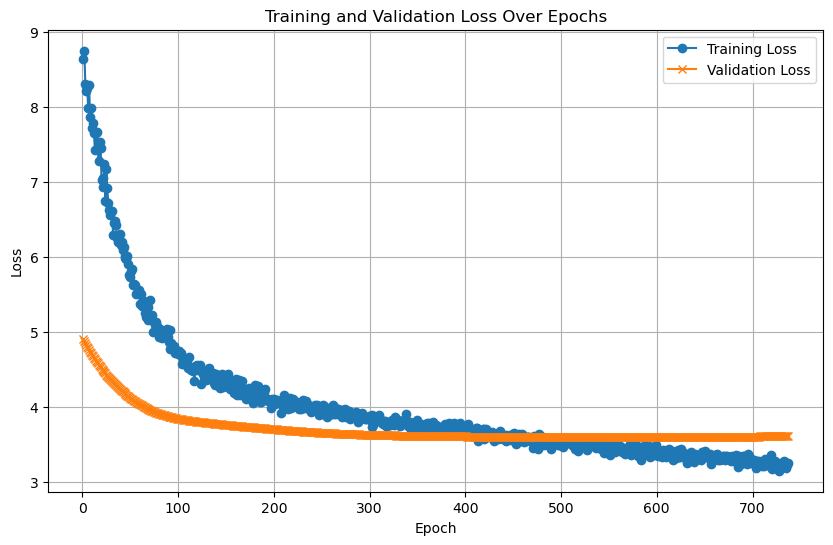

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 4.7787
Test Batch [20/20], Loss: 4.9075

Test Loss: 4.7579


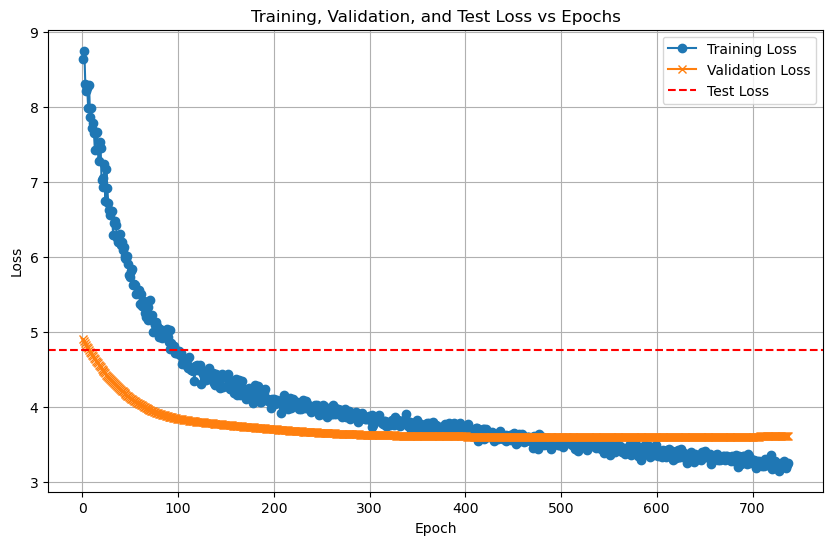

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 36.92%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.00      0.00      0.00         5
           2       0.29      0.40      0.33         5
           3       0.00      0.00      0.00         5
           4       0.33      0.80      0.47         5
           5       0.33      0.40      0.36         5
           6       0.00      0.00      0.00         5
           7       0.20      0.20      0.20         5
           8       0.33      0.60      0.43         5
           9       0.00      0.00      0.00         5
          10       0.80      0.80      0.80         5
          11       0.43      0.60      0.50         5
          12       0.80      0.80      0.80         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6374  |  Val Loss: 2.6432
Validation loss improved from inf to 2.6432.
[Epoch 2/1000] Train Loss: 2.6265  |  Val Loss: 2.6361
Validation loss improved from 2.6432 to 2.6361.
[Epoch 3/1000] Train Loss: 2.6179  |  Val Loss: 2.6297
Validation loss improved from 2.6361 to 2.6297.
[Epoch 4/1000] Train Loss: 2.6101  |  Val Loss: 2.6234
Validation loss improved from 2.6297 to 2.6234.
[Epoch 5/1000] Train Loss: 2.6025  |  Val Loss: 2.6188
Validation loss improved from 2.6234 to 2.6188.
[Epoch 6/1000] Train Loss: 2.5963  |  Val Loss: 2.6156
Validation loss improved from 2.6188 to 2.6156.
[Epoch 7/1000] Train Loss: 2.5915  |  Val Loss: 2.6115
Validation loss improved from 2.6156 to 2.6115.
[Epoch 8/1000] Train Loss: 2.5864  |  Val Loss: 2.6068
Validation loss improved from 2.6115 to 2.6068.
[Epoch 9/1000] Train Loss: 2.5809  |  Val Loss: 2.6021
Validation loss improved from 2.6068 to 2.6021.
[Epoch 10/1000] Train Loss: 2.5754  |  Val Loss: 2.5976
Validation loss impr

[Epoch 26/1000] Train Loss: 2.5154  |  Val Loss: 2.5562
Validation loss improved from 2.5573 to 2.5562.
[Epoch 27/1000] Train Loss: 2.5129  |  Val Loss: 2.5550
Validation loss improved from 2.5562 to 2.5550.
[Epoch 28/1000] Train Loss: 2.5106  |  Val Loss: 2.5535
Validation loss improved from 2.5550 to 2.5535.
[Epoch 29/1000] Train Loss: 2.5081  |  Val Loss: 2.5519
Validation loss improved from 2.5535 to 2.5519.
[Epoch 30/1000] Train Loss: 2.5057  |  Val Loss: 2.5502
Validation loss improved from 2.5519 to 2.5502.
[Epoch 31/1000] Train Loss: 2.5032  |  Val Loss: 2.5486
Validation loss improved from 2.5502 to 2.5486.
[Epoch 32/1000] Train Loss: 2.5007  |  Val Loss: 2.5470
Validation loss improved from 2.5486 to 2.5470.
[Epoch 33/1000] Train Loss: 2.4983  |  Val Loss: 2.5455
Validation loss improved from 2.5470 to 2.5455.
[Epoch 34/1000] Train Loss: 2.4959  |  Val Loss: 2.5438
Validation loss improved from 2.5455 to 2.5438.
[Epoch 35/1000] Train Loss: 2.4935  |  Val Loss: 2.5420
Validati

[Epoch 38/1000] Train Loss: 2.4865  |  Val Loss: 2.5362
Validation loss improved from 2.5382 to 2.5362.
[Epoch 39/1000] Train Loss: 2.4840  |  Val Loss: 2.5343
Validation loss improved from 2.5362 to 2.5343.
[Epoch 40/1000] Train Loss: 2.4814  |  Val Loss: 2.5328
Validation loss improved from 2.5343 to 2.5328.
[Epoch 41/1000] Train Loss: 2.4790  |  Val Loss: 2.5313
Validation loss improved from 2.5328 to 2.5313.
[Epoch 42/1000] Train Loss: 2.4768  |  Val Loss: 2.5298
Validation loss improved from 2.5313 to 2.5298.
[Epoch 43/1000] Train Loss: 2.4747  |  Val Loss: 2.5284
Validation loss improved from 2.5298 to 2.5284.
[Epoch 44/1000] Train Loss: 2.4727  |  Val Loss: 2.5274
Validation loss improved from 2.5284 to 2.5274.
[Epoch 45/1000] Train Loss: 2.4708  |  Val Loss: 2.5266
Validation loss improved from 2.5274 to 2.5266.
[Epoch 46/1000] Train Loss: 2.4690  |  Val Loss: 2.5256
Validation loss improved from 2.5266 to 2.5256.
[Epoch 47/1000] Train Loss: 2.4671  |  Val Loss: 2.5245
Validati

[Epoch 68/1000] Train Loss: 2.4214  |  Val Loss: 2.4929
Validation loss improved from 2.4935 to 2.4929.
[Epoch 69/1000] Train Loss: 2.4190  |  Val Loss: 2.4922
Validation loss improved from 2.4929 to 2.4922.
[Epoch 70/1000] Train Loss: 2.4168  |  Val Loss: 2.4915
Validation loss improved from 2.4922 to 2.4915.
[Epoch 71/1000] Train Loss: 2.4149  |  Val Loss: 2.4908
Validation loss improved from 2.4915 to 2.4908.
[Epoch 72/1000] Train Loss: 2.4132  |  Val Loss: 2.4902
Validation loss improved from 2.4908 to 2.4902.
[Epoch 73/1000] Train Loss: 2.4117  |  Val Loss: 2.4896
Validation loss improved from 2.4902 to 2.4896.
[Epoch 74/1000] Train Loss: 2.4102  |  Val Loss: 2.4890
Validation loss improved from 2.4896 to 2.4890.
[Epoch 75/1000] Train Loss: 2.4089  |  Val Loss: 2.4883
Validation loss improved from 2.4890 to 2.4883.
[Epoch 76/1000] Train Loss: 2.4074  |  Val Loss: 2.4875
Validation loss improved from 2.4883 to 2.4875.
[Epoch 77/1000] Train Loss: 2.4058  |  Val Loss: 2.4867
Validati

[Epoch 81/1000] Train Loss: 2.4000  |  Val Loss: 2.4864
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 82/1000] Train Loss: 2.3983  |  Val Loss: 2.4867
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 83/1000] Train Loss: 2.3966  |  Val Loss: 2.4871
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 84/1000] Train Loss: 2.3952  |  Val Loss: 2.4871
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 85/1000] Train Loss: 2.3938  |  Val Loss: 2.4855
Validation loss improved from 2.4859 to 2.4855.
[Epoch 86/1000] Train Loss: 2.3920  |  Val Loss: 2.4825
Validation loss improved from 2.4855 to 2.4825.
[Epoch 87/1000] Train Loss: 2.3902  |  Val Loss: 2.4796
Validation loss improved from 2.4825 to 2.4796.
[Epoch 88/1000] Train Loss: 2.3888  |  Val Loss: 2.4768
Validation loss improved from 2.4796 to 2.4768.
[Epoch 89/1000] Train Loss: 2.3875  |  Val Loss: 2.4744
Validation loss improved from 2.4768 to 2.4744.
[Epoch 90/1000] Train Loss: 2.3863  |  V

[Epoch 108/1000] Train Loss: 2.3611  |  Val Loss: 2.4615
Validation loss improved from 2.4617 to 2.4615.
[Epoch 109/1000] Train Loss: 2.3600  |  Val Loss: 2.4614
Validation loss improved from 2.4615 to 2.4614.
[Epoch 110/1000] Train Loss: 2.3588  |  Val Loss: 2.4612
Validation loss improved from 2.4614 to 2.4612.
[Epoch 111/1000] Train Loss: 2.3576  |  Val Loss: 2.4609
Validation loss improved from 2.4612 to 2.4609.
[Epoch 112/1000] Train Loss: 2.3564  |  Val Loss: 2.4608
Validation loss improved from 2.4609 to 2.4608.
[Epoch 113/1000] Train Loss: 2.3551  |  Val Loss: 2.4606
Validation loss improved from 2.4608 to 2.4606.
[Epoch 114/1000] Train Loss: 2.3539  |  Val Loss: 2.4603
Validation loss improved from 2.4606 to 2.4603.
[Epoch 115/1000] Train Loss: 2.3528  |  Val Loss: 2.4599
Validation loss improved from 2.4603 to 2.4599.
[Epoch 116/1000] Train Loss: 2.3518  |  Val Loss: 2.4595
Validation loss improved from 2.4599 to 2.4595.
[Epoch 117/1000] Train Loss: 2.3509  |  Val Loss: 2.459

[Epoch 118/1000] Train Loss: 2.3500  |  Val Loss: 2.4588
Validation loss improved from 2.4591 to 2.4588.
[Epoch 119/1000] Train Loss: 2.3492  |  Val Loss: 2.4586
Validation loss improved from 2.4588 to 2.4586.
[Epoch 120/1000] Train Loss: 2.3484  |  Val Loss: 2.4584
Validation loss improved from 2.4586 to 2.4584.
[Epoch 121/1000] Train Loss: 2.3475  |  Val Loss: 2.4581
Validation loss improved from 2.4584 to 2.4581.
[Epoch 122/1000] Train Loss: 2.3467  |  Val Loss: 2.4577
Validation loss improved from 2.4581 to 2.4577.
[Epoch 123/1000] Train Loss: 2.3459  |  Val Loss: 2.4573
Validation loss improved from 2.4577 to 2.4573.
[Epoch 124/1000] Train Loss: 2.3450  |  Val Loss: 2.4568
Validation loss improved from 2.4573 to 2.4568.
[Epoch 125/1000] Train Loss: 2.3441  |  Val Loss: 2.4568
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 126/1000] Train Loss: 2.3428  |  Val Loss: 2.4576
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 127/1000] Train Loss: 2.3416  |  Val

[Epoch 152/1000] Train Loss: 2.3158  |  Val Loss: 2.4395
Validation loss improved from 2.4402 to 2.4395.
[Epoch 153/1000] Train Loss: 2.3151  |  Val Loss: 2.4387
Validation loss improved from 2.4395 to 2.4387.
[Epoch 154/1000] Train Loss: 2.3143  |  Val Loss: 2.4379
Validation loss improved from 2.4387 to 2.4379.
[Epoch 155/1000] Train Loss: 2.3136  |  Val Loss: 2.4374
Validation loss improved from 2.4379 to 2.4374.
[Epoch 156/1000] Train Loss: 2.3129  |  Val Loss: 2.4369
Validation loss improved from 2.4374 to 2.4369.
[Epoch 157/1000] Train Loss: 2.3122  |  Val Loss: 2.4368
Validation loss improved from 2.4369 to 2.4368.
[Epoch 158/1000] Train Loss: 2.3115  |  Val Loss: 2.4367
Validation loss improved from 2.4368 to 2.4367.
[Epoch 159/1000] Train Loss: 2.3107  |  Val Loss: 2.4365
Validation loss improved from 2.4367 to 2.4365.
[Epoch 160/1000] Train Loss: 2.3100  |  Val Loss: 2.4365
Validation loss improved from 2.4365 to 2.4365.


[Epoch 161/1000] Train Loss: 2.3093  |  Val Loss: 2.4365
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 162/1000] Train Loss: 2.3086  |  Val Loss: 2.4364
Validation loss improved from 2.4365 to 2.4364.
[Epoch 163/1000] Train Loss: 2.3078  |  Val Loss: 2.4364
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 164/1000] Train Loss: 2.3069  |  Val Loss: 2.4361
Validation loss improved from 2.4364 to 2.4361.
[Epoch 165/1000] Train Loss: 2.3059  |  Val Loss: 2.4353
Validation loss improved from 2.4361 to 2.4353.
[Epoch 166/1000] Train Loss: 2.3048  |  Val Loss: 2.4349
Validation loss improved from 2.4353 to 2.4349.
[Epoch 167/1000] Train Loss: 2.3038  |  Val Loss: 2.4348
Validation loss improved from 2.4349 to 2.4348.
[Epoch 168/1000] Train Loss: 2.3029  |  Val Loss: 2.4345
Validation loss improved from 2.4348 to 2.4345.
[Epoch 169/1000] Train Loss: 2.3021  |  Val Loss: 2.4346
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 170/1000] Train Loss: 2.3011  

[Epoch 194/1000] Train Loss: 2.2767  |  Val Loss: 2.4343
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 195/1000] Train Loss: 2.2760  |  Val Loss: 2.4352
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 196/1000] Train Loss: 2.2754  |  Val Loss: 2.4358
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 197/1000] Train Loss: 2.2747  |  Val Loss: 2.4362
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 198/1000] Train Loss: 2.2741  |  Val Loss: 2.4362
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 199/1000] Train Loss: 2.2734  |  Val Loss: 2.4360
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 200/1000] Train Loss: 2.2727  |  Val Loss: 2.4356
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 201/1000] Train Loss: 2.2720  |  Val Loss: 2.4345
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 202/1000] Train Loss: 2.2711  |  Val Loss: 2.4328
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 203/1000] Train Loss: 2.2701  |  Val Loss: 2.4311
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 204/1000] Train Loss: 2.2692  |  Val Loss: 2.4296
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 205/1000] Train Loss: 2.2680  |  Val Loss: 2.4282
Validation loss improved from 2.4283 to 2.4282.
[Epoch 206/1000] Train Loss: 2.2668  |  Val Loss: 2.4269
Validation loss improved from 2.4282 to 2.4269.
[Epoch 207/1000] Train Loss: 2.2659  |  Val Loss: 2.4257
Validation loss improved from 2.4269 to 2.4257.
[Epoch 208/1000] Train Loss: 2.2651  |  Val Loss: 2.4246
Validation loss improved from 2.4257 to 2.4246.
[Epoch 209/1000] Train Loss: 2.2643  |  Val Loss: 2.4236
Validation loss improved from 2.4246 to 2.4236.
[Epoch 210/1000] Train Loss: 2.2636  |  Val Loss: 2.4228
Validation loss improved from 2.4236 to 2.4228.
[Epoch 211/1000] Train Loss: 2.262

[Epoch 234/1000] Train Loss: 2.2389  |  Val Loss: 2.4163
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 235/1000] Train Loss: 2.2380  |  Val Loss: 2.4183
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 236/1000] Train Loss: 2.2372  |  Val Loss: 2.4201
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 237/1000] Train Loss: 2.2363  |  Val Loss: 2.4213
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 238/1000] Train Loss: 2.2354  |  Val Loss: 2.4221
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 239/1000] Train Loss: 2.2347  |  Val Loss: 2.4226
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 240/1000] Train Loss: 2.2340  |  Val Loss: 2.4230
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 241/1000] Train Loss: 2.2333  |  Val Loss: 2.4234
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 242/1000] Train Loss: 2.2326  |  Val Loss: 2.4220
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 249/1000] Train Loss: 2.2251  |  Val Loss: 2.4104
Validation loss improved from 2.4116 to 2.4104.
[Epoch 250/1000] Train Loss: 2.2240  |  Val Loss: 2.4092
Validation loss improved from 2.4104 to 2.4092.
[Epoch 251/1000] Train Loss: 2.2229  |  Val Loss: 2.4083
Validation loss improved from 2.4092 to 2.4083.
[Epoch 252/1000] Train Loss: 2.2220  |  Val Loss: 2.4073
Validation loss improved from 2.4083 to 2.4073.
[Epoch 253/1000] Train Loss: 2.2209  |  Val Loss: 2.4065
Validation loss improved from 2.4073 to 2.4065.
[Epoch 254/1000] Train Loss: 2.2199  |  Val Loss: 2.4056
Validation loss improved from 2.4065 to 2.4056.
[Epoch 255/1000] Train Loss: 2.2190  |  Val Loss: 2.4046
Validation loss improved from 2.4056 to 2.4046.
[Epoch 256/1000] Train Loss: 2.2181  |  Val Loss: 2.4035
Validation loss improved from 2.4046 to 2.4035.
[Epoch 257/1000] Train Loss: 2.2172  |  Val Loss: 2.4024
Validation loss improved from 2.4035 to 2.4024.
[Epoch 258/1000] Train Loss: 2.2163  |  Val Loss: 2.401

[Epoch 279/1000] Train Loss: 2.1951  |  Val Loss: 2.3942
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 280/1000] Train Loss: 2.1943  |  Val Loss: 2.3940
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 281/1000] Train Loss: 2.1935  |  Val Loss: 2.3937
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 282/1000] Train Loss: 2.1926  |  Val Loss: 2.3943
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 283/1000] Train Loss: 2.1915  |  Val Loss: 2.3958
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 284/1000] Train Loss: 2.1904  |  Val Loss: 2.3970
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 285/1000] Train Loss: 2.1895  |  Val Loss: 2.3976
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 286/1000] Train Loss: 2.1886  |  Val Loss: 2.3976
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 287/1000] Train Loss: 2.1879  |  Val Loss: 2.3978
!! Validation loss did NOT improve !! Patience:

[Epoch 294/1000] Train Loss: 2.1805  |  Val Loss: 2.3911
Validation loss improved from 2.3935 to 2.3911.
[Epoch 295/1000] Train Loss: 2.1789  |  Val Loss: 2.3875
Validation loss improved from 2.3911 to 2.3875.
[Epoch 296/1000] Train Loss: 2.1774  |  Val Loss: 2.3842
Validation loss improved from 2.3875 to 2.3842.
[Epoch 297/1000] Train Loss: 2.1762  |  Val Loss: 2.3815
Validation loss improved from 2.3842 to 2.3815.
[Epoch 298/1000] Train Loss: 2.1751  |  Val Loss: 2.3795
Validation loss improved from 2.3815 to 2.3795.
[Epoch 299/1000] Train Loss: 2.1740  |  Val Loss: 2.3782
Validation loss improved from 2.3795 to 2.3782.
[Epoch 300/1000] Train Loss: 2.1729  |  Val Loss: 2.3772
Validation loss improved from 2.3782 to 2.3772.
[Epoch 301/1000] Train Loss: 2.1718  |  Val Loss: 2.3755
Validation loss improved from 2.3772 to 2.3755.
[Epoch 302/1000] Train Loss: 2.1709  |  Val Loss: 2.3736
Validation loss improved from 2.3755 to 2.3736.
[Epoch 303/1000] Train Loss: 2.1699  |  Val Loss: 2.372

[Epoch 318/1000] Train Loss: 2.1573  |  Val Loss: 2.3524
Validation loss improved from 2.3525 to 2.3524.
[Epoch 319/1000] Train Loss: 2.1563  |  Val Loss: 2.3525
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 320/1000] Train Loss: 2.1553  |  Val Loss: 2.3525
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 321/1000] Train Loss: 2.1541  |  Val Loss: 2.3523
Validation loss improved from 2.3524 to 2.3523.
[Epoch 322/1000] Train Loss: 2.1528  |  Val Loss: 2.3524
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 323/1000] Train Loss: 2.1516  |  Val Loss: 2.3526
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 324/1000] Train Loss: 2.1504  |  Val Loss: 2.3542
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 325/1000] Train Loss: 2.1492  |  Val Loss: 2.3568
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 326/1000] Train Loss: 2.1480  |  Val Loss: 2.3589
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 327/10

[Epoch 335/1000] Train Loss: 2.1410  |  Val Loss: 2.3620
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 336/1000] Train Loss: 2.1402  |  Val Loss: 2.3624
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 337/1000] Train Loss: 2.1395  |  Val Loss: 2.3624
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 338/1000] Train Loss: 2.1388  |  Val Loss: 2.3625
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 339/1000] Train Loss: 2.1380  |  Val Loss: 2.3624
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 340/1000] Train Loss: 2.1373  |  Val Loss: 2.3621
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 341/1000] Train Loss: 2.1365  |  Val Loss: 2.3616
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 342/1000] Train Loss: 2.1359  |  Val Loss: 2.3611
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 343/1000] Train Loss: 2.1352  |  Val Loss: 2.3604
!! Validation loss did NOT improve !! Patience:

[Epoch 362/1000] Train Loss: 2.1115  |  Val Loss: 2.3450
Validation loss improved from 2.3474 to 2.3450.
[Epoch 363/1000] Train Loss: 2.1094  |  Val Loss: 2.3417
Validation loss improved from 2.3450 to 2.3417.
[Epoch 364/1000] Train Loss: 2.1078  |  Val Loss: 2.3379
Validation loss improved from 2.3417 to 2.3379.
[Epoch 365/1000] Train Loss: 2.1063  |  Val Loss: 2.3354
Validation loss improved from 2.3379 to 2.3354.
[Epoch 366/1000] Train Loss: 2.1053  |  Val Loss: 2.3323
Validation loss improved from 2.3354 to 2.3323.
[Epoch 367/1000] Train Loss: 2.1043  |  Val Loss: 2.3286
Validation loss improved from 2.3323 to 2.3286.
[Epoch 368/1000] Train Loss: 2.1036  |  Val Loss: 2.3251
Validation loss improved from 2.3286 to 2.3251.
[Epoch 369/1000] Train Loss: 2.1029  |  Val Loss: 2.3218
Validation loss improved from 2.3251 to 2.3218.
[Epoch 370/1000] Train Loss: 2.1020  |  Val Loss: 2.3194
Validation loss improved from 2.3218 to 2.3194.
[Epoch 371/1000] Train Loss: 2.1012  |  Val Loss: 2.316

[Epoch 375/1000] Train Loss: 2.0959  |  Val Loss: 2.3115
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 376/1000] Train Loss: 2.0937  |  Val Loss: 2.3122
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 377/1000] Train Loss: 2.0918  |  Val Loss: 2.3127
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 378/1000] Train Loss: 2.0901  |  Val Loss: 2.3132
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 379/1000] Train Loss: 2.0886  |  Val Loss: 2.3134
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 380/1000] Train Loss: 2.0871  |  Val Loss: 2.3136
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 381/1000] Train Loss: 2.0857  |  Val Loss: 2.3136
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 382/1000] Train Loss: 2.0844  |  Val Loss: 2.3125
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 383/1000] Train Loss: 2.0832  |  Val Loss: 2.3106
Validation loss improved from 2.3112 to 2.3106.
[Epoch 

[Epoch 400/1000] Train Loss: 2.0654  |  Val Loss: 2.3159
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 401/1000] Train Loss: 2.0642  |  Val Loss: 2.3155
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 402/1000] Train Loss: 2.0630  |  Val Loss: 2.3149
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 403/1000] Train Loss: 2.0617  |  Val Loss: 2.3140
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 404/1000] Train Loss: 2.0605  |  Val Loss: 2.3129
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 405/1000] Train Loss: 2.0594  |  Val Loss: 2.3119
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 406/1000] Train Loss: 2.0583  |  Val Loss: 2.3115
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 407/1000] Train Loss: 2.0570  |  Val Loss: 2.3120
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 408/1000] Train Loss: 2.0557  |  Val Loss: 2.3124
!! Validation loss did NOT improve !! Patience:

[Epoch 415/1000] Train Loss: 2.0492  |  Val Loss: 2.3136
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 416/1000] Train Loss: 2.0482  |  Val Loss: 2.3133
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 417/1000] Train Loss: 2.0471  |  Val Loss: 2.3131
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 418/1000] Train Loss: 2.0459  |  Val Loss: 2.3128
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 419/1000] Train Loss: 2.0447  |  Val Loss: 2.3126
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 420/1000] Train Loss: 2.0435  |  Val Loss: 2.3122
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 421/1000] Train Loss: 2.0424  |  Val Loss: 2.3117
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 422/1000] Train Loss: 2.0414  |  Val Loss: 2.3112
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 423/1000] Train Loss: 2.0404  |  Val Loss: 2.3088
!! Validation loss did NOT improve !! Patience:

[Epoch 442/1000] Train Loss: 2.0263  |  Val Loss: 2.3141
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 443/1000] Train Loss: 2.0248  |  Val Loss: 2.3141
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 444/1000] Train Loss: 2.0235  |  Val Loss: 2.3140
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 445/1000] Train Loss: 2.0224  |  Val Loss: 2.3127
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 446/1000] Train Loss: 2.0212  |  Val Loss: 2.3098
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 447/1000] Train Loss: 2.0198  |  Val Loss: 2.3082
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 448/1000] Train Loss: 2.0183  |  Val Loss: 2.3078
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 449/1000] Train Loss: 2.0172  |  Val Loss: 2.3070
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 450/1000] Train Loss: 2.0159  |  Val Loss: 2.3061
!! Validation loss did NOT improve !! Patience:

[Epoch 459/1000] Train Loss: 2.0045  |  Val Loss: 2.2901
Validation loss improved from 2.2924 to 2.2901.
[Epoch 460/1000] Train Loss: 2.0035  |  Val Loss: 2.2880
Validation loss improved from 2.2901 to 2.2880.
[Epoch 461/1000] Train Loss: 2.0026  |  Val Loss: 2.2861
Validation loss improved from 2.2880 to 2.2861.
[Epoch 462/1000] Train Loss: 2.0016  |  Val Loss: 2.2845
Validation loss improved from 2.2861 to 2.2845.
[Epoch 463/1000] Train Loss: 2.0007  |  Val Loss: 2.2834
Validation loss improved from 2.2845 to 2.2834.
[Epoch 464/1000] Train Loss: 1.9998  |  Val Loss: 2.2825
Validation loss improved from 2.2834 to 2.2825.
[Epoch 465/1000] Train Loss: 1.9988  |  Val Loss: 2.2816
Validation loss improved from 2.2825 to 2.2816.
[Epoch 466/1000] Train Loss: 1.9975  |  Val Loss: 2.2806
Validation loss improved from 2.2816 to 2.2806.
[Epoch 467/1000] Train Loss: 1.9963  |  Val Loss: 2.2798
Validation loss improved from 2.2806 to 2.2798.
[Epoch 468/1000] Train Loss: 1.9950  |  Val Loss: 2.279

[Epoch 484/1000] Train Loss: 1.9794  |  Val Loss: 2.2605
Validation loss improved from 2.2628 to 2.2605.
[Epoch 485/1000] Train Loss: 1.9781  |  Val Loss: 2.2573
Validation loss improved from 2.2605 to 2.2573.
[Epoch 486/1000] Train Loss: 1.9770  |  Val Loss: 2.2542
Validation loss improved from 2.2573 to 2.2542.
[Epoch 487/1000] Train Loss: 1.9759  |  Val Loss: 2.2515
Validation loss improved from 2.2542 to 2.2515.
[Epoch 488/1000] Train Loss: 1.9747  |  Val Loss: 2.2503
Validation loss improved from 2.2515 to 2.2503.
[Epoch 489/1000] Train Loss: 1.9728  |  Val Loss: 2.2507
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 490/1000] Train Loss: 1.9708  |  Val Loss: 2.2509
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 491/1000] Train Loss: 1.9690  |  Val Loss: 2.2509
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 492/1000] Train Loss: 1.9673  |  Val Loss: 2.2511
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 493/1000] Train Loss: 1.

[Epoch 499/1000] Train Loss: 1.9587  |  Val Loss: 2.2448
Validation loss improved from 2.2459 to 2.2448.
[Epoch 500/1000] Train Loss: 1.9578  |  Val Loss: 2.2440
Validation loss improved from 2.2448 to 2.2440.
[Epoch 501/1000] Train Loss: 1.9567  |  Val Loss: 2.2431
Validation loss improved from 2.2440 to 2.2431.
[Epoch 502/1000] Train Loss: 1.9554  |  Val Loss: 2.2416
Validation loss improved from 2.2431 to 2.2416.
[Epoch 503/1000] Train Loss: 1.9540  |  Val Loss: 2.2402
Validation loss improved from 2.2416 to 2.2402.
[Epoch 504/1000] Train Loss: 1.9524  |  Val Loss: 2.2394
Validation loss improved from 2.2402 to 2.2394.
[Epoch 505/1000] Train Loss: 1.9507  |  Val Loss: 2.2391
Validation loss improved from 2.2394 to 2.2391.
[Epoch 506/1000] Train Loss: 1.9492  |  Val Loss: 2.2396
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 507/1000] Train Loss: 1.9480  |  Val Loss: 2.2406
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 508/1000] Train Loss: 1.9469  |  Val

[Epoch 526/1000] Train Loss: 1.9281  |  Val Loss: 2.2293
Validation loss improved from 2.2315 to 2.2293.
[Epoch 527/1000] Train Loss: 1.9266  |  Val Loss: 2.2278
Validation loss improved from 2.2293 to 2.2278.
[Epoch 528/1000] Train Loss: 1.9252  |  Val Loss: 2.2267
Validation loss improved from 2.2278 to 2.2267.
[Epoch 529/1000] Train Loss: 1.9240  |  Val Loss: 2.2258
Validation loss improved from 2.2267 to 2.2258.
[Epoch 530/1000] Train Loss: 1.9227  |  Val Loss: 2.2247
Validation loss improved from 2.2258 to 2.2247.
[Epoch 531/1000] Train Loss: 1.9213  |  Val Loss: 2.2235
Validation loss improved from 2.2247 to 2.2235.
[Epoch 532/1000] Train Loss: 1.9200  |  Val Loss: 2.2216
Validation loss improved from 2.2235 to 2.2216.
[Epoch 533/1000] Train Loss: 1.9188  |  Val Loss: 2.2190
Validation loss improved from 2.2216 to 2.2190.
[Epoch 534/1000] Train Loss: 1.9176  |  Val Loss: 2.2170
Validation loss improved from 2.2190 to 2.2170.
[Epoch 535/1000] Train Loss: 1.9165  |  Val Loss: 2.215

[Epoch 539/1000] Train Loss: 1.9122  |  Val Loss: 2.2143
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 540/1000] Train Loss: 1.9111  |  Val Loss: 2.2143
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 541/1000] Train Loss: 1.9099  |  Val Loss: 2.2144
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 542/1000] Train Loss: 1.9089  |  Val Loss: 2.2132
Validation loss improved from 2.2138 to 2.2132.
[Epoch 543/1000] Train Loss: 1.9079  |  Val Loss: 2.2107
Validation loss improved from 2.2132 to 2.2107.
[Epoch 544/1000] Train Loss: 1.9068  |  Val Loss: 2.2088
Validation loss improved from 2.2107 to 2.2088.
[Epoch 545/1000] Train Loss: 1.9058  |  Val Loss: 2.2077
Validation loss improved from 2.2088 to 2.2077.
[Epoch 546/1000] Train Loss: 1.9049  |  Val Loss: 2.2070
Validation loss improved from 2.2077 to 2.2070.
[Epoch 547/1000] Train Loss: 1.9039  |  Val Loss: 2.2063
Validation loss improved from 2.2070 to 2.2063.
[Epoch 548/1000] Train Loss: 1.9030  

[Epoch 566/1000] Train Loss: 1.8840  |  Val Loss: 2.2245
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 567/1000] Train Loss: 1.8830  |  Val Loss: 2.2213
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 568/1000] Train Loss: 1.8820  |  Val Loss: 2.2163
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 569/1000] Train Loss: 1.8811  |  Val Loss: 2.2120
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 570/1000] Train Loss: 1.8800  |  Val Loss: 2.2083
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 571/1000] Train Loss: 1.8789  |  Val Loss: 2.2058
Validation loss improved from 2.2058 to 2.2058.
[Epoch 572/1000] Train Loss: 1.8778  |  Val Loss: 2.2042
Validation loss improved from 2.2058 to 2.2042.
[Epoch 573/1000] Train Loss: 1.8768  |  Val Loss: 2.2037
Validation loss improved from 2.2042 to 2.2037.
[Epoch 574/1000] Train Loss: 1.8760  |  Val Loss: 2.2037
Validation loss improved from 2.2037 to 2.2037.
[Epoch 575/1000] Tra

[Epoch 580/1000] Train Loss: 1.8706  |  Val Loss: 2.2051
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 581/1000] Train Loss: 1.8694  |  Val Loss: 2.2058
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 582/1000] Train Loss: 1.8682  |  Val Loss: 2.2067
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 583/1000] Train Loss: 1.8669  |  Val Loss: 2.2075
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 584/1000] Train Loss: 1.8659  |  Val Loss: 2.2084
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 585/1000] Train Loss: 1.8649  |  Val Loss: 2.2092
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 586/1000] Train Loss: 1.8638  |  Val Loss: 2.2099
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 587/1000] Train Loss: 1.8626  |  Val Loss: 2.2103
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 588/1000] Train Loss: 1.8612  |  Val Loss: 2.2104
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 606/1000] Train Loss: 1.8410  |  Val Loss: 2.2221
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 607/1000] Train Loss: 1.8402  |  Val Loss: 2.2239
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 608/1000] Train Loss: 1.8396  |  Val Loss: 2.2255
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 609/1000] Train Loss: 1.8390  |  Val Loss: 2.2270
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 610/1000] Train Loss: 1.8384  |  Val Loss: 2.2281
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 611/1000] Train Loss: 1.8377  |  Val Loss: 2.2287
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 612/1000] Train Loss: 1.8369  |  Val Loss: 2.2288
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 613/1000] Train Loss: 1.8360  |  Val Loss: 2.2282
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 614/1000] Train Loss: 1.8350  |  Val Loss: 2.2272
!! Validation loss did NOT improve !! Patience:

[Epoch 621/1000] Train Loss: 1.8236  |  Val Loss: 2.1961
Validation loss improved from 2.1992 to 2.1961.
[Epoch 622/1000] Train Loss: 1.8222  |  Val Loss: 2.1935
Validation loss improved from 2.1961 to 2.1935.
[Epoch 623/1000] Train Loss: 1.8209  |  Val Loss: 2.1907
Validation loss improved from 2.1935 to 2.1907.
[Epoch 624/1000] Train Loss: 1.8196  |  Val Loss: 2.1879
Validation loss improved from 2.1907 to 2.1879.
[Epoch 625/1000] Train Loss: 1.8184  |  Val Loss: 2.1849
Validation loss improved from 2.1879 to 2.1849.
[Epoch 626/1000] Train Loss: 1.8171  |  Val Loss: 2.1822
Validation loss improved from 2.1849 to 2.1822.
[Epoch 627/1000] Train Loss: 1.8160  |  Val Loss: 2.1800
Validation loss improved from 2.1822 to 2.1800.
[Epoch 628/1000] Train Loss: 1.8147  |  Val Loss: 2.1785
Validation loss improved from 2.1800 to 2.1785.
[Epoch 629/1000] Train Loss: 1.8136  |  Val Loss: 2.1781
Validation loss improved from 2.1785 to 2.1781.
[Epoch 630/1000] Train Loss: 1.8125  |  Val Loss: 2.178

[Epoch 651/1000] Train Loss: 1.7925  |  Val Loss: 2.1642
Validation loss improved from 2.1646 to 2.1642.
[Epoch 652/1000] Train Loss: 1.7903  |  Val Loss: 2.1640
Validation loss improved from 2.1642 to 2.1640.
[Epoch 653/1000] Train Loss: 1.7885  |  Val Loss: 2.1642
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 654/1000] Train Loss: 1.7870  |  Val Loss: 2.1649
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 655/1000] Train Loss: 1.7857  |  Val Loss: 2.1660
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 656/1000] Train Loss: 1.7847  |  Val Loss: 2.1669
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 657/1000] Train Loss: 1.7836  |  Val Loss: 2.1678
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 658/1000] Train Loss: 1.7826  |  Val Loss: 2.1690
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 659/1000] Train Loss: 1.7815  |  Val Loss: 2.1706
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 660/10

[Epoch 667/1000] Train Loss: 1.7728  |  Val Loss: 2.1785
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 668/1000] Train Loss: 1.7719  |  Val Loss: 2.1780
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 669/1000] Train Loss: 1.7709  |  Val Loss: 2.1772
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 670/1000] Train Loss: 1.7700  |  Val Loss: 2.1767
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 671/1000] Train Loss: 1.7689  |  Val Loss: 2.1762
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 672/1000] Train Loss: 1.7678  |  Val Loss: 2.1762
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 673/1000] Train Loss: 1.7667  |  Val Loss: 2.1765
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 674/1000] Train Loss: 1.7656  |  Val Loss: 2.1767
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 675/1000] Train Loss: 1.7645  |  Val Loss: 2.1766
!! Validation loss did NOT improve !! Patience:

[Epoch 695/1000] Train Loss: 1.7450  |  Val Loss: 2.1399
Validation loss improved from 2.1419 to 2.1399.
[Epoch 696/1000] Train Loss: 1.7440  |  Val Loss: 2.1392
Validation loss improved from 2.1399 to 2.1392.
[Epoch 697/1000] Train Loss: 1.7431  |  Val Loss: 2.1392
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 698/1000] Train Loss: 1.7423  |  Val Loss: 2.1393
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 699/1000] Train Loss: 1.7416  |  Val Loss: 2.1394
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 700/1000] Train Loss: 1.7409  |  Val Loss: 2.1395
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 701/1000] Train Loss: 1.7403  |  Val Loss: 2.1397
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 702/1000] Train Loss: 1.7395  |  Val Loss: 2.1403
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 703/1000] Train Loss: 1.7386  |  Val Loss: 2.1411
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 704/10

[Epoch 709/1000] Train Loss: 1.7324  |  Val Loss: 2.1407
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 710/1000] Train Loss: 1.7310  |  Val Loss: 2.1397
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 711/1000] Train Loss: 1.7300  |  Val Loss: 2.1388
Validation loss improved from 2.1392 to 2.1388.
[Epoch 712/1000] Train Loss: 1.7292  |  Val Loss: 2.1384
Validation loss improved from 2.1388 to 2.1384.
[Epoch 713/1000] Train Loss: 1.7287  |  Val Loss: 2.1385
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 714/1000] Train Loss: 1.7281  |  Val Loss: 2.1364
Validation loss improved from 2.1384 to 2.1364.
[Epoch 715/1000] Train Loss: 1.7272  |  Val Loss: 2.1325
Validation loss improved from 2.1364 to 2.1325.
[Epoch 716/1000] Train Loss: 1.7261  |  Val Loss: 2.1289
Validation loss improved from 2.1325 to 2.1289.
[Epoch 717/1000] Train Loss: 1.7250  |  Val Loss: 2.1262
Validation loss improved from 2.1289 to 2.1262.
[Epoch 718/1000] Train Loss: 1.7239

[Epoch 736/1000] Train Loss: 1.7043  |  Val Loss: 2.0946
Validation loss improved from 2.0952 to 2.0946.
[Epoch 737/1000] Train Loss: 1.7032  |  Val Loss: 2.0930
Validation loss improved from 2.0946 to 2.0930.
[Epoch 738/1000] Train Loss: 1.7019  |  Val Loss: 2.0919
Validation loss improved from 2.0930 to 2.0919.
[Epoch 739/1000] Train Loss: 1.7005  |  Val Loss: 2.0914
Validation loss improved from 2.0919 to 2.0914.
[Epoch 740/1000] Train Loss: 1.6994  |  Val Loss: 2.0890
Validation loss improved from 2.0914 to 2.0890.
[Epoch 741/1000] Train Loss: 1.6984  |  Val Loss: 2.0853
Validation loss improved from 2.0890 to 2.0853.
[Epoch 742/1000] Train Loss: 1.6974  |  Val Loss: 2.0825
Validation loss improved from 2.0853 to 2.0825.
[Epoch 743/1000] Train Loss: 1.6965  |  Val Loss: 2.0799
Validation loss improved from 2.0825 to 2.0799.
[Epoch 744/1000] Train Loss: 1.6954  |  Val Loss: 2.0763
Validation loss improved from 2.0799 to 2.0763.
[Epoch 745/1000] Train Loss: 1.6944  |  Val Loss: 2.072

[Epoch 748/1000] Train Loss: 1.6911  |  Val Loss: 2.0647
Validation loss improved from 2.0671 to 2.0647.
[Epoch 749/1000] Train Loss: 1.6903  |  Val Loss: 2.0631
Validation loss improved from 2.0647 to 2.0631.
[Epoch 750/1000] Train Loss: 1.6895  |  Val Loss: 2.0620
Validation loss improved from 2.0631 to 2.0620.
[Epoch 751/1000] Train Loss: 1.6886  |  Val Loss: 2.0613
Validation loss improved from 2.0620 to 2.0613.
[Epoch 752/1000] Train Loss: 1.6879  |  Val Loss: 2.0611
Validation loss improved from 2.0613 to 2.0611.
[Epoch 753/1000] Train Loss: 1.6869  |  Val Loss: 2.0613
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 754/1000] Train Loss: 1.6858  |  Val Loss: 2.0613
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 755/1000] Train Loss: 1.6847  |  Val Loss: 2.0614
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 756/1000] Train Loss: 1.6835  |  Val Loss: 2.0617
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 757/1000] Train Loss: 1.

[Epoch 776/1000] Train Loss: 1.6630  |  Val Loss: 2.0475
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 777/1000] Train Loss: 1.6625  |  Val Loss: 2.0476
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 778/1000] Train Loss: 1.6618  |  Val Loss: 2.0476
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 779/1000] Train Loss: 1.6611  |  Val Loss: 2.0478
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 780/1000] Train Loss: 1.6604  |  Val Loss: 2.0482
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 781/1000] Train Loss: 1.6596  |  Val Loss: 2.0486
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 782/1000] Train Loss: 1.6588  |  Val Loss: 2.0488
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 783/1000] Train Loss: 1.6581  |  Val Loss: 2.0487
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 784/1000] Train Loss: 1.6573  |  Val Loss: 2.0485
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 786/1000] Train Loss: 1.6557  |  Val Loss: 2.0472
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 787/1000] Train Loss: 1.6548  |  Val Loss: 2.0462
Validation loss improved from 2.0464 to 2.0462.
[Epoch 788/1000] Train Loss: 1.6539  |  Val Loss: 2.0454
Validation loss improved from 2.0462 to 2.0454.
[Epoch 789/1000] Train Loss: 1.6530  |  Val Loss: 2.0451
Validation loss improved from 2.0454 to 2.0451.
[Epoch 790/1000] Train Loss: 1.6518  |  Val Loss: 2.0449
Validation loss improved from 2.0451 to 2.0449.
[Epoch 791/1000] Train Loss: 1.6506  |  Val Loss: 2.0447
Validation loss improved from 2.0449 to 2.0447.
[Epoch 792/1000] Train Loss: 1.6494  |  Val Loss: 2.0420
Validation loss improved from 2.0447 to 2.0420.
[Epoch 793/1000] Train Loss: 1.6482  |  Val Loss: 2.0379
Validation loss improved from 2.0420 to 2.0379.
[Epoch 794/1000] Train Loss: 1.6469  |  Val Loss: 2.0350
Validation loss improved from 2.0379 to 2.0350.
[Epoch 795/1000] Train Loss: 1.6458  |  Val Loss

[Epoch 815/1000] Train Loss: 1.6284  |  Val Loss: 2.0567
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 816/1000] Train Loss: 1.6275  |  Val Loss: 2.0565
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 817/1000] Train Loss: 1.6264  |  Val Loss: 2.0575
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 818/1000] Train Loss: 1.6251  |  Val Loss: 2.0598
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 819/1000] Train Loss: 1.6240  |  Val Loss: 2.0617
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 820/1000] Train Loss: 1.6221  |  Val Loss: 2.0632
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 821/1000] Train Loss: 1.6199  |  Val Loss: 2.0647
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 822/1000] Train Loss: 1.6182  |  Val Loss: 2.0660
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 823/1000] Train Loss: 1.6169  |  Val Loss: 2.0672
!! Validation loss did NOT improve !! Patience:

[Epoch 824/1000] Train Loss: 1.6157  |  Val Loss: 2.0688
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 825/1000] Train Loss: 1.6144  |  Val Loss: 2.0706
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 826/1000] Train Loss: 1.6131  |  Val Loss: 2.0722
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 827/1000] Train Loss: 1.6118  |  Val Loss: 2.0743
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 828/1000] Train Loss: 1.6107  |  Val Loss: 2.0765
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 829/1000] Train Loss: 1.6098  |  Val Loss: 2.0779
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 830/1000] Train Loss: 1.6090  |  Val Loss: 2.0774
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 831/1000] Train Loss: 1.6080  |  Val Loss: 2.0764
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 832/1000] Train Loss: 1.6071  |  Val Loss: 2.0760
!! Validation loss did NOT improve !! Patience:

[Epoch 862/1000] Train Loss: 1.5809  |  Val Loss: 2.0430
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 863/1000] Train Loss: 1.5801  |  Val Loss: 2.0427
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 864/1000] Train Loss: 1.5792  |  Val Loss: 2.0427
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 865/1000] Train Loss: 1.5783  |  Val Loss: 2.0421
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 866/1000] Train Loss: 1.5773  |  Val Loss: 2.0412
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 867/1000] Train Loss: 1.5763  |  Val Loss: 2.0409
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 868/1000] Train Loss: 1.5756  |  Val Loss: 2.0408
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 869/1000] Train Loss: 1.5746  |  Val Loss: 2.0406
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 870/1000] Train Loss: 1.5733  |  Val Loss: 2.0406
!! Validation loss did NOT improve !! Patience:

[Epoch 904/1000] Train Loss: 1.5446  |  Val Loss: 2.0489
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 905/1000] Train Loss: 1.5439  |  Val Loss: 2.0494
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 906/1000] Train Loss: 1.5431  |  Val Loss: 2.0490
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 907/1000] Train Loss: 1.5422  |  Val Loss: 2.0478
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 908/1000] Train Loss: 1.5410  |  Val Loss: 2.0471
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 909/1000] Train Loss: 1.5395  |  Val Loss: 2.0470
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 910/1000] Train Loss: 1.5383  |  Val Loss: 2.0467
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 911/1000] Train Loss: 1.5371  |  Val Loss: 2.0462
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 912/1000] Train Loss: 1.5360  |  Val Loss: 2.0453
!! Validation loss did NOT improve !! Patience:

[Epoch 945/1000] Train Loss: 1.5059  |  Val Loss: 2.0147
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 946/1000] Train Loss: 1.5049  |  Val Loss: 2.0082
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 947/1000] Train Loss: 1.5041  |  Val Loss: 2.0037
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 948/1000] Train Loss: 1.5033  |  Val Loss: 2.0011
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 949/1000] Train Loss: 1.5024  |  Val Loss: 2.0001
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 950/1000] Train Loss: 1.5015  |  Val Loss: 2.0001
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 951/1000] Train Loss: 1.5009  |  Val Loss: 2.0004
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 952/1000] Train Loss: 1.5003  |  Val Loss: 2.0005
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 953/1000] Train Loss: 1.4996  |  Val Loss: 2.0006
!! Validation loss did NOT improve !! Patience:

[Epoch 981/1000] Train Loss: 1.4726  |  Val Loss: 1.9567
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 982/1000] Train Loss: 1.4716  |  Val Loss: 1.9603
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 983/1000] Train Loss: 1.4707  |  Val Loss: 1.9630
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 984/1000] Train Loss: 1.4699  |  Val Loss: 1.9652
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 985/1000] Train Loss: 1.4689  |  Val Loss: 1.9679
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 986/1000] Train Loss: 1.4679  |  Val Loss: 1.9721
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 987/1000] Train Loss: 1.4669  |  Val Loss: 1.9768
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 988/1000] Train Loss: 1.4660  |  Val Loss: 1.9803
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 989/1000] Train Loss: 1.4651  |  Val Loss: 1.9829
!! Validation loss did NOT improve !! Patience: 14/

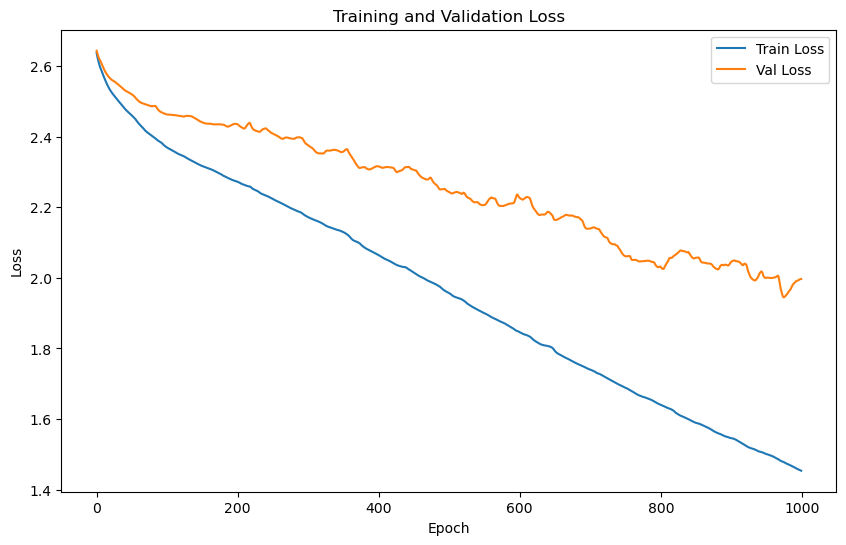

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.3393 | Test Accuracy: 36.23%


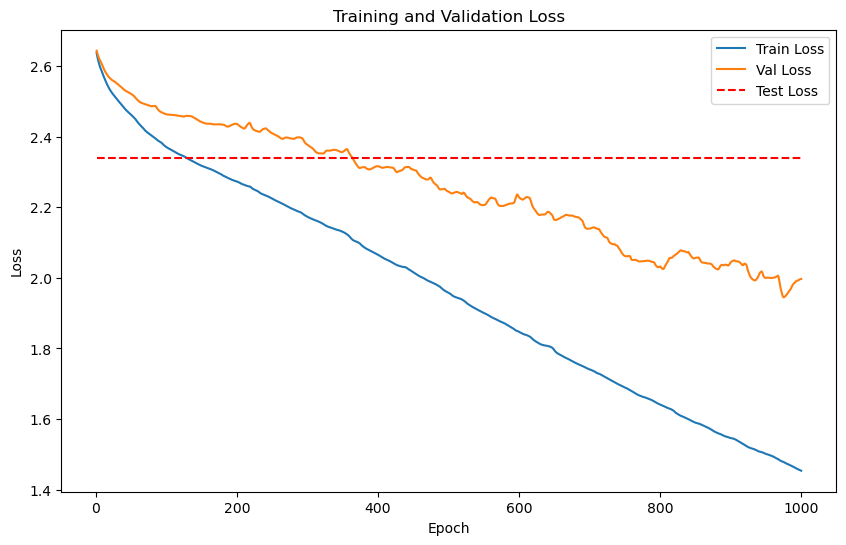

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5081 samples with 64 features each
LOG: Labels shape: (5081,)


Train embeddings shape: (65, 64), 
Train labels shape: (65,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5081, 64), 
Test labels shape: (5081,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5}
Training batch size: 65


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5418
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5757
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5418, Avg Val Loss: 0.5378

Validation loss improved from inf to 0.5378. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.5316
LOG: Epoch [2/2000] - Validation


    Batch [1/2], Val Loss: 0.5751
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5316, Avg Val Loss: 0.5376

Validation loss improved from 0.5378 to 0.5376. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5407
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.5744
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5407, Avg Val Loss: 0.5372

Validation loss improved from 0.5376 to 0.5372. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.5316
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5735


    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5316, Avg Val Loss: 0.5368

Validation loss improved from 0.5372 to 0.5368. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.5360
LOG: Epoch [5/2000] - Validation


    Batch [1/2], Val Loss: 0.5725
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5360, Avg Val Loss: 0.5363

Validation loss improved from 0.5368 to 0.5363. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.5412
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5713
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5412, Avg Val Loss: 0.5357

Validation loss improved from 0.5363 to 0.5357. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.5290
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5702
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5290, Avg Val Loss: 0.5351

Validation loss improved from 0.5357 to 0.5351. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.5235
LOG: Epoch [8/2000] - Validation


    Batch [1/2], Val Loss: 0.5689
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5235, Avg Val Loss: 0.5345

Validation loss improved from 0.5351 to 0.5345. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.5330
LOG: Epoch [9/2000] - Validation


    Batch [1/2], Val Loss: 0.5677
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5330, Avg Val Loss: 0.5339

Validation loss improved from 0.5345 to 0.5339. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.5201
LOG: Epoch [10/2000] - Validation


    Batch [1/2], Val Loss: 0.5668
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5201, Avg Val Loss: 0.5334

Validation loss improved from 0.5339 to 0.5334. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.5303
LOG: Epoch [11/2000] - Validation


    Batch [1/2], Val Loss: 0.5656
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5303, Avg Val Loss: 0.5328

Validation loss improved from 0.5334 to 0.5328. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.5306
LOG: Epoch [12/2000] - Validation


    Batch [1/2], Val Loss: 0.5647
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5306, Avg Val Loss: 0.5324

Validation loss improved from 0.5328 to 0.5324. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.5282
LOG: Epoch [13/2000] - Validation


    Batch [1/2], Val Loss: 0.5632
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5282, Avg Val Loss: 0.5316

Validation loss improved from 0.5324 to 0.5316. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.5200
LOG: Epoch [14/2000] - Validation


    Batch [1/2], Val Loss: 0.5613
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5200, Avg Val Loss: 0.5307

Validation loss improved from 0.5316 to 0.5307. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.5287
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5592
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5287, Avg Val Loss: 0.5296

Validation loss improved from 0.5307 to 0.5296. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.5260
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5577
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5260, Avg Val Loss: 0.5289

Validation loss improved from 0.5296 to 0.5289. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.5283
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5562
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5283, Avg Val Loss: 0.5281

Validation loss improved from 0.5289 to 0.5281. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5241
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.5553
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5241, Avg Val Loss: 0.5276

Validation loss improved from 0.5281 to 0.5276. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5203
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5544
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5203, Avg Val Loss: 0.5272

Validation loss improved from 0.5276 to 0.5272. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.5186
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5525
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5186, Avg Val Loss: 0.5263

Validation loss improved from 0.5272 to 0.5263. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.5177
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5502
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5177, Avg Val Loss: 0.5251

Validation loss improved from 0.5263 to 0.5251. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.5242
LOG: Epoch [22/2000] - Validation


    Batch [1/2], Val Loss: 0.5488
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5242, Avg Val Loss: 0.5244

Validation loss improved from 0.5251 to 0.5244. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.5192
LOG: Epoch [23/2000] - Validation


    Batch [1/2], Val Loss: 0.5474
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5192, Avg Val Loss: 0.5237

Validation loss improved from 0.5244 to 0.5237. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.5204
LOG: Epoch [24/2000] - Validation


    Batch [1/2], Val Loss: 0.5455
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5204, Avg Val Loss: 0.5228

Validation loss improved from 0.5237 to 0.5228. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.5198
LOG: Epoch [25/2000] - Validation


    Batch [1/2], Val Loss: 0.5444
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5198, Avg Val Loss: 0.5222

Validation loss improved from 0.5228 to 0.5222. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.5167
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.5437
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5167, Avg Val Loss: 0.5218

Validation loss improved from 0.5222 to 0.5218. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.5133
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5433
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5133, Avg Val Loss: 0.5217

Validation loss improved from 0.5218 to 0.5217. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.5176
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5422
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5176, Avg Val Loss: 0.5211

Validation loss improved from 0.5217 to 0.5211. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.5260
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.5414
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5260, Avg Val Loss: 0.5207

Validation loss improved from 0.5211 to 0.5207. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.5146
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5406
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5146, Avg Val Loss: 0.5203

Validation loss improved from 0.5207 to 0.5203. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.5189
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5400
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5189, Avg Val Loss: 0.5200

Validation loss improved from 0.5203 to 0.5200. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.5109
LOG: Epoch [32/2000] - Validation


    Batch [1/2], Val Loss: 0.5395
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5109, Avg Val Loss: 0.5197

Validation loss improved from 0.5200 to 0.5197. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.5160
LOG: Epoch [33/2000] - Validation


    Batch [1/2], Val Loss: 0.5384
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5160, Avg Val Loss: 0.5192

Validation loss improved from 0.5197 to 0.5192. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.5076
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5375
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5076, Avg Val Loss: 0.5188

Validation loss improved from 0.5192 to 0.5188. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.5113
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5365
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5113, Avg Val Loss: 0.5182

Validation loss improved from 0.5188 to 0.5182. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.5091
LOG: Epoch [36/2000] - Validation


    Batch [1/2], Val Loss: 0.5353
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5091, Avg Val Loss: 0.5176

Validation loss improved from 0.5182 to 0.5176. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.5028
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5342
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5028, Avg Val Loss: 0.5171

Validation loss improved from 0.5176 to 0.5171. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.5157
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5332
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5157, Avg Val Loss: 0.5166

Validation loss improved from 0.5171 to 0.5166. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.5042
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5320
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.5160

Validation loss improved from 0.5166 to 0.5160. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.5114
LOG: Epoch [40/2000] - Validation


    Batch [1/2], Val Loss: 0.5308
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5114, Avg Val Loss: 0.5154

Validation loss improved from 0.5160 to 0.5154. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.5122
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5296
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5122, Avg Val Loss: 0.5148

Validation loss improved from 0.5154 to 0.5148. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.5107
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5107, Avg Val Loss: 0.5142

Validation loss improved from 0.5148 to 0.5142. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.5132
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5272
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5132, Avg Val Loss: 0.5136

Validation loss improved from 0.5142 to 0.5136. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.5095
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5260
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5095, Avg Val Loss: 0.5130

Validation loss improved from 0.5136 to 0.5130. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.5002
LOG: Epoch [45/2000] - Validation


    Batch [1/2], Val Loss: 0.5246
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.5123

Validation loss improved from 0.5130 to 0.5123. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.5231
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5116

Validation loss improved from 0.5123 to 0.5116. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4999
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5218
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.4999, Avg Val Loss: 0.5109

Validation loss improved from 0.5116 to 0.5109. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.5027
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5206
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5027, Avg Val Loss: 0.5103

Validation loss improved from 0.5109 to 0.5103. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.5063
LOG: Epoch [49/2000] - Validation


    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5063, Avg Val Loss: 0.5098

Validation loss improved from 0.5103 to 0.5098. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5072
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5186
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5072, Avg Val Loss: 0.5093

Validation loss improved from 0.5098 to 0.5093. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.5071
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5071, Avg Val Loss: 0.5089

Validation loss improved from 0.5093 to 0.5089. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.5004
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5004, Avg Val Loss: 0.5085

Validation loss improved from 0.5089 to 0.5085. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.5016
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5016, Avg Val Loss: 0.5081

Validation loss improved from 0.5085 to 0.5081. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5078

Validation loss improved from 0.5081 to 0.5078. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [55/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5075

Validation loss improved from 0.5078 to 0.5075. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.5011
LOG: Epoch [56/2000] - Validation


    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5011, Avg Val Loss: 0.5072

Validation loss improved from 0.5075 to 0.5072. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5140
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5070

Validation loss improved from 0.5072 to 0.5070. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.5067

Validation loss improved from 0.5070 to 0.5067. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5065

Validation loss improved from 0.5067 to 0.5065. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.5126
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5063

Validation loss improved from 0.5065 to 0.5063. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.5122
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5061

Validation loss improved from 0.5063 to 0.5061. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [62/2000] - Validation


    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5059

Validation loss improved from 0.5061 to 0.5059. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5116
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.5058

Validation loss improved from 0.5059 to 0.5058. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5113
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5056

Validation loss improved from 0.5058 to 0.5056. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [65/2000] - Validation


    Batch [1/2], Val Loss: 0.5109
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.5055

Validation loss improved from 0.5056 to 0.5055. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5106
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5053

Validation loss improved from 0.5055 to 0.5053. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5102
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5051

Validation loss improved from 0.5053 to 0.5051. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [68/2000] - Validation


    Batch [1/2], Val Loss: 0.5099
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.5049

Validation loss improved from 0.5051 to 0.5049. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5048

Validation loss improved from 0.5049 to 0.5048. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5093
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5047

Validation loss improved from 0.5048 to 0.5047. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [71/2000] - Validation


    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.5045

Validation loss improved from 0.5047 to 0.5045. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5043

Validation loss improved from 0.5045 to 0.5043. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5084
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5042

Validation loss improved from 0.5043 to 0.5042. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [74/2000] - Validation


    Batch [1/2], Val Loss: 0.5083
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5041

Validation loss improved from 0.5042 to 0.5041. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5081
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5040

Validation loss improved from 0.5041 to 0.5040. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5080
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5040

Validation loss improved from 0.5040 to 0.5040. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5040

Validation loss improved from 0.5040 to 0.5040. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5039

Validation loss improved from 0.5040 to 0.5039. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5078
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.5039

Validation loss improved from 0.5039 to 0.5039. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5039

Validation loss improved from 0.5039 to 0.5039. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5074
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.5037

Validation loss improved from 0.5039 to 0.5037. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5071
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.5036

Validation loss improved from 0.5037 to 0.5036. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.5034

Validation loss improved from 0.5036 to 0.5034. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5032

Validation loss improved from 0.5034 to 0.5032. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5058
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.5029

Validation loss improved from 0.5032 to 0.5029. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5052
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5026

Validation loss improved from 0.5029 to 0.5026. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.5024

Validation loss improved from 0.5026 to 0.5024. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5045


    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.5023

Validation loss improved from 0.5024 to 0.5023. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.5020

Validation loss improved from 0.5023 to 0.5020. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.5018

Validation loss improved from 0.5020 to 0.5018. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.5016

Validation loss improved from 0.5018 to 0.5016. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [92/2000] - Validation


    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.5014

Validation loss improved from 0.5016 to 0.5014. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.5012

Validation loss improved from 0.5014 to 0.5012. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5022
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.5011

Validation loss improved from 0.5012 to 0.5011. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5021
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.5010

Validation loss improved from 0.5011 to 0.5010. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [96/2000] - Validation


    Batch [1/2], Val Loss: 0.5020
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.5010

Validation loss improved from 0.5010 to 0.5010. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.5022
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.4961
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4961, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [101/2000] - Validation


    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.5013

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.5013

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.5014

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.5030
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.5015

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.5016

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5016

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.5031
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.5016

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [110/2000] - Validation


    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.5018

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5018

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [113/2000] - Validation


    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5018

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4757
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.5037
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4757, Avg Val Loss: 0.5019

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5021

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.5020

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.5016

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4750
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.5008

Validation loss improved from 0.5010 to 0.5008. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.5005

Validation loss improved from 0.5008 to 0.5005. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [126/2000] - Validation


    Batch [1/2], Val Loss: 0.5003
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5001

Validation loss improved from 0.5005 to 0.5001. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [127/2000] - Validation


    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4999

Validation loss improved from 0.5001 to 0.4999. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.4997

Validation loss improved from 0.4999 to 0.4997. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4991
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4995

Validation loss improved from 0.4997 to 0.4995. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4994

Validation loss improved from 0.4995 to 0.4994. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [131/2000] - Validation


    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.4994

Validation loss improved from 0.4994 to 0.4994. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.4993

Validation loss improved from 0.4994 to 0.4993. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.4992

Validation loss improved from 0.4993 to 0.4992. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4983
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4991

Validation loss improved from 0.4992 to 0.4991. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [135/2000] - Validation


    Batch [1/2], Val Loss: 0.4981
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.4991

Validation loss improved from 0.4991 to 0.4991. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [136/2000] - Validation


    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.4990

Validation loss improved from 0.4991 to 0.4990. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4979
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.4990

Validation loss improved from 0.4990 to 0.4990. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4989

Validation loss improved from 0.4990 to 0.4989. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4977
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4989

Validation loss improved from 0.4989 to 0.4989. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4977
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.4988

Validation loss improved from 0.4989 to 0.4988. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [141/2000] - Validation


    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4988

Validation loss improved from 0.4988 to 0.4988. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4975
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.4987

Validation loss improved from 0.4988 to 0.4987. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4987

Validation loss improved from 0.4987 to 0.4987. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.4987

Validation loss improved from 0.4987 to 0.4987. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [145/2000] - Validation


    Batch [1/2], Val Loss: 0.4973
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.4986

Validation loss improved from 0.4987 to 0.4986. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [146/2000] - Validation


    Batch [1/2], Val Loss: 0.4973
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4986

Validation loss improved from 0.4986 to 0.4986. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4972
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4986

Validation loss improved from 0.4986 to 0.4986. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4972
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4986

Validation loss improved from 0.4986 to 0.4986. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4986

Validation loss improved from 0.4986 to 0.4986. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.4986

Validation loss improved from 0.4986 to 0.4986. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [151/2000] - Validation


    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4985

Validation loss improved from 0.4986 to 0.4985. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.4716
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [154/2000] - Validation


    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.4985

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [155/2000] - Validation


    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [159/2000] - Validation


    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [162/2000] - Validation


    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4985

Validation loss improved from 0.4985 to 0.4985. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [166/2000] - Validation


    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.4985

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [167/2000] - Validation


    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.4985

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.4985

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.4985

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.4985

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.4985

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.4985

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.4985

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.4985

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.4985

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.4985

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4984

Validation loss improved from 0.4985 to 0.4984. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [178/2000] - Validation


    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [186/2000] - Validation


    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [188/2000] - Validation


    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [191/2000] - Validation


    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [194/2000] - Validation


    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [203/2000] - Validation


    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4984

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [208/2000] - Validation


    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [209/2000] - Validation


    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.4983

Validation loss improved from 0.4984 to 0.4983. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [213/2000] - Validation


    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [216/2000] - Validation


    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [221/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.4983

Validation loss improved from 0.4983 to 0.4983. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4982

Validation loss improved from 0.4983 to 0.4982. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [228/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [229/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4965


    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [233/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [234/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [235/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [236/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [243/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4763
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [247/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [250/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [252/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [256/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [257/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [258/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [259/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [263/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [266/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [269/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [270/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [275/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [278/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [279/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [280/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [284/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [289/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [290/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [295/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [296/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [300/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [301/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [305/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [309/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [316/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [320/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [321/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [322/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [327/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [330/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [334/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [337/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [338/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [341/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [347/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [350/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [353/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [354/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [355/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [359/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [360/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [363/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [366/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [369/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [372/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [377/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.4601
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4601, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [383/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [386/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.4558
LOG: Epoch [387/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [388/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [389/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [390/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.4751
LOG: Epoch [391/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4751, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [392/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [393/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [394/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [397/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [400/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [401/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [404/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [405/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [406/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [410/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [411/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [412/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [413/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [416/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [417/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [421/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [424/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [430/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [431/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4964


    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4964


    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [436/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [437/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [441/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [443/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [444/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [445/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [445/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [446/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [446/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [447/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [448/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [449/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [449/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [450/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [451/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [452/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [453/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [453/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [454/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [455/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [456/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [456/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [457/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [458/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [459/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [459/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [460/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [460/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [461/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [462/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [463/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [464/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [464/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [465/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [465/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [466/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [467/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [468/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [469/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [470/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [470/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.4755
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [471/2000], Avg Train Loss: 0.4755, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [472/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [473/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [473/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [474/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [474/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4964


    Batch [2/2], Val Loss: 0.5000
Epoch [475/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [476/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [476/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [477/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [477/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4964


    Batch [2/2], Val Loss: 0.5000
Epoch [478/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [479/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [480/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [481/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [482/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [482/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [483/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [484/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [485/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [486/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [486/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [487/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [487/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [488/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [488/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [489/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [490/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [491/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [491/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [492/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [493/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [494/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [494/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [495/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [495/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [496/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [497/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [498/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [498/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [499/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [499/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [500/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [501/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [502/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [503/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [503/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [504/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [505/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [506/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [506/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [507/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [508/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [509/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [510/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [510/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [511/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [512/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [513/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [513/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [514/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [515/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [516/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [516/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [517/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [517/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [518/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [519/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [520/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [520/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [521/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [521/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [522/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [523/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [524/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [524/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [525/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [525/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [526/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [527/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [528/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [529/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [529/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4964


    Batch [2/2], Val Loss: 0.5000
Epoch [530/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [531/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [532/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [533/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [533/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [534/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [535/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [536/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [536/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [537/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [538/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [539/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [539/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [540/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [541/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [542/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [542/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [543/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [544/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [545/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [545/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [546/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [546/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [547/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [548/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [549/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [550/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [550/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [551/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [551/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [552/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [552/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [553/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [554/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [555/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [555/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [556/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [556/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [557/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [558/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [559/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [560/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [561/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [561/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [562/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [562/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [563/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [563/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [564/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [565/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [566/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [566/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [567/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [568/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [569/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [569/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [570/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [570/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [571/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [571/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [572/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [573/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [574/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [575/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [575/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [576/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.4601
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [577/2000], Avg Train Loss: 0.4601, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [578/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [579/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [580/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [581/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [582/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [582/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.4751
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [583/2000], Avg Train Loss: 0.4751, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [584/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [585/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [585/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [586/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [586/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [587/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [588/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [589/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [589/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [590/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [591/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [592/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [592/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [593/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [593/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [594/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [595/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [596/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [596/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [597/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [598/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [599/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [600/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [600/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [601/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [601/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [602/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [603/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [604/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [605/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [605/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [606/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [607/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [608/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [608/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [609/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [610/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [611/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.4716
LOG: Epoch [612/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [612/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [613/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [613/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [614/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [615/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [616/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [617/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [617/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [618/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [619/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [620/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [621/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [622/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [622/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [623/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.4555
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [624/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [625/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [625/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [626/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [627/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [628/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [628/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [629/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [630/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [631/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [631/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [632/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [632/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [633/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [634/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [635/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [636/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [636/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [637/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [637/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [638/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [639/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [640/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [641/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [642/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [643/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [644/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [644/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [645/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [645/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [646/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [646/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [647/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [647/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [648/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [648/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [649/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [650/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [651/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [651/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [652/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [653/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [654/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [654/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [655/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [656/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [657/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [658/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [659/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [659/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [660/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [660/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [661/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [661/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [662/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [662/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [663/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [664/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [665/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [666/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [666/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [667/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [667/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [668/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [668/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [669/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [670/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [671/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [671/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [672/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [672/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [673/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [673/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [674/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [674/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [675/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [676/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [677/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [677/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [678/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [679/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [680/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [680/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [681/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [682/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [683/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [684/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [685/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [685/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [686/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [686/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [687/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [688/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [689/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [689/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [690/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [691/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [692/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [693/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [694/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [694/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [695/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [696/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [697/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [697/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [698/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [698/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [699/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.4726
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [700/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [701/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [702/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [702/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [703/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [703/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [704/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [704/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [705/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [705/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [706/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [707/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [708/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [708/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [709/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [709/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [710/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [710/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [711/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [711/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [712/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [713/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [714/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [714/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [715/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [715/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [716/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [717/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [718/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [719/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [719/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [720/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [720/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [721/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [721/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [722/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [723/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [724/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [725/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [726/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [726/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [727/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [728/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [729/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [729/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [730/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [731/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [732/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [733/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [733/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [734/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [734/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [735/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [735/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [736/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [737/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [738/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [739/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [739/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [740/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [741/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [742/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [742/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [743/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [744/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [745/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [746/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [746/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [747/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [747/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [748/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [748/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [749/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [749/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [750/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [751/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [752/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [752/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [753/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [754/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [755/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [755/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [756/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [756/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [757/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [757/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [758/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [759/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [760/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [761/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [762/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [763/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [764/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [764/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [765/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [766/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [767/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [768/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 0.4596
LOG: Epoch [769/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [769/2000], Avg Train Loss: 0.4596, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000


Epoch [770/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [771/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [771/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.4964


    Batch [2/2], Val Loss: 0.5000
Epoch [772/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [773/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [774/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [775/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [776/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [777/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [777/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [778/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [778/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [779/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [779/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [780/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [781/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [782/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [783/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [783/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.4706
LOG: Epoch [784/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [784/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [785/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [786/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [787/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [788/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [789/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [789/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [790/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [790/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [791/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [792/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [793/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [794/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [794/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [795/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [795/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [796/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [797/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [798/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [799/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [800/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [801/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [801/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [802/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [803/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [804/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [804/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [805/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [806/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [807/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [808/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [808/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [809/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [809/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.4964


    Batch [2/2], Val Loss: 0.5000
Epoch [810/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [811/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [812/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [813/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [813/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [814/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [815/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [816/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [817/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [818/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [818/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [819/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [819/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [820/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [821/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [822/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [822/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [823/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [824/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [825/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [826/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [826/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [827/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [827/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [828/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [828/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [829/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [830/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [831/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [832/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [832/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [833/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [833/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [834/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4982

Validation loss improved from 0.4982 to 0.4982. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [835/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [836/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [836/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [837/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [838/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [839/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [839/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [840/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [841/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [842/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [842/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [843/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [844/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [845/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [846/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [847/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [847/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [848/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [849/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [850/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [850/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [851/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [852/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [853/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [854/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [854/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [855/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [855/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [856/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [857/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [858/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [858/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [859/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [859/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [860/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [861/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [862/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [862/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [863/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [863/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [864/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [864/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [865/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [866/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [867/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [867/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 0.4540
LOG: Epoch [868/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [868/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [869/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [870/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [871/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [871/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [872/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [872/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [873/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [873/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [874/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [875/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [876/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [876/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [877/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [878/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [879/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [879/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [880/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [880/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [881/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [881/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [882/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [883/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [884/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [884/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [885/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [886/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [887/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [888/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [889/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [889/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 0.4601
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [890/2000], Avg Train Loss: 0.4601, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [891/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [892/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [893/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [893/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [894/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [894/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [895/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [896/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [897/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [897/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [898/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [899/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [900/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [901/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [902/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [902/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [903/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [904/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [905/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [905/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [906/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [907/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [908/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [908/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [909/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [910/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [911/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [911/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [912/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [913/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [914/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [915/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [916/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [916/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [917/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [917/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [918/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [918/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [919/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [919/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [920/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [921/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [922/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [923/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [924/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [924/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [925/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [925/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [926/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [927/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [928/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [929/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [929/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [930/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [931/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [932/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [933/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [934/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4982

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 934!!
No improvement for 100 epochs


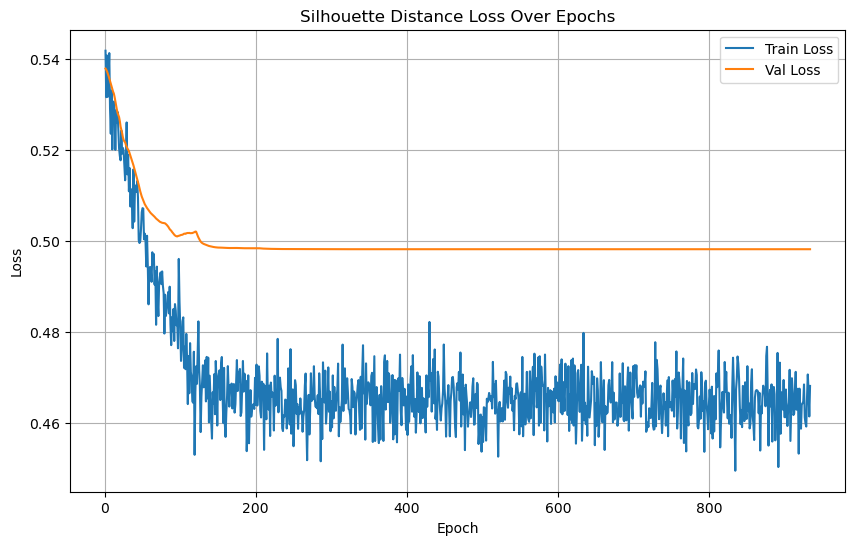

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/80], Loss: 0.3268


Test Batch [20/80], Loss: 0.5000
Test Batch [30/80], Loss: 0.3842
Test Batch [40/80], Loss: 0.2995
Test Batch [50/80], Loss: 0.3087
Test Batch [60/80], Loss: 0.3759


Test Batch [70/80], Loss: 0.4190
Test Batch [80/80], Loss: 0.5000

Test Loss: 0.3289


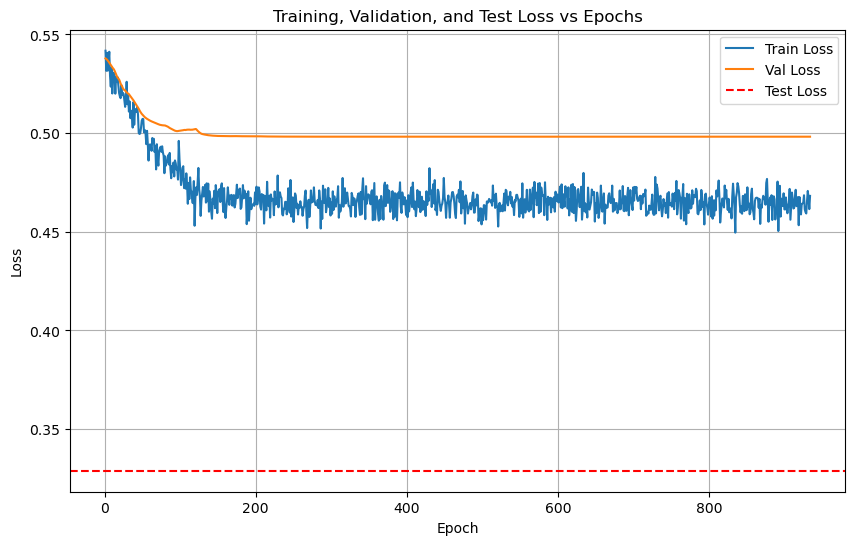

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/80 for test dataset.


  Processed batch 20/80 for test dataset.
  Processed batch 30/80 for test dataset.


  Processed batch 40/80 for test dataset.
  Processed batch 50/80 for test dataset.
  Processed batch 60/80 for test dataset.


  Processed batch 70/80 for test dataset.
  Processed batch 80/80 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 38.46%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.00      0.00      0.00         5
           2       1.00      0.20      0.33         5
           3       0.27      0.60      0.38         5
           4       0.33      0.40      0.36         5
           5       0.30      0.60      0.40         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.43      0.60      0.50         5
           9       0.25      0.20      0.22         5
          10       0.80      0.80      0.80         5
          11       0.38      0.60      0.46         5
          12       0.80      0.80      0.80         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (65, 128)
Train labels shape: (65,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5081, 128)
Test labels shape: (5081,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5847  |  Val Loss: 2.5896
Validation loss improved from inf to 2.5896.
[Epoch 2/1000] Train Loss: 2.5781  |  Val Loss: 2.5873
Validation loss improved from 2.5896 to 2.5873.
[Epoch 3/1000] Train Loss: 2.5727  |  Val Loss: 2.5851
Validation loss improved from 2.5873 to 2.5851.
[Epoch 4/1000] Train Loss: 2.5677  |  Val Loss: 2.5833
Validation loss improved from 2.5851 to 2.5833.
[Epoch 5/1000] Train Loss: 2.5629  |  Val Loss: 2.5816
Validation loss improved from 2.5833 to 2.5816.
[Epoch 6/1000] Train Loss: 2.5586  |  Val Loss: 2.5800
Validation loss improved from 2.5816 to 2.5800.
[Epoch 7/1000] Train Loss: 2.5543  |  Val Loss: 2.5789
Validation loss improved from 2.5800 to 2.5789.
[Epoch 8/1000] Train Loss: 2.5503  |  Val Loss: 2.5776
Validation loss improved from 2.5789 to 2.5776.
[Epoch 9/1000] Train Loss: 2.5465  |  Val Loss: 2.5762
Validation loss improved from 2.5776 to 2.5762.
[Epoch 10/1000] Train Loss: 2.5430  |  Val Loss: 2.5748
Validation loss impr

[Epoch 27/1000] Train Loss: 2.4868  |  Val Loss: 2.5521
Validation loss improved from 2.5531 to 2.5521.
[Epoch 28/1000] Train Loss: 2.4841  |  Val Loss: 2.5513
Validation loss improved from 2.5521 to 2.5513.
[Epoch 29/1000] Train Loss: 2.4814  |  Val Loss: 2.5506
Validation loss improved from 2.5513 to 2.5506.
[Epoch 30/1000] Train Loss: 2.4790  |  Val Loss: 2.5500
Validation loss improved from 2.5506 to 2.5500.
[Epoch 31/1000] Train Loss: 2.4766  |  Val Loss: 2.5494
Validation loss improved from 2.5500 to 2.5494.
[Epoch 32/1000] Train Loss: 2.4744  |  Val Loss: 2.5491
Validation loss improved from 2.5494 to 2.5491.
[Epoch 33/1000] Train Loss: 2.4722  |  Val Loss: 2.5486
Validation loss improved from 2.5491 to 2.5486.
[Epoch 34/1000] Train Loss: 2.4701  |  Val Loss: 2.5482
Validation loss improved from 2.5486 to 2.5482.
[Epoch 35/1000] Train Loss: 2.4681  |  Val Loss: 2.5473
Validation loss improved from 2.5482 to 2.5473.
[Epoch 36/1000] Train Loss: 2.4660  |  Val Loss: 2.5460
Validati

[Epoch 39/1000] Train Loss: 2.4599  |  Val Loss: 2.5432
Validation loss improved from 2.5440 to 2.5432.
[Epoch 40/1000] Train Loss: 2.4582  |  Val Loss: 2.5425
Validation loss improved from 2.5432 to 2.5425.
[Epoch 41/1000] Train Loss: 2.4566  |  Val Loss: 2.5420
Validation loss improved from 2.5425 to 2.5420.
[Epoch 42/1000] Train Loss: 2.4549  |  Val Loss: 2.5416
Validation loss improved from 2.5420 to 2.5416.
[Epoch 43/1000] Train Loss: 2.4533  |  Val Loss: 2.5412
Validation loss improved from 2.5416 to 2.5412.
[Epoch 44/1000] Train Loss: 2.4517  |  Val Loss: 2.5409
Validation loss improved from 2.5412 to 2.5409.
[Epoch 45/1000] Train Loss: 2.4501  |  Val Loss: 2.5405
Validation loss improved from 2.5409 to 2.5405.
[Epoch 46/1000] Train Loss: 2.4486  |  Val Loss: 2.5401
Validation loss improved from 2.5405 to 2.5401.
[Epoch 47/1000] Train Loss: 2.4471  |  Val Loss: 2.5398
Validation loss improved from 2.5401 to 2.5398.
[Epoch 48/1000] Train Loss: 2.4456  |  Val Loss: 2.5396
Validati

[Epoch 67/1000] Train Loss: 2.4111  |  Val Loss: 2.5317
Validation loss improved from 2.5325 to 2.5317.
[Epoch 68/1000] Train Loss: 2.4094  |  Val Loss: 2.5309
Validation loss improved from 2.5317 to 2.5309.
[Epoch 69/1000] Train Loss: 2.4079  |  Val Loss: 2.5303
Validation loss improved from 2.5309 to 2.5303.
[Epoch 70/1000] Train Loss: 2.4063  |  Val Loss: 2.5297
Validation loss improved from 2.5303 to 2.5297.
[Epoch 71/1000] Train Loss: 2.4048  |  Val Loss: 2.5291
Validation loss improved from 2.5297 to 2.5291.
[Epoch 72/1000] Train Loss: 2.4032  |  Val Loss: 2.5290
Validation loss improved from 2.5291 to 2.5290.
[Epoch 73/1000] Train Loss: 2.4014  |  Val Loss: 2.5292
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 74/1000] Train Loss: 2.3995  |  Val Loss: 2.5290
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 75/1000] Train Loss: 2.3974  |  Val Loss: 2.5286
Validation loss improved from 2.5290 to 2.5286.
[Epoch 76/1000] Train Loss: 2.3950  |  Val Loss: 2.5

[Epoch 81/1000] Train Loss: 2.3850  |  Val Loss: 2.5257
Validation loss improved from 2.5261 to 2.5257.
[Epoch 82/1000] Train Loss: 2.3833  |  Val Loss: 2.5253
Validation loss improved from 2.5257 to 2.5253.
[Epoch 83/1000] Train Loss: 2.3818  |  Val Loss: 2.5251
Validation loss improved from 2.5253 to 2.5251.
[Epoch 84/1000] Train Loss: 2.3803  |  Val Loss: 2.5249
Validation loss improved from 2.5251 to 2.5249.
[Epoch 85/1000] Train Loss: 2.3789  |  Val Loss: 2.5247
Validation loss improved from 2.5249 to 2.5247.
[Epoch 86/1000] Train Loss: 2.3775  |  Val Loss: 2.5244
Validation loss improved from 2.5247 to 2.5244.
[Epoch 87/1000] Train Loss: 2.3759  |  Val Loss: 2.5242
Validation loss improved from 2.5244 to 2.5242.
[Epoch 88/1000] Train Loss: 2.3743  |  Val Loss: 2.5235
Validation loss improved from 2.5242 to 2.5235.
[Epoch 89/1000] Train Loss: 2.3726  |  Val Loss: 2.5225
Validation loss improved from 2.5235 to 2.5225.
[Epoch 90/1000] Train Loss: 2.3707  |  Val Loss: 2.5222
Validati

[Epoch 114/1000] Train Loss: 2.3347  |  Val Loss: 2.5200
Validation loss improved from 2.5219 to 2.5200.
[Epoch 115/1000] Train Loss: 2.3329  |  Val Loss: 2.5183
Validation loss improved from 2.5200 to 2.5183.
[Epoch 116/1000] Train Loss: 2.3311  |  Val Loss: 2.5168
Validation loss improved from 2.5183 to 2.5168.
[Epoch 117/1000] Train Loss: 2.3292  |  Val Loss: 2.5155
Validation loss improved from 2.5168 to 2.5155.
[Epoch 118/1000] Train Loss: 2.3275  |  Val Loss: 2.5142
Validation loss improved from 2.5155 to 2.5142.
[Epoch 119/1000] Train Loss: 2.3260  |  Val Loss: 2.5139
Validation loss improved from 2.5142 to 2.5139.
[Epoch 120/1000] Train Loss: 2.3242  |  Val Loss: 2.5142
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 121/1000] Train Loss: 2.3225  |  Val Loss: 2.5143
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 122/1000] Train Loss: 2.3209  |  Val Loss: 2.5144
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 123/1000] Train Loss: 2.3194  

[Epoch 127/1000] Train Loss: 2.3132  |  Val Loss: 2.5201
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 128/1000] Train Loss: 2.3119  |  Val Loss: 2.5222
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 129/1000] Train Loss: 2.3105  |  Val Loss: 2.5238
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 130/1000] Train Loss: 2.3092  |  Val Loss: 2.5252
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 131/1000] Train Loss: 2.3079  |  Val Loss: 2.5263
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 132/1000] Train Loss: 2.3067  |  Val Loss: 2.5272
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 133/1000] Train Loss: 2.3055  |  Val Loss: 2.5278
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 134/1000] Train Loss: 2.3041  |  Val Loss: 2.5283
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 135/1000] Train Loss: 2.3026  |  Val Loss: 2.5286
!! Validation loss did NOT improve !! Patience: 1

[Epoch 156/1000] Train Loss: 2.2715  |  Val Loss: 2.5063
Validation loss improved from 2.5068 to 2.5063.
[Epoch 157/1000] Train Loss: 2.2696  |  Val Loss: 2.5058
Validation loss improved from 2.5063 to 2.5058.
[Epoch 158/1000] Train Loss: 2.2680  |  Val Loss: 2.5054
Validation loss improved from 2.5058 to 2.5054.
[Epoch 159/1000] Train Loss: 2.2664  |  Val Loss: 2.5057
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 160/1000] Train Loss: 2.2648  |  Val Loss: 2.5063
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 161/1000] Train Loss: 2.2630  |  Val Loss: 2.5051
Validation loss improved from 2.5054 to 2.5051.
[Epoch 162/1000] Train Loss: 2.2608  |  Val Loss: 2.5023
Validation loss improved from 2.5051 to 2.5023.
[Epoch 163/1000] Train Loss: 2.2584  |  Val Loss: 2.5002
Validation loss improved from 2.5023 to 2.5002.
[Epoch 164/1000] Train Loss: 2.2563  |  Val Loss: 2.4987
Validation loss improved from 2.5002 to 2.4987.
[Epoch 165/1000] Train Loss: 2.2542  |  Val

[Epoch 166/1000] Train Loss: 2.2523  |  Val Loss: 2.4958
Validation loss improved from 2.4972 to 2.4958.
[Epoch 167/1000] Train Loss: 2.2503  |  Val Loss: 2.4933
Validation loss improved from 2.4958 to 2.4933.
[Epoch 168/1000] Train Loss: 2.2484  |  Val Loss: 2.4900
Validation loss improved from 2.4933 to 2.4900.
[Epoch 169/1000] Train Loss: 2.2462  |  Val Loss: 2.4874
Validation loss improved from 2.4900 to 2.4874.
[Epoch 170/1000] Train Loss: 2.2442  |  Val Loss: 2.4860
Validation loss improved from 2.4874 to 2.4860.
[Epoch 171/1000] Train Loss: 2.2422  |  Val Loss: 2.4856
Validation loss improved from 2.4860 to 2.4856.
[Epoch 172/1000] Train Loss: 2.2402  |  Val Loss: 2.4853
Validation loss improved from 2.4856 to 2.4853.
[Epoch 173/1000] Train Loss: 2.2384  |  Val Loss: 2.4858
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 174/1000] Train Loss: 2.2367  |  Val Loss: 2.4870
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 175/1000] Train Loss: 2.2350  |  Val

[Epoch 195/1000] Train Loss: 2.2064  |  Val Loss: 2.4913
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 196/1000] Train Loss: 2.2049  |  Val Loss: 2.4919
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 197/1000] Train Loss: 2.2034  |  Val Loss: 2.4922
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 198/1000] Train Loss: 2.2020  |  Val Loss: 2.4924
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 199/1000] Train Loss: 2.2004  |  Val Loss: 2.4925
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 200/1000] Train Loss: 2.1988  |  Val Loss: 2.4932
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 201/1000] Train Loss: 2.1974  |  Val Loss: 2.4940
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 202/1000] Train Loss: 2.1958  |  Val Loss: 2.4945
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 203/1000] Train Loss: 2.1943  |  Val Loss: 2.4947
!! Validation loss did NOT improve !! Patience:

[Epoch 205/1000] Train Loss: 2.1914  |  Val Loss: 2.4943
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 206/1000] Train Loss: 2.1900  |  Val Loss: 2.4937
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 207/1000] Train Loss: 2.1886  |  Val Loss: 2.4928
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 208/1000] Train Loss: 2.1871  |  Val Loss: 2.4916
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 209/1000] Train Loss: 2.1854  |  Val Loss: 2.4894
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 210/1000] Train Loss: 2.1834  |  Val Loss: 2.4863
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 211/1000] Train Loss: 2.1814  |  Val Loss: 2.4837
Validation loss improved from 2.4853 to 2.4837.
[Epoch 212/1000] Train Loss: 2.1794  |  Val Loss: 2.4813
Validation loss improved from 2.4837 to 2.4813.
[Epoch 213/1000] Train Loss: 2.1774  |  Val Loss: 2.4790
Validation loss improved from 2.4813 to 2.4790.
[Epoch 214/10

[Epoch 238/1000] Train Loss: 2.1336  |  Val Loss: 2.4771
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 239/1000] Train Loss: 2.1321  |  Val Loss: 2.4767
Validation loss improved from 2.4768 to 2.4767.
[Epoch 240/1000] Train Loss: 2.1305  |  Val Loss: 2.4761
Validation loss improved from 2.4767 to 2.4761.
[Epoch 241/1000] Train Loss: 2.1289  |  Val Loss: 2.4753
Validation loss improved from 2.4761 to 2.4753.
[Epoch 242/1000] Train Loss: 2.1271  |  Val Loss: 2.4747
Validation loss improved from 2.4753 to 2.4747.
[Epoch 243/1000] Train Loss: 2.1255  |  Val Loss: 2.4744
Validation loss improved from 2.4747 to 2.4744.
[Epoch 244/1000] Train Loss: 2.1239  |  Val Loss: 2.4744
Validation loss improved from 2.4744 to 2.4744.
[Epoch 245/1000] Train Loss: 2.1224  |  Val Loss: 2.4747
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 246/1000] Train Loss: 2.1209  |  Val Loss: 2.4750
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 247/1000] Train Loss: 2.1195 

[Epoch 250/1000] Train Loss: 2.1155  |  Val Loss: 2.4752
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 251/1000] Train Loss: 2.1142  |  Val Loss: 2.4751
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 252/1000] Train Loss: 2.1130  |  Val Loss: 2.4747
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 253/1000] Train Loss: 2.1118  |  Val Loss: 2.4745
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 254/1000] Train Loss: 2.1106  |  Val Loss: 2.4744
Validation loss improved from 2.4744 to 2.4744.
[Epoch 255/1000] Train Loss: 2.1095  |  Val Loss: 2.4754
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 256/1000] Train Loss: 2.1083  |  Val Loss: 2.4772
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 257/1000] Train Loss: 2.1071  |  Val Loss: 2.4787
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 258/1000] Train Loss: 2.1058  |  Val Loss: 2.4798
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 280/1000] Train Loss: 2.0707  |  Val Loss: 2.4553
Validation loss improved from 2.4588 to 2.4553.
[Epoch 281/1000] Train Loss: 2.0692  |  Val Loss: 2.4524
Validation loss improved from 2.4553 to 2.4524.
[Epoch 282/1000] Train Loss: 2.0678  |  Val Loss: 2.4502
Validation loss improved from 2.4524 to 2.4502.
[Epoch 283/1000] Train Loss: 2.0664  |  Val Loss: 2.4483
Validation loss improved from 2.4502 to 2.4483.
[Epoch 284/1000] Train Loss: 2.0649  |  Val Loss: 2.4468
Validation loss improved from 2.4483 to 2.4468.
[Epoch 285/1000] Train Loss: 2.0632  |  Val Loss: 2.4458
Validation loss improved from 2.4468 to 2.4458.
[Epoch 286/1000] Train Loss: 2.0616  |  Val Loss: 2.4454
Validation loss improved from 2.4458 to 2.4454.
[Epoch 287/1000] Train Loss: 2.0599  |  Val Loss: 2.4453
Validation loss improved from 2.4454 to 2.4453.
[Epoch 288/1000] Train Loss: 2.0583  |  Val Loss: 2.4450
Validation loss improved from 2.4453 to 2.4450.
[Epoch 289/1000] Train Loss: 2.0569  |  Val Loss: 2.444

[Epoch 291/1000] Train Loss: 2.0543  |  Val Loss: 2.4444
Validation loss improved from 2.4445 to 2.4444.
[Epoch 292/1000] Train Loss: 2.0531  |  Val Loss: 2.4446
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 293/1000] Train Loss: 2.0520  |  Val Loss: 2.4452
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 294/1000] Train Loss: 2.0509  |  Val Loss: 2.4456
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 295/1000] Train Loss: 2.0498  |  Val Loss: 2.4461
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 296/1000] Train Loss: 2.0487  |  Val Loss: 2.4463
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 297/1000] Train Loss: 2.0476  |  Val Loss: 2.4461
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 298/1000] Train Loss: 2.0465  |  Val Loss: 2.4460
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 299/1000] Train Loss: 2.0454  |  Val Loss: 2.4460
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 327/1000] Train Loss: 2.0104  |  Val Loss: 2.4452
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 328/1000] Train Loss: 2.0089  |  Val Loss: 2.4420
Validation loss improved from 2.4444 to 2.4420.
[Epoch 329/1000] Train Loss: 2.0074  |  Val Loss: 2.4391
Validation loss improved from 2.4420 to 2.4391.
[Epoch 330/1000] Train Loss: 2.0059  |  Val Loss: 2.4364
Validation loss improved from 2.4391 to 2.4364.
[Epoch 331/1000] Train Loss: 2.0042  |  Val Loss: 2.4337
Validation loss improved from 2.4364 to 2.4337.
[Epoch 332/1000] Train Loss: 2.0025  |  Val Loss: 2.4312
Validation loss improved from 2.4337 to 2.4312.
[Epoch 333/1000] Train Loss: 2.0010  |  Val Loss: 2.4283
Validation loss improved from 2.4312 to 2.4283.
[Epoch 334/1000] Train Loss: 1.9996  |  Val Loss: 2.4255
Validation loss improved from 2.4283 to 2.4255.
[Epoch 335/1000] Train Loss: 1.9982  |  Val Loss: 2.4231
Validation loss improved from 2.4255 to 2.4231.


[Epoch 336/1000] Train Loss: 1.9969  |  Val Loss: 2.4211
Validation loss improved from 2.4231 to 2.4211.
[Epoch 337/1000] Train Loss: 1.9956  |  Val Loss: 2.4201
Validation loss improved from 2.4211 to 2.4201.
[Epoch 338/1000] Train Loss: 1.9942  |  Val Loss: 2.4195
Validation loss improved from 2.4201 to 2.4195.
[Epoch 339/1000] Train Loss: 1.9924  |  Val Loss: 2.4189
Validation loss improved from 2.4195 to 2.4189.
[Epoch 340/1000] Train Loss: 1.9907  |  Val Loss: 2.4185
Validation loss improved from 2.4189 to 2.4185.
[Epoch 341/1000] Train Loss: 1.9891  |  Val Loss: 2.4183
Validation loss improved from 2.4185 to 2.4183.
[Epoch 342/1000] Train Loss: 1.9877  |  Val Loss: 2.4179
Validation loss improved from 2.4183 to 2.4179.
[Epoch 343/1000] Train Loss: 1.9863  |  Val Loss: 2.4173
Validation loss improved from 2.4179 to 2.4173.
[Epoch 344/1000] Train Loss: 1.9850  |  Val Loss: 2.4167
Validation loss improved from 2.4173 to 2.4167.
[Epoch 345/1000] Train Loss: 1.9838  |  Val Loss: 2.416

[Epoch 370/1000] Train Loss: 1.9465  |  Val Loss: 2.3808
Validation loss improved from 2.3828 to 2.3808.
[Epoch 371/1000] Train Loss: 1.9453  |  Val Loss: 2.3787
Validation loss improved from 2.3808 to 2.3787.
[Epoch 372/1000] Train Loss: 1.9441  |  Val Loss: 2.3769
Validation loss improved from 2.3787 to 2.3769.
[Epoch 373/1000] Train Loss: 1.9430  |  Val Loss: 2.3756
Validation loss improved from 2.3769 to 2.3756.
[Epoch 374/1000] Train Loss: 1.9419  |  Val Loss: 2.3752
Validation loss improved from 2.3756 to 2.3752.


[Epoch 375/1000] Train Loss: 1.9409  |  Val Loss: 2.3750
Validation loss improved from 2.3752 to 2.3750.
[Epoch 376/1000] Train Loss: 1.9397  |  Val Loss: 2.3747
Validation loss improved from 2.3750 to 2.3747.
[Epoch 377/1000] Train Loss: 1.9384  |  Val Loss: 2.3747
Validation loss improved from 2.3747 to 2.3747.
[Epoch 378/1000] Train Loss: 1.9370  |  Val Loss: 2.3746
Validation loss improved from 2.3747 to 2.3746.
[Epoch 379/1000] Train Loss: 1.9354  |  Val Loss: 2.3746
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 380/1000] Train Loss: 1.9338  |  Val Loss: 2.3743
Validation loss improved from 2.3746 to 2.3743.
[Epoch 381/1000] Train Loss: 1.9323  |  Val Loss: 2.3741
Validation loss improved from 2.3743 to 2.3741.
[Epoch 382/1000] Train Loss: 1.9308  |  Val Loss: 2.3737
Validation loss improved from 2.3741 to 2.3737.
[Epoch 383/1000] Train Loss: 1.9292  |  Val Loss: 2.3731
Validation loss improved from 2.3737 to 2.3731.
[Epoch 384/1000] Train Loss: 1.9276  |  Val Loss:

[Epoch 410/1000] Train Loss: 1.8894  |  Val Loss: 2.3751
!! Validation loss did NOT improve !! Patience: 26/100


[Epoch 411/1000] Train Loss: 1.8879  |  Val Loss: 2.3743
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 412/1000] Train Loss: 1.8864  |  Val Loss: 2.3737
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 413/1000] Train Loss: 1.8850  |  Val Loss: 2.3729
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 414/1000] Train Loss: 1.8834  |  Val Loss: 2.3720
Validation loss improved from 2.3726 to 2.3720.
[Epoch 415/1000] Train Loss: 1.8817  |  Val Loss: 2.3712
Validation loss improved from 2.3720 to 2.3712.
[Epoch 416/1000] Train Loss: 1.8801  |  Val Loss: 2.3706
Validation loss improved from 2.3712 to 2.3706.
[Epoch 417/1000] Train Loss: 1.8787  |  Val Loss: 2.3702
Validation loss improved from 2.3706 to 2.3702.
[Epoch 418/1000] Train Loss: 1.8773  |  Val Loss: 2.3692
Validation loss improved from 2.3702 to 2.3692.
[Epoch 419/1000] Train Loss: 1.8759  |  Val Loss: 2.3673
Validation loss improved from 2.3692 to 2.3673.
[Epoch 420/1000] Train Loss: 1.874

[Epoch 450/1000] Train Loss: 1.8266  |  Val Loss: 2.3442
Validation loss improved from 2.3456 to 2.3442.
[Epoch 451/1000] Train Loss: 1.8252  |  Val Loss: 2.3431
Validation loss improved from 2.3442 to 2.3431.
[Epoch 452/1000] Train Loss: 1.8238  |  Val Loss: 2.3424
Validation loss improved from 2.3431 to 2.3424.
[Epoch 453/1000] Train Loss: 1.8224  |  Val Loss: 2.3414
Validation loss improved from 2.3424 to 2.3414.
[Epoch 454/1000] Train Loss: 1.8210  |  Val Loss: 2.3407
Validation loss improved from 2.3414 to 2.3407.
[Epoch 455/1000] Train Loss: 1.8193  |  Val Loss: 2.3403
Validation loss improved from 2.3407 to 2.3403.
[Epoch 456/1000] Train Loss: 1.8175  |  Val Loss: 2.3397
Validation loss improved from 2.3403 to 2.3397.
[Epoch 457/1000] Train Loss: 1.8157  |  Val Loss: 2.3392
Validation loss improved from 2.3397 to 2.3392.
[Epoch 458/1000] Train Loss: 1.8140  |  Val Loss: 2.3387
Validation loss improved from 2.3392 to 2.3387.
[Epoch 459/1000] Train Loss: 1.8124  |  Val Loss: 2.338

[Epoch 494/1000] Train Loss: 1.7613  |  Val Loss: 2.3226
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 495/1000] Train Loss: 1.7597  |  Val Loss: 2.3202
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 496/1000] Train Loss: 1.7581  |  Val Loss: 2.3180
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 497/1000] Train Loss: 1.7564  |  Val Loss: 2.3165
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 498/1000] Train Loss: 1.7548  |  Val Loss: 2.3143
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 499/1000] Train Loss: 1.7530  |  Val Loss: 2.3115
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 500/1000] Train Loss: 1.7511  |  Val Loss: 2.3088
Validation loss improved from 2.3110 to 2.3088.
[Epoch 501/1000] Train Loss: 1.7500  |  Val Loss: 2.3063
Validation loss improved from 2.3088 to 2.3063.
[Epoch 502/1000] Train Loss: 1.7487  |  Val Loss: 2.3048
Validation loss improved from 2.3063 to 2.3048.
[Epoch 503/1000

[Epoch 538/1000] Train Loss: 1.6910  |  Val Loss: 2.3090
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 539/1000] Train Loss: 1.6892  |  Val Loss: 2.3076
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 540/1000] Train Loss: 1.6874  |  Val Loss: 2.3050
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 541/1000] Train Loss: 1.6856  |  Val Loss: 2.3021
Validation loss improved from 2.3040 to 2.3021.
[Epoch 542/1000] Train Loss: 1.6837  |  Val Loss: 2.2995
Validation loss improved from 2.3021 to 2.2995.
[Epoch 543/1000] Train Loss: 1.6820  |  Val Loss: 2.2973
Validation loss improved from 2.2995 to 2.2973.
[Epoch 544/1000] Train Loss: 1.6803  |  Val Loss: 2.2953
Validation loss improved from 2.2973 to 2.2953.
[Epoch 545/1000] Train Loss: 1.6787  |  Val Loss: 2.2938
Validation loss improved from 2.2953 to 2.2938.
[Epoch 546/1000] Train Loss: 1.6773  |  Val Loss: 2.2925
Validation loss improved from 2.2938 to 2.2925.
[Epoch 547/1000] Train Loss: 1.675

[Epoch 581/1000] Train Loss: 1.6235  |  Val Loss: 2.2822
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 582/1000] Train Loss: 1.6215  |  Val Loss: 2.2781
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 583/1000] Train Loss: 1.6193  |  Val Loss: 2.2751
Validation loss improved from 2.2770 to 2.2751.
[Epoch 584/1000] Train Loss: 1.6174  |  Val Loss: 2.2731
Validation loss improved from 2.2751 to 2.2731.
[Epoch 585/1000] Train Loss: 1.6156  |  Val Loss: 2.2716
Validation loss improved from 2.2731 to 2.2716.
[Epoch 586/1000] Train Loss: 1.6138  |  Val Loss: 2.2700
Validation loss improved from 2.2716 to 2.2700.
[Epoch 587/1000] Train Loss: 1.6122  |  Val Loss: 2.2683
Validation loss improved from 2.2700 to 2.2683.
[Epoch 588/1000] Train Loss: 1.6105  |  Val Loss: 2.2666
Validation loss improved from 2.2683 to 2.2666.
[Epoch 589/1000] Train Loss: 1.6089  |  Val Loss: 2.2660
Validation loss improved from 2.2666 to 2.2660.
[Epoch 590/1000] Train Loss: 1.6073  |  V

[Epoch 621/1000] Train Loss: 1.5647  |  Val Loss: 2.2372
Validation loss improved from 2.2380 to 2.2372.
[Epoch 622/1000] Train Loss: 1.5630  |  Val Loss: 2.2362
Validation loss improved from 2.2372 to 2.2362.
[Epoch 623/1000] Train Loss: 1.5612  |  Val Loss: 2.2352
Validation loss improved from 2.2362 to 2.2352.
[Epoch 624/1000] Train Loss: 1.5595  |  Val Loss: 2.2343
Validation loss improved from 2.2352 to 2.2343.
[Epoch 625/1000] Train Loss: 1.5579  |  Val Loss: 2.2334
Validation loss improved from 2.2343 to 2.2334.
[Epoch 626/1000] Train Loss: 1.5563  |  Val Loss: 2.2340
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 627/1000] Train Loss: 1.5548  |  Val Loss: 2.2356
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 628/1000] Train Loss: 1.5534  |  Val Loss: 2.2366
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 629/1000] Train Loss: 1.5520  |  Val Loss: 2.2373
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 630/1000] Train Loss: 1.

[Epoch 662/1000] Train Loss: 1.5047  |  Val Loss: 2.2753
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 663/1000] Train Loss: 1.5035  |  Val Loss: 2.2763
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 664/1000] Train Loss: 1.5024  |  Val Loss: 2.2770
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 665/1000] Train Loss: 1.5013  |  Val Loss: 2.2776
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 666/1000] Train Loss: 1.5003  |  Val Loss: 2.2781
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 667/1000] Train Loss: 1.4993  |  Val Loss: 2.2784
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 668/1000] Train Loss: 1.4983  |  Val Loss: 2.2786
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 669/1000] Train Loss: 1.4973  |  Val Loss: 2.2784
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 670/1000] Train Loss: 1.4962  |  Val Loss: 2.2784
!! Validation loss did NOT improve !! Patience:

[Epoch 706/1000] Train Loss: 1.4466  |  Val Loss: 2.2671
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 707/1000] Train Loss: 1.4450  |  Val Loss: 2.2630
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 708/1000] Train Loss: 1.4434  |  Val Loss: 2.2577
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 709/1000] Train Loss: 1.4418  |  Val Loss: 2.2521
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 710/1000] Train Loss: 1.4402  |  Val Loss: 2.2467
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 711/1000] Train Loss: 1.4388  |  Val Loss: 2.2438
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 712/1000] Train Loss: 1.4374  |  Val Loss: 2.2442
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 713/1000] Train Loss: 1.4360  |  Val Loss: 2.2452
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 714/1000] Train Loss: 1.4348  |  Val Loss: 2.2466
!! Validation loss did NOT improve !! Patience:

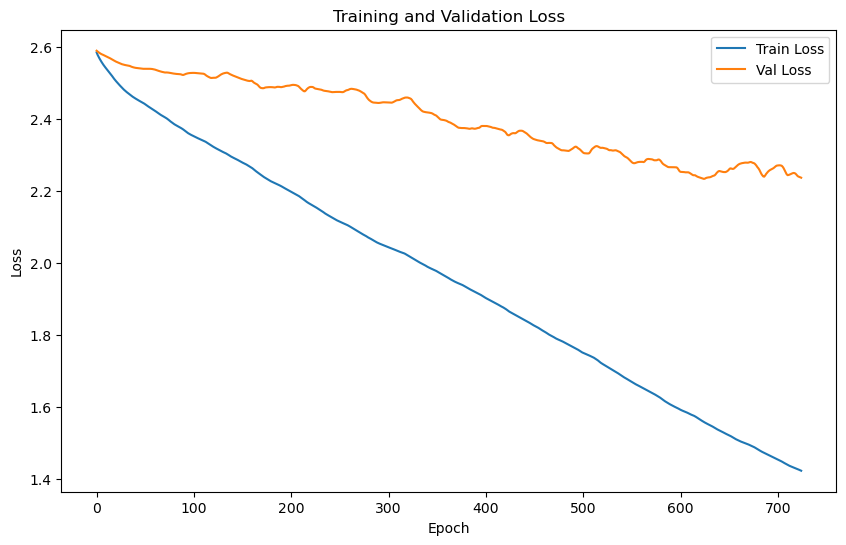

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.1399 | Test Accuracy: 45.84%


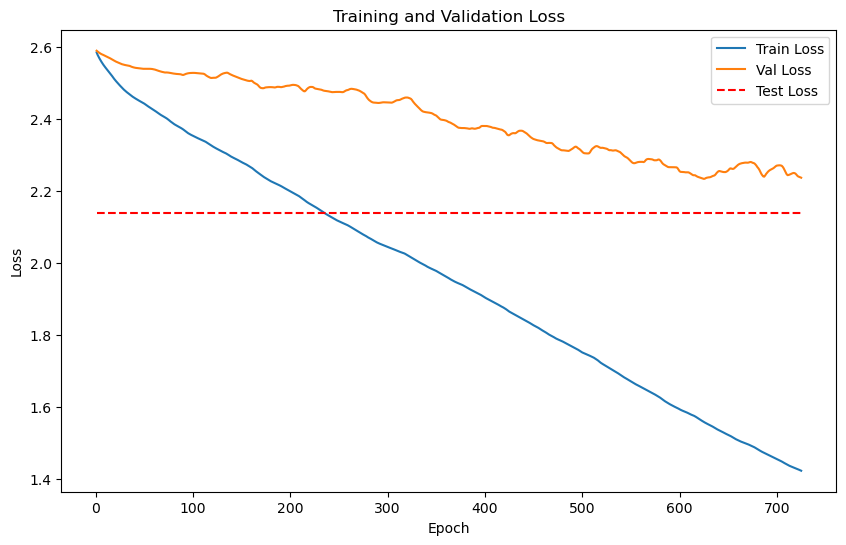

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


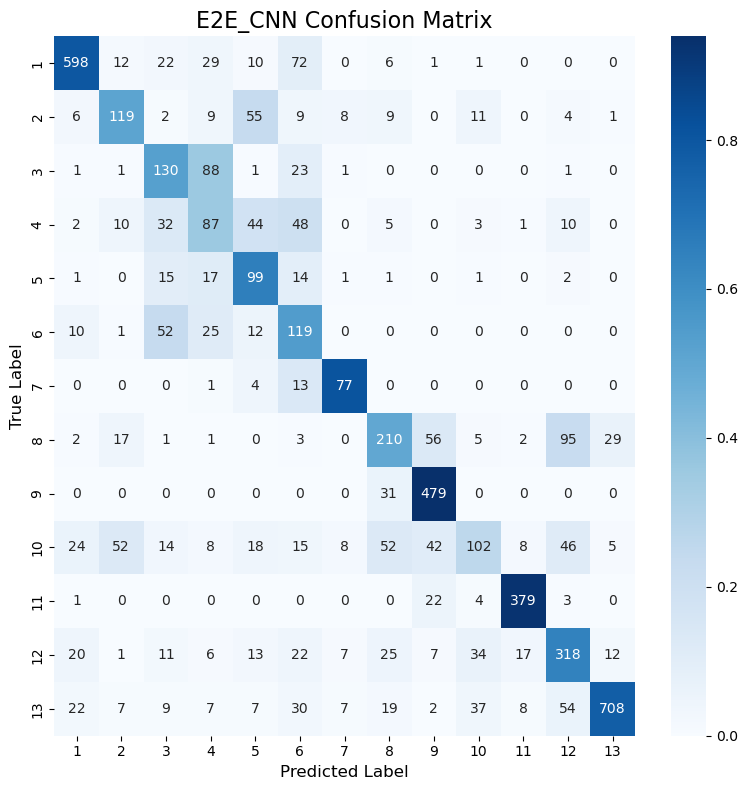

Classification Accuracy: 67.41%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


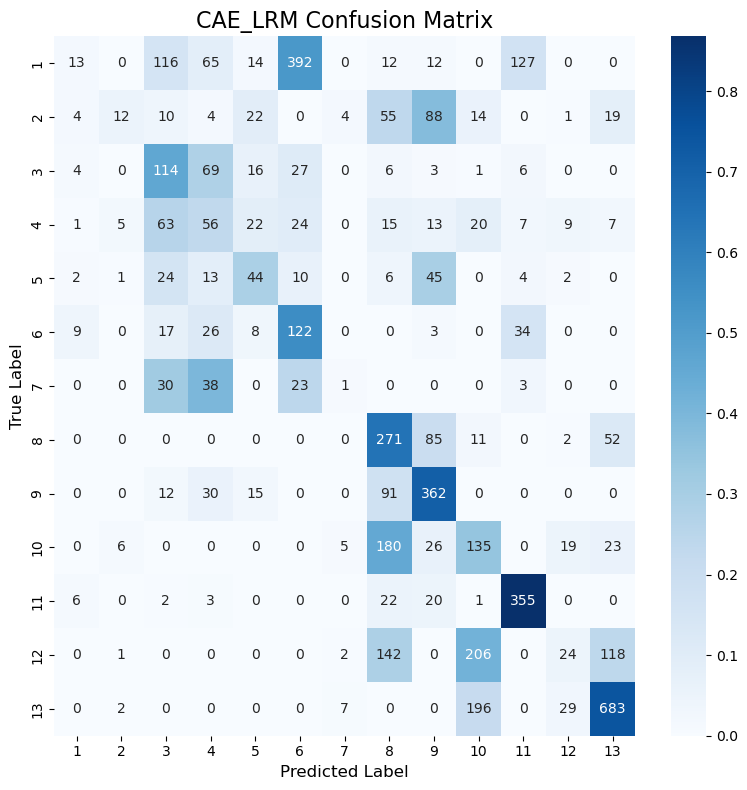

Classification Accuracy: 43.14%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


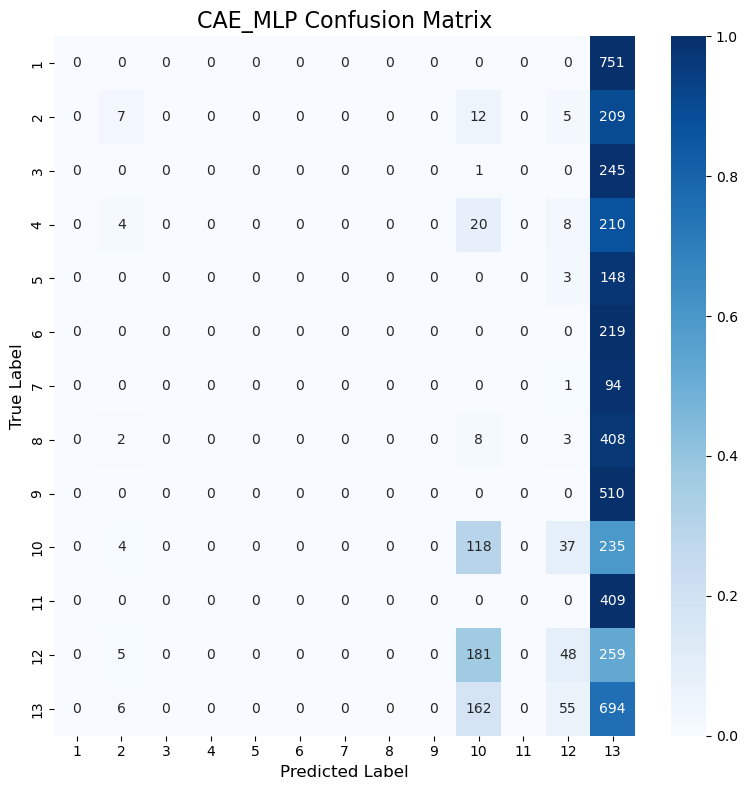

Classification Accuracy: 17.06%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


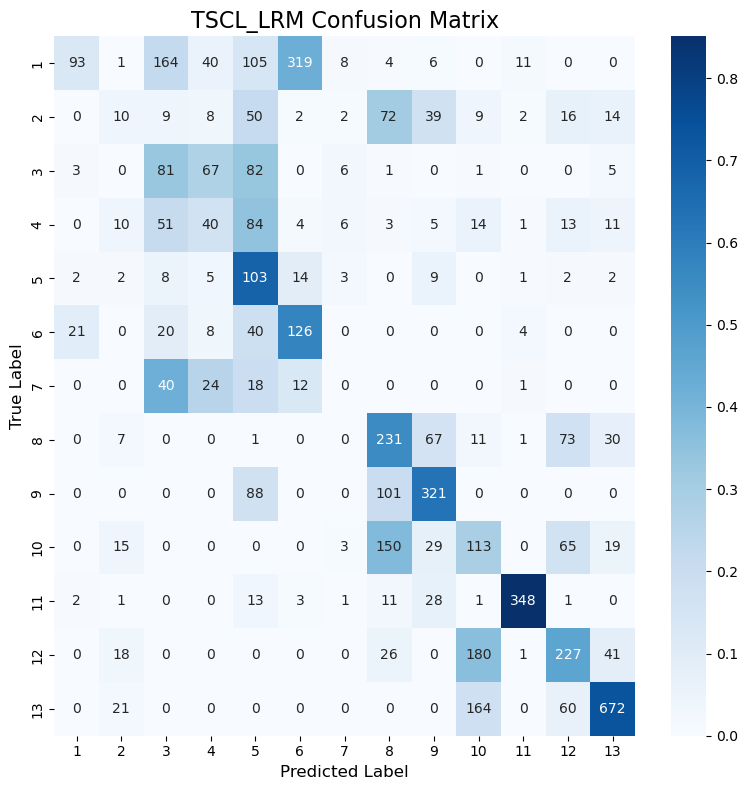

Classification Accuracy: 46.55%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


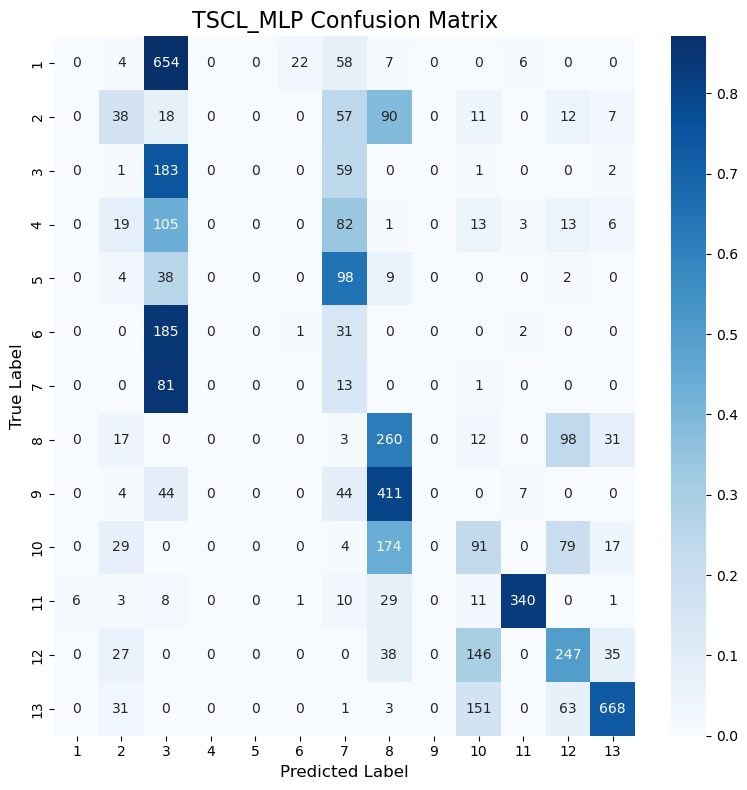

Classification Accuracy: 36.23%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


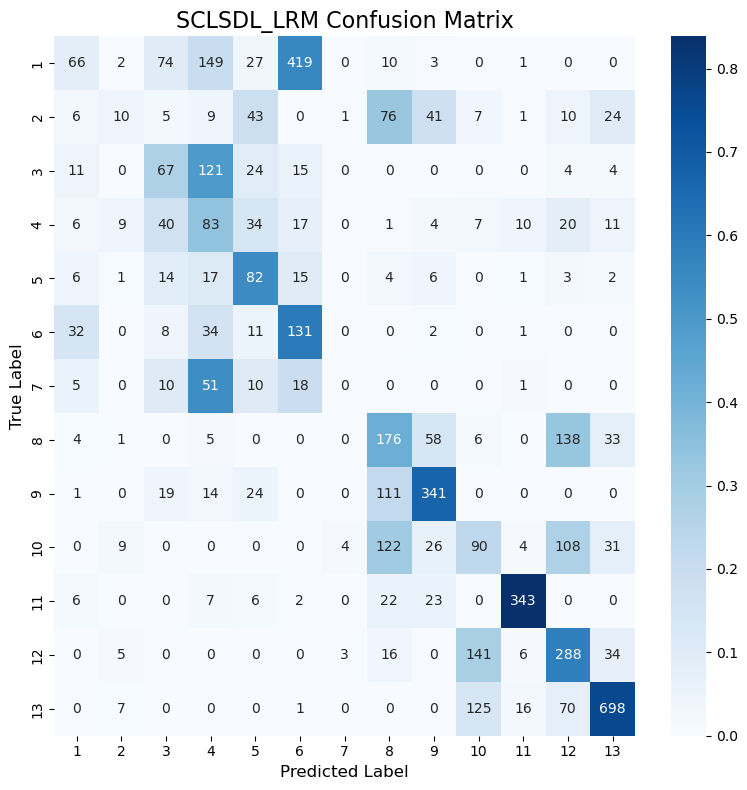

Classification Accuracy: 46.74%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


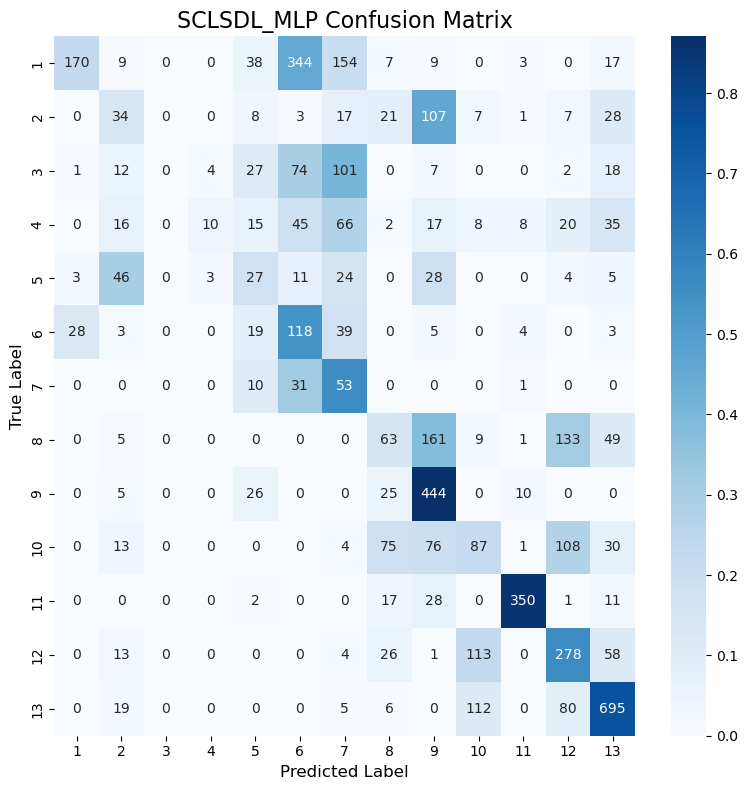

Classification Accuracy: 45.84%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          67.41
1    LRM (CAE)          43.14
2    MLP (CAE)          17.06
3     TSCL LRM          46.55
4     TSCL MLP          36.23
5  SCL_SDL LRM          46.74
6  SCL_SDL MLP          45.84

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          67.41
5  SCL_SDL LRM          46.74
3     TSCL LRM          46.55
6  SCL_SDL MLP          45.84
1    LRM (CAE)          43.14
4     TSCL MLP          36.23
2    MLP (CAE)          17.06
